# Synthetic data finding optimal k test

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "4"

In [2]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import pairwise_distances
import numpy as np
import matplotlib.pyplot as plt
from kneed import KneeLocator

In [3]:
# make a funtion to simulate the data and plot
def plot_blobs(n_clusters=3, n_samples=1000, std=0.6, random_state=42):
    # n_clusters: number of true clusters you want to simulate
    # std: spread of clusters
    # X: NumPy array of shape, coordinates of each point
    # y: label array of shape, the true cluster each point belongs to
    X, y = make_blobs(n_samples=n_samples, centers=n_clusters, cluster_std=std, random_state=random_state)

    plt.figure(figsize=(6, 5))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='tab10', s=10)
    plt.title(f"Simulated Data with {n_clusters} Cluster(s)")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

    return X, y 

In [4]:
# Gap Stats func
def compute_gap_statistic(X, k, n_refs=5):
    # Take X (datapoints) from the blob as input
    # k: num of clusters to evaluate
    # n_refs: also as b is the reference datasates to generate
    # runs kmeans and calculate the dispersion
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(X)
    # pairwise_distances gives the distance between each point to own cluster
    orig_disp = np.mean(np.min(pairwise_distances(X, kmeans.cluster_centers_), axis=1))

    # Create reference dataset
    ref_disps = []
    for _ in range(n_refs):
        # Create reference dataset with uniformly distributed random points
        random_ref = np.random.uniform(X.min(axis=0), X.max(axis=0), size=X.shape)
        # compute kmeans and cal dispersion on the reference data
        kmeans_ref = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(random_ref)
        ref_disp = np.mean(np.min(pairwise_distances(random_ref, kmeans_ref.cluster_centers_), axis=1))
        ref_disps.append(ref_disp)

    # takes the log of the average dispersion from the random data
    # subtracts the log of the dispersion on real data
    log_ref = np.log(ref_disps)
    gap = np.mean(log_ref) - np.log(orig_disp)
    err = np.std(log_ref) * np.sqrt(1 + 1/n_refs)
    return gap, err

In [8]:
def evaluate_clustering_methods(X, max_k=10):
    # take in the datapoint as X and num of cluster as input
    inertias = []
    silhouettes = [] 
    db_scores = []
    gap_scores = []
    gap_errors = []
    K_range = range(1, max_k + 1)

    for k in K_range:
        
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        labels = kmeans.fit_predict(X)
        inertias.append(kmeans.inertia_)
        gap, err = compute_gap_statistic(X, k)
        gap_scores.append(gap)
        gap_errors.append(err)

        if k > 1:
            silhouettes.append(silhouette_score(X, labels))
            db_scores.append(davies_bouldin_score(X, labels))
        else:
            silhouettes.append(np.nan)
            db_scores.append(np.nan)
            
    kneedle = KneeLocator(range(1, max_k + 1), inertias, curve='convex', direction='decreasing')
    best_elbow_k = kneedle.elbow
    best_sil_k = K_range[np.nanargmax(silhouettes)]
    best_db_k = K_range[np.nanargmin(db_scores)]
    best_gap_k = K_range[np.argmax(gap_scores)]

    # Elbow Method
    plt.figure(figsize=(6, 4))
    plt.plot(K_range, inertias, marker='o')
    plt.axvline(x=best_elbow_k, linestyle='--', color='gray', label=f"Elbow at k={best_elbow_k}")
    plt.title("Elbow Method")
    plt.xlabel("k")
    plt.ylabel("Inertia")
    plt.legend()
    plt.show()

    # Silhouette Score 
    plt.figure(figsize=(6, 4))
    plt.plot(K_range, silhouettes, marker='o')
    plt.axvline(x=best_sil_k, linestyle='--', color='gray', label=f"Best k={best_sil_k}")
    plt.title("Silhouette Score")
    plt.xlabel("k")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Davies-Bouldin Index
    plt.figure(figsize=(6, 4))
    plt.plot(K_range, db_scores, marker='o')
    plt.axvline(x=best_db_k, linestyle='--', color='gray', label=f"Best k={best_db_k}")
    plt.title("Davies-Bouldin Index")
    plt.xlabel("k")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Gap Statistic
    plt.figure(figsize=(6, 4))
    plt.errorbar(K_range, gap_scores, yerr=gap_errors, marker='o', capsize=5)
    plt.axvline(x=best_gap_k, linestyle='--', color='gray', label=f"Best k={best_gap_k}")
    plt.title("Gap Statistic")
    plt.xlabel("k")
    plt.ylabel("Gap Value")
    plt.legend()
    plt.show()

    print(f" Elbow Method: k = {best_elbow_k}")
    print(f" Silhouette Score suggests: k = {best_sil_k}")
    print(f" Davies-Bouldin Index suggests: k = {best_db_k}")
    print(f" Gap Statistic suggests: k = {best_gap_k}")


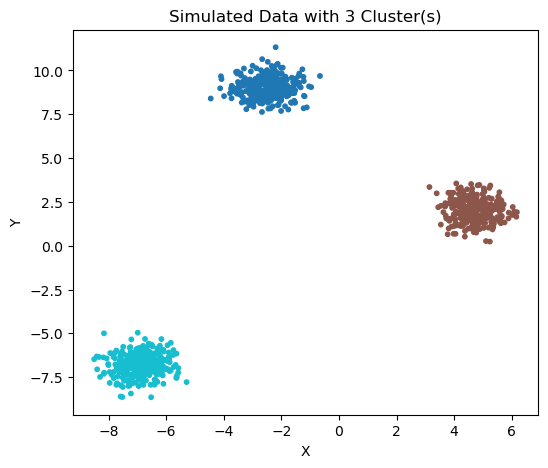

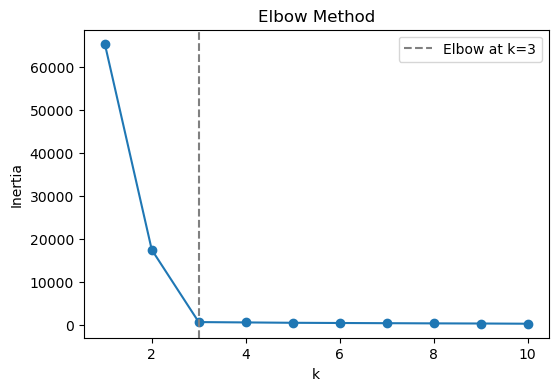

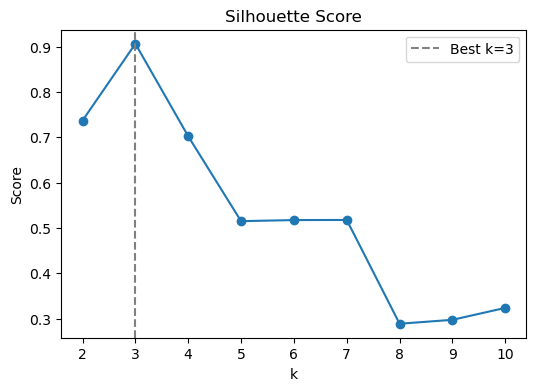

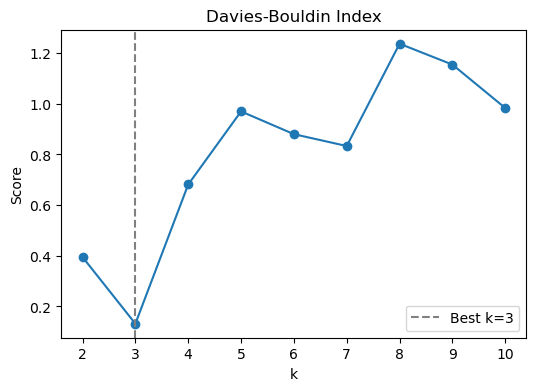

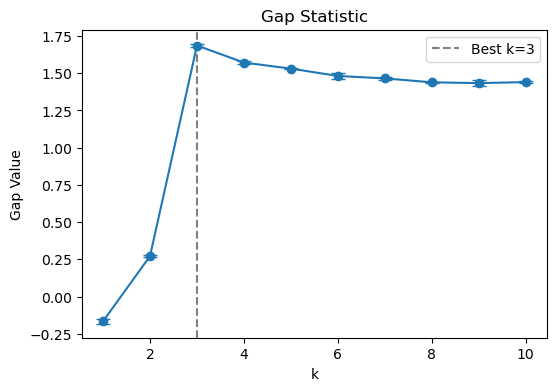

 Elbow Method: k = 3
 Silhouette Score suggests: k = 3
 Davies-Bouldin Index suggests: k = 3
 Gap Statistic suggests: k = 3


In [9]:
true_k = 3
X, y_true = plot_blobs(n_clusters=true_k)
evaluate_clustering_methods(X, max_k=10)

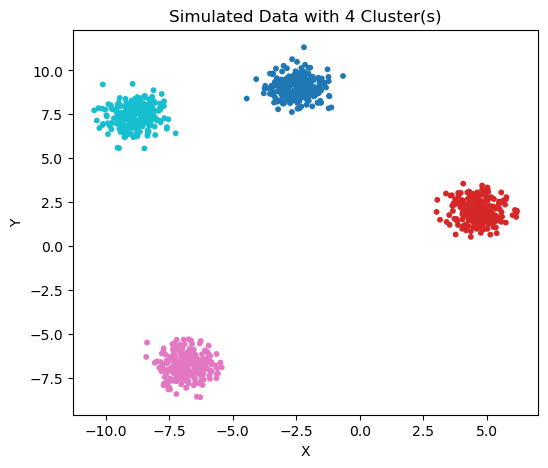

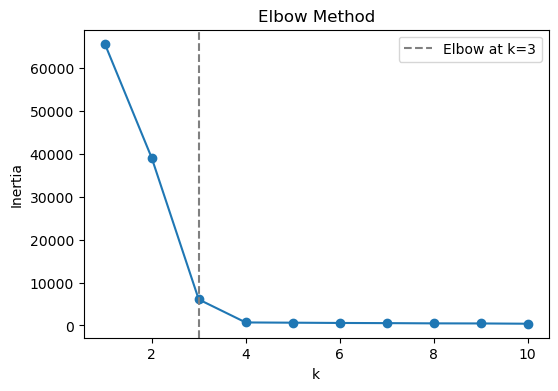

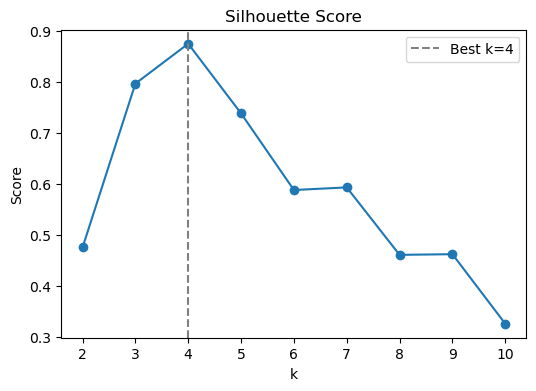

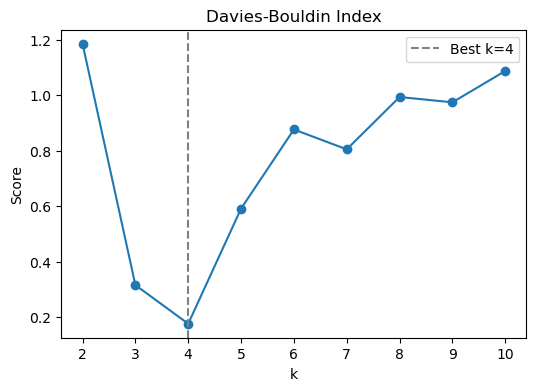

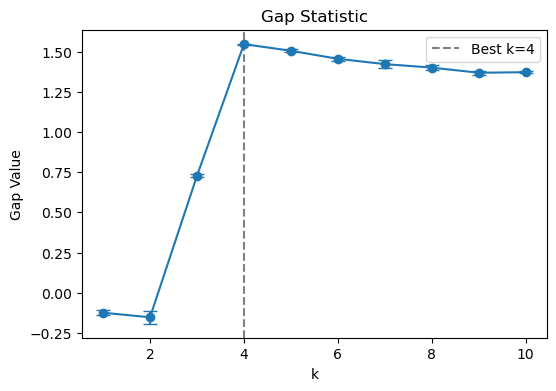

 Elbow Method: k = 3
 Silhouette Score suggests: k = 4
 Davies-Bouldin Index suggests: k = 4
 Gap Statistic suggests: k = 4


In [10]:
true_k = 4
X, y_true = plot_blobs(n_clusters=true_k)
evaluate_clustering_methods(X, max_k=10)

In [8]:
def compute_Wk(data, n_clusters):
    # run Kmeans and return WCSS (inertia)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    kmeans.fit(data)
    return kmeans.inertia_

def gap_statistic(X, max_k=10, B=10):
    # Compute Gap Statistic for range of k from 1 to max_k.
    # B: num of reference dataset
    shape = X.shape
    mins = np.min(X, axis=0)
    maxs = np.max(X, axis=0)
    
    # Stores the log(WCSS) 
    Wks = []
    # Stores the log(WCSS) for the reference dataset 
    Wkbs = np.zeros((max_k, B))

    # Compute WCSS for the actual data
    for k in range(1, max_k + 1):
        Wk = compute_Wk(X, k)
        Wks.append(np.log(Wk))

        # Generate refrence data and compute the WCSS
        for b in range(B):
            Xb = np.random.uniform(mins, maxs, size=shape)
            Wkb = compute_Wk(Xb, k)
            Wkbs[k - 1, b] = np.log(Wkb)

    # gaps: list of Gap(k) values
    gaps = np.mean(Wkbs, axis=1) - Wks
    # sk: standard deviation of reference Wk values
    sk = np.std(Wkbs, axis=1) * np.sqrt(1 + 1 / B)

    return gaps, sk


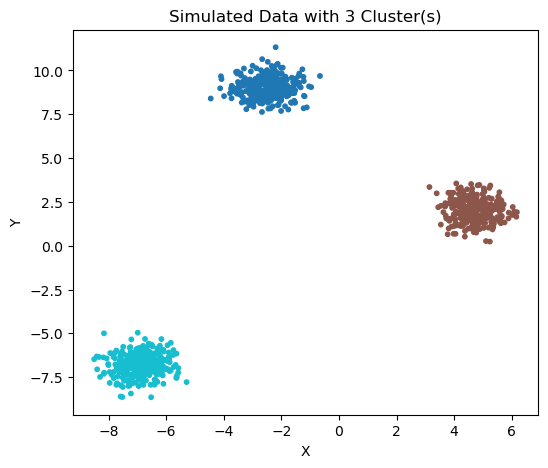

In [9]:
true_k = 3
X, y_true = plot_blobs(n_clusters=true_k)

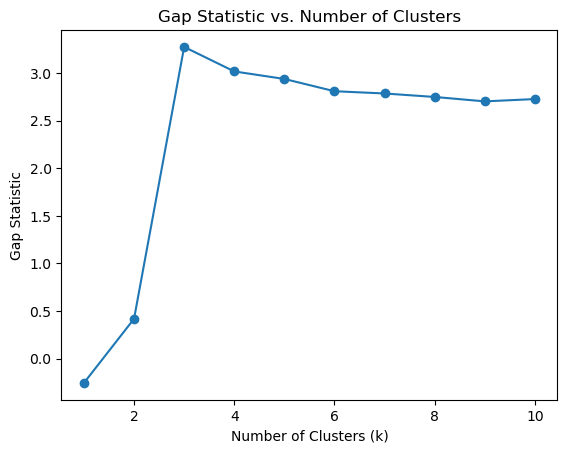

In [10]:
gaps, sk = gap_statistic(X, max_k=10, B=20)

plt.plot(range(1, len(gaps)+1), gaps, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Gap Statistic")
plt.title("Gap Statistic vs. Number of Clusters")
plt.show()

# Synthetic data robustness test

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "4"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_blobs

from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.utils import resample

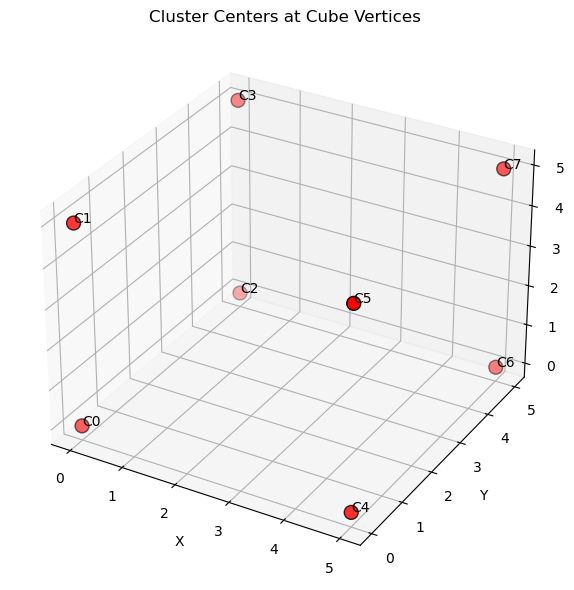

In [3]:
# create 8 vertices of a 2x2x2 cube centered at intervals of 5 units
cube_vertices = np.array([[x, y, z] for x in [0, 5] for y in [0, 5] for z in [0, 5]])

# Plot them in 3D
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(cube_vertices[:, 0], cube_vertices[:, 1], cube_vertices[:, 2],
           c='red', s=100, edgecolor='k')

# Annotate points
for i, (x, y, z) in enumerate(cube_vertices):
    ax.text(x, y, z, f'C{i}', fontsize=10, color='black')

ax.set_title("Cluster Centers at Cube Vertices")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.tight_layout()
plt.show()

In [4]:
cube_vertices

array([[0, 0, 0],
       [0, 0, 5],
       [0, 5, 0],
       [0, 5, 5],
       [5, 0, 0],
       [5, 0, 5],
       [5, 5, 0],
       [5, 5, 5]])

In [5]:
def generate_and_plot_clusters_3d(n_samples=800, cluster_std=0.5, centers= cube_vertices, random_state=42, plot=True):
    
    cube_vertices = np.array([[x, y, z] for x in [0, 5] for y in [0, 5] for z in [0, 5]])

    # Generate bolb
    X, y = make_blobs(n_samples=n_samples, centers=centers, cluster_std=cluster_std, random_state=random_state)

    if plot:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')

        # Plot the data points with colors based on true labels
        scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='tab10', s=20)

        # Plot the original cluster centers for reference
        ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2],
                   c='black', s=100, edgecolor='white', label='Cluster Centers')

        ax.set_title(f"3D Clusters (std={cluster_std}, samples={n_samples})")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        ax.legend()
        plt.tight_layout()
        plt.show()
    
    return X, y

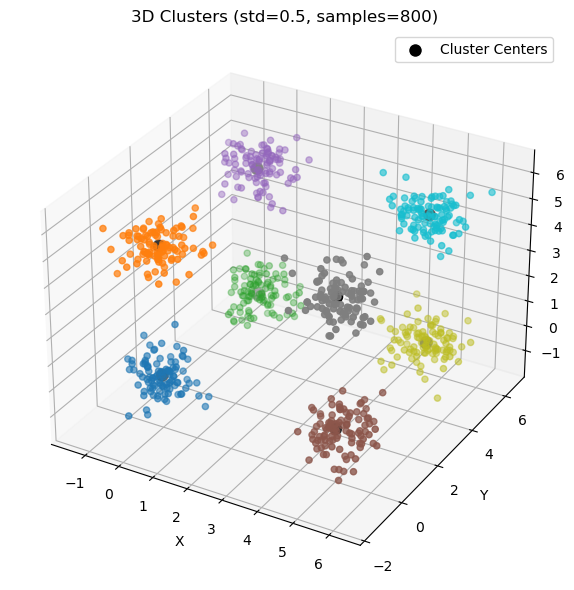

In [6]:
X, y = generate_and_plot_clusters_3d(n_samples=800, cluster_std=0.5)

In [7]:
X

array([[ 5.36254789,  5.25808914, -0.3207408 ],
       [-0.13636178,  3.65155668, -0.02714743],
       [ 0.25202326, -0.26512881,  4.60356358],
       ...,
       [ 1.2866799 ,  5.02960922,  0.00696465],
       [-0.24471972,  5.52208044,  0.34094574],
       [ 5.00517631, -0.65591812, -0.53255683]])

In [8]:
y

array([6, 2, 1, 0, 0, 2, 5, 7, 0, 3, 7, 2, 0, 7, 6, 4, 3, 2, 6, 3, 7, 6,
       7, 0, 3, 6, 6, 3, 4, 2, 4, 5, 7, 0, 5, 7, 7, 1, 7, 3, 4, 3, 0, 6,
       7, 4, 7, 1, 7, 7, 0, 6, 2, 6, 5, 4, 2, 6, 6, 2, 7, 5, 0, 1, 5, 6,
       7, 5, 4, 3, 1, 3, 7, 5, 7, 5, 6, 5, 3, 1, 1, 4, 0, 3, 7, 5, 7, 3,
       3, 6, 1, 5, 5, 5, 4, 0, 5, 3, 0, 4, 4, 4, 7, 4, 1, 1, 7, 5, 5, 6,
       6, 6, 0, 0, 7, 4, 0, 1, 1, 6, 4, 7, 7, 4, 5, 2, 0, 5, 5, 4, 4, 1,
       5, 4, 0, 4, 2, 1, 2, 2, 6, 6, 2, 6, 7, 4, 2, 5, 3, 4, 6, 5, 2, 7,
       3, 2, 0, 4, 1, 7, 2, 2, 0, 6, 1, 5, 1, 2, 2, 0, 0, 2, 4, 0, 7, 6,
       1, 4, 0, 3, 6, 2, 2, 7, 0, 4, 2, 2, 1, 0, 3, 5, 7, 4, 1, 3, 5, 6,
       1, 2, 3, 2, 6, 4, 5, 3, 4, 5, 3, 5, 0, 1, 6, 1, 2, 2, 4, 7, 1, 3,
       1, 7, 1, 2, 0, 4, 0, 2, 6, 0, 0, 6, 0, 4, 0, 1, 4, 1, 5, 3, 4, 5,
       7, 0, 7, 7, 7, 1, 3, 1, 6, 7, 3, 1, 1, 5, 4, 6, 6, 6, 4, 6, 2, 4,
       2, 4, 1, 0, 2, 4, 0, 1, 1, 7, 0, 6, 6, 1, 2, 0, 2, 1, 0, 1, 7, 3,
       3, 3, 5, 5, 5, 3, 6, 5, 7, 5, 7, 4, 7, 7, 5,

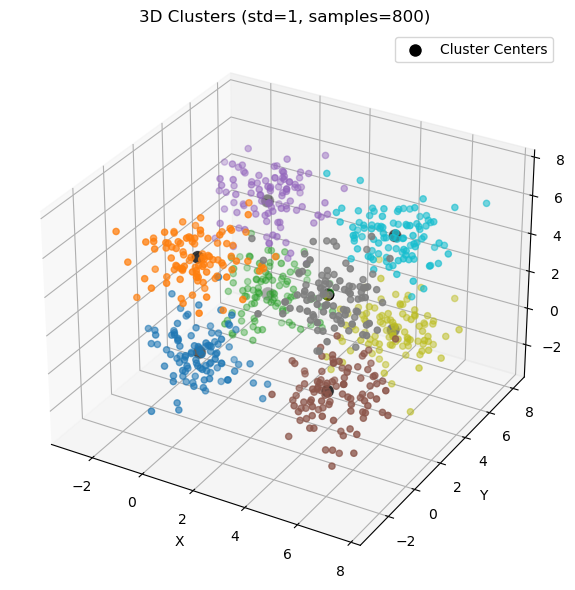

In [9]:
X_1, y_1 = generate_and_plot_clusters_3d(n_samples=800, cluster_std=1)

In [10]:
# Function to add noise dimensions
def add_noise_dims(X, num_noise_dims, std=1.0, seed=42):
    rng = np.random.default_rng(seed)
    noise = rng.normal(0, std, size=(X.shape[0], num_noise_dims))
    return np.hstack([X, noise])

In [11]:
# Simple 3D dataset
X_simple_3d = np.array([
    [0, 0, 0],
    [0, 0, 5],
    [0, 5, 0],
    [0, 5, 5],
    [5, 0, 0],
    [5, 0, 5],
    [5, 5, 0],
    [5, 5, 5]
])

for noise_dim in [0, 1, 2]:
    X_noisy = add_noise_dims(X_simple_3d, noise_dim, 1.0)
    print(f"\nNoise dims: {noise_dim}, Shape: {X_noisy.shape}")
    print(X_noisy)


Noise dims: 0, Shape: (8, 3)
[[0. 0. 0.]
 [0. 0. 5.]
 [0. 5. 0.]
 [0. 5. 5.]
 [5. 0. 0.]
 [5. 0. 5.]
 [5. 5. 0.]
 [5. 5. 5.]]

Noise dims: 1, Shape: (8, 4)
[[ 0.          0.          0.          0.30471708]
 [ 0.          0.          5.         -1.03998411]
 [ 0.          5.          0.          0.7504512 ]
 [ 0.          5.          5.          0.94056472]
 [ 5.          0.          0.         -1.95103519]
 [ 5.          0.          5.         -1.30217951]
 [ 5.          5.          0.          0.1278404 ]
 [ 5.          5.          5.         -0.31624259]]

Noise dims: 2, Shape: (8, 5)
[[ 0.          0.          0.          0.30471708 -1.03998411]
 [ 0.          0.          5.          0.7504512   0.94056472]
 [ 0.          5.          0.         -1.95103519 -1.30217951]
 [ 0.          5.          5.          0.1278404  -0.31624259]
 [ 5.          0.          0.         -0.01680116 -0.85304393]
 [ 5.          0.          5.          0.87939797  0.77779194]
 [ 5.          5.         

# Noise Dimesnion Test
## KMeans

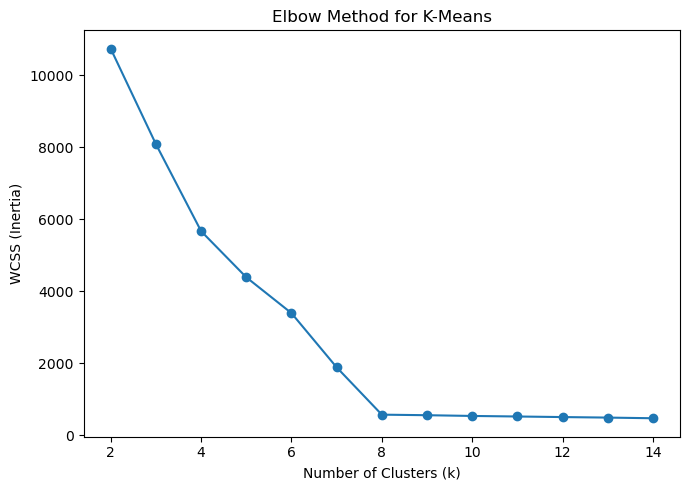

In [12]:
# Plot the albow method to define the optimal k
inertia = []
K = range(2, 15)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(7, 5))
plt.plot(K, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.title('Elbow Method for K-Means')
plt.tight_layout()
plt.show()

## Kmeans Sil Score and ARI

KMeans | Noise dims: 0, Silhouette Score: 0.760, ARI: 1.000
KMeans | Noise dims: 1, Silhouette Score: 0.651, ARI: 1.000
KMeans | Noise dims: 2, Silhouette Score: 0.571, ARI: 1.000
KMeans | Noise dims: 3, Silhouette Score: 0.510, ARI: 1.000
KMeans | Noise dims: 4, Silhouette Score: 0.461, ARI: 1.000
KMeans | Noise dims: 5, Silhouette Score: 0.423, ARI: 1.000
KMeans | Noise dims: 6, Silhouette Score: 0.389, ARI: 1.000
KMeans | Noise dims: 7, Silhouette Score: 0.284, ARI: 0.831
KMeans | Noise dims: 8, Silhouette Score: 0.337, ARI: 1.000
KMeans | Noise dims: 9, Silhouette Score: 0.316, ARI: 1.000
KMeans | Noise dims: 10, Silhouette Score: 0.299, ARI: 1.000


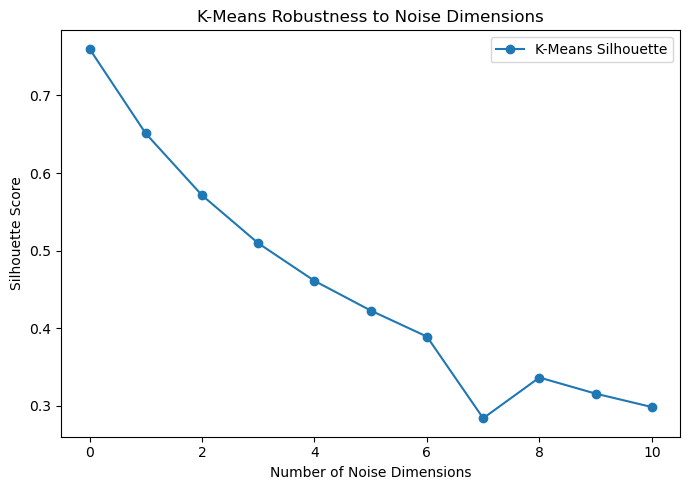

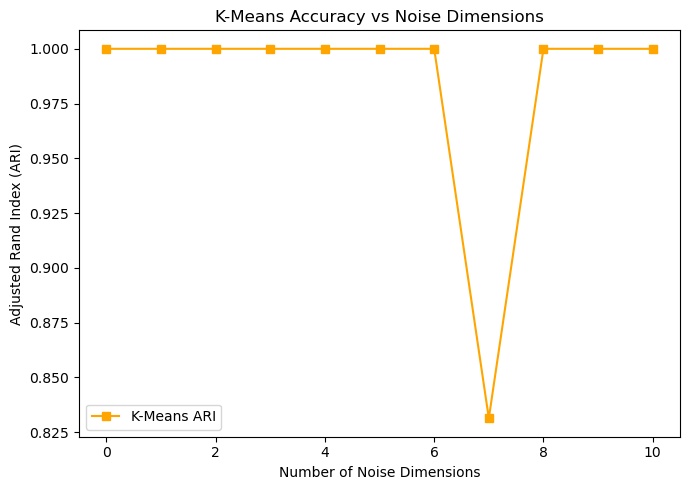

In [13]:
# Store the sil and ari score for plotting
kmeans_sil_scores_single = []
kmeans_ari_scores_single = []
noise_dims = range(0, 11)

# add noise dimension into the cluster
for d in noise_dims:
    X_noisy = add_noise_dims(X, d, 1.0)
    
    kmeans = KMeans(n_clusters=8, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_noisy)
    
    sil = silhouette_score(X_noisy, labels)
    ari = adjusted_rand_score(y, labels) 
    
    kmeans_sil_scores_single.append(sil)
    kmeans_ari_scores_single.append(ari)
    
    print(f"KMeans | Noise dims: {d}, Silhouette Score: {sil:.3f}, ARI: {ari:.3f}")

# Plot Silhouette
plt.figure(figsize=(7, 5))
plt.plot(noise_dims, kmeans_sil_scores_single, marker='o', label="K-Means Silhouette")
plt.xlabel('Number of Noise Dimensions')
plt.ylabel('Silhouette Score')
plt.title('K-Means Robustness to Noise Dimensions')
plt.legend()
plt.tight_layout()
plt.show()

# Plot ARI
plt.figure(figsize=(7, 5))
plt.plot(noise_dims, kmeans_ari_scores_single, marker='s', label="K-Means ARI", color='orange')
plt.xlabel('Number of Noise Dimensions')
plt.ylabel('Adjusted Rand Index (ARI)')
plt.title('K-Means Accuracy vs Noise Dimensions')
plt.legend()
plt.tight_layout()
plt.show()

### Stability and reliability check
Run 20 times the loops with taking mean ± standard deviation with diffrent random seed for stability and reliability on the results


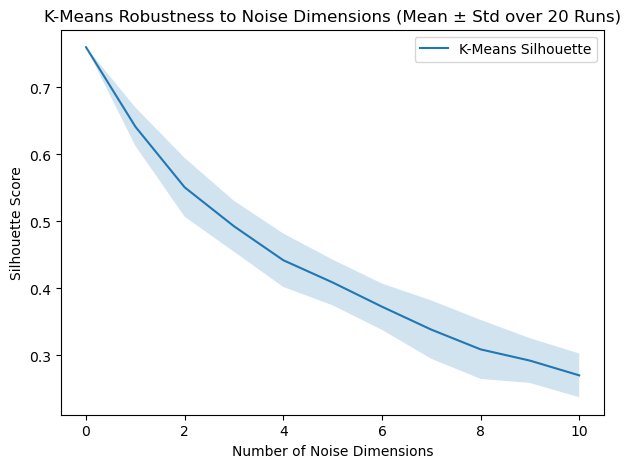

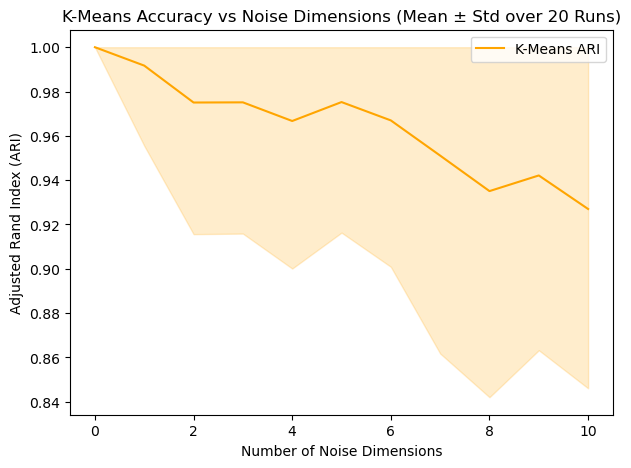

In [14]:
n_runs = 20
kmeans_sil_means = []
kmeans_sil_stds = []
kmeans_ari_means = []
kmeans_ari_stds = []

all_kmeans_sil_scores = []
all_kmeans_ari_scores = []

# use diffrent random seed
random_seeds = np.random.randint(0, 10000, size=n_runs)

for d in noise_dims:
    kmeans_sil_scores_multi = []
    kmeans_ari_scores_multi = []
    
    for seed in random_seeds:
        X_noisy = add_noise_dims(X, d, 1.0, seed=seed)
        kmeans = KMeans(n_clusters=8, random_state=42, n_init='auto')
        labels = kmeans.fit_predict(X_noisy)
        
        sil = silhouette_score(X_noisy, labels)
        ari = adjusted_rand_score(y, labels)  
        
        kmeans_sil_scores_multi.append(sil)
        kmeans_ari_scores_multi.append(ari)
    
    all_kmeans_sil_scores.append(kmeans_sil_scores_multi)
    all_kmeans_ari_scores.append(kmeans_ari_scores_multi)
    
    kmeans_sil_means.append(np.mean(kmeans_sil_scores_multi))
    kmeans_sil_stds.append(np.std(kmeans_sil_scores_multi))
    kmeans_ari_means.append(np.mean(kmeans_ari_scores_multi))
    kmeans_ari_stds.append(np.std(kmeans_ari_scores_multi))

# Plot Silhouette 
plt.figure(figsize=(7, 5))
plt.plot(noise_dims, kmeans_sil_means, label='K-Means Silhouette')
plt.title('K-Means Robustness to Noise Dimensions (Mean ± Std over 20 Runs)')
plt.fill_between(noise_dims,
                 np.array(kmeans_sil_means) - np.array(kmeans_sil_stds),
                 np.array(kmeans_sil_means) + np.array(kmeans_sil_stds),
                 alpha=0.2)
plt.xlabel("Number of Noise Dimensions")
plt.ylabel("Silhouette Score")
plt.legend()
plt.show()

# Plot ARI 
plt.figure(figsize=(7, 5))
plt.plot(noise_dims, kmeans_ari_means, label='K-Means ARI', color='orange')
plt.title('K-Means Accuracy vs Noise Dimensions (Mean ± Std over 20 Runs)')

# Clip upper and lower bounds within [0, 1]
upper = np.minimum(np.array(kmeans_ari_means) + np.array(kmeans_ari_stds), 1.0)
lower = np.maximum(np.array(kmeans_ari_means) - np.array(kmeans_ari_stds), 0.0)

plt.fill_between(noise_dims, lower, upper, alpha=0.2, color='orange')
plt.xlabel("Number of Noise Dimensions")
plt.ylabel("Adjusted Rand Index (ARI)")
plt.legend()
plt.show()


# DBSCAN

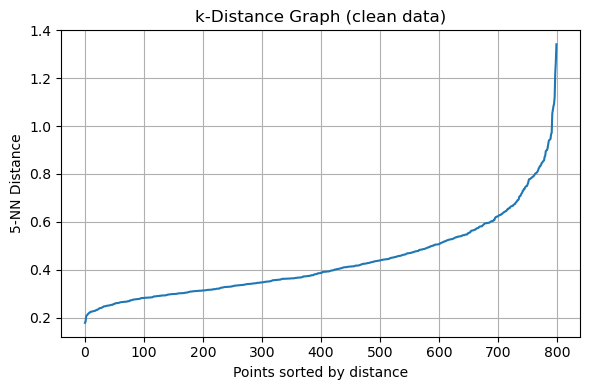

In [15]:
# plot k-distance to find the eps param
k = 5
nn = NearestNeighbors(n_neighbors=k)
nn.fit(X)
distances, _ = nn.kneighbors(X)
k_distances = np.sort(distances[:, k-1])

plt.figure(figsize=(6, 4))
plt.plot(k_distances)
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{k}-NN Distance')
plt.title('k-Distance Graph (clean data)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
# run the DBSCAN
eps = 0.95
min_samples = 5
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(X)

# Exclude noise points (-1) for silhouette score
mask = labels != -1
if len(set(labels[mask])) > 1:
    sil_score = silhouette_score(X[mask], labels[mask])
else:
    sil_score = -1

print(f"DBSCAN Silhouette Score: {sil_score:.3f}")
print(f"Number of clusters (excluding noise): {len(set(labels)) - (1 if -1 in labels else 0)}")
print(f"Noise points: {(labels == -1).sum()}")

DBSCAN Silhouette Score: 0.761
Number of clusters (excluding noise): 8
Noise points: 1


## Fixed eps and min_sample

Noise dims: 0, Silhouette: 0.760, ARI: 1.000
Unique labels at noise dim 0: [0 1 2 3 4 5 6 7]
Noise dims: 1, Silhouette: 0.649, ARI: 0.999
Unique labels at noise dim 1: [-1  0  1  2  3  4  5  6  7]
Noise dims: 2, Silhouette: 0.575, ARI: 0.977
Unique labels at noise dim 2: [-1  0  1  2  3  4  5  6  7]
Noise dims: 3, Silhouette: 0.498, ARI: 0.872
Unique labels at noise dim 3: [-1  0  1  2  3  4  5  6  7  8]
Noise dims: 4, Silhouette: 0.485, ARI: 0.483
Unique labels at noise dim 4: [-1  0  1  2  3  4  5  6  7  8]
Noise dims: 5, Silhouette: 0.438, ARI: 0.062
Unique labels at noise dim 5: [-1  0  1  2  3  4  5  6  7  8  9 10 11]
Noise dims: 6, Silhouette: 0.398, ARI: 0.002
Unique labels at noise dim 6: [-1  0  1  2  3  4  5  6  7]
Noise dims: 7, Silhouette: nan, ARI: 0.000
Unique labels at noise dim 7: [-1  0]
Noise dims: 8, Silhouette: nan, ARI: 0.000
Unique labels at noise dim 8: [-1]
Noise dims: 9, Silhouette: nan, ARI: 0.000
Unique labels at noise dim 9: [-1]
Noise dims: 10, Silhouette: 

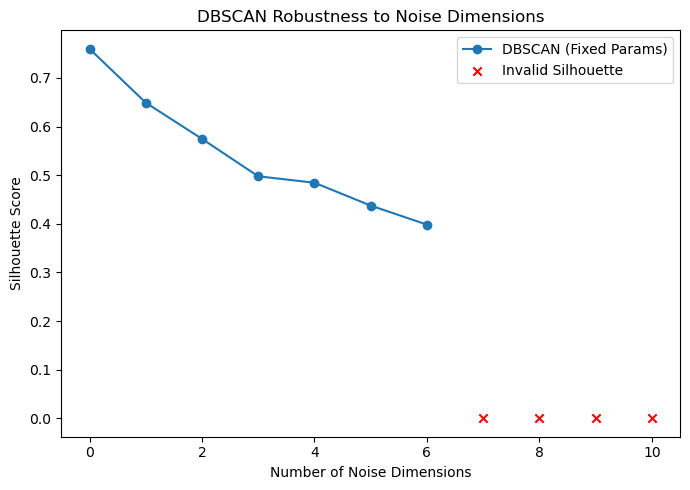

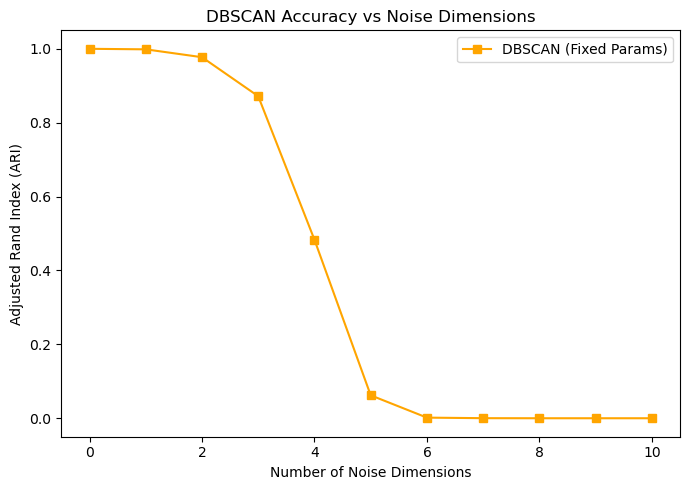

In [17]:
# Fixed eps and min_sample
dbscan_sil_scores = []
dbscan_ari_scores = []

for d in noise_dims:
    X_noisy = add_noise_dims(X, d, 1.0, seed=seed)
    
    dbscan = DBSCAN(eps=1.5, min_samples=5)
    labels = dbscan.fit_predict(X_noisy)
    
    # Silhouette (exclude noise)
    # creat boolean mask to filter out the noise (-1)
    mask = labels != -1
    # check if more then 1 cluster as sil need at least 2 clusters
    # check if there is at least one valid point which is not noise
    if len(set(labels[mask])) > 1 and mask.sum() > 0:
        # if yes then compute sil score
        sil = silhouette_score(X_noisy[mask], labels[mask])
    else:
        # if not state as nan
        sil = np.nan  
    
    # ARI 
    ari = adjusted_rand_score(y, labels)  
    
    dbscan_sil_scores.append(sil)
    dbscan_ari_scores.append(ari)
    
    print(f"Noise dims: {d}, Silhouette: {sil:.3f}, ARI: {ari:.3f}")
    print(f"Unique labels at noise dim {d}: {np.unique(labels)}")

# Convert to NumPy array for masking in plots
noise_dims_dbscan = np.array(noise_dims)
dbscan_sil_scores = np.array(dbscan_sil_scores, dtype=float)
dbscan_ari_scores = np.array(dbscan_ari_scores, dtype=float)

# Plot Silhouette 
plt.figure(figsize=(7, 5))
plt.plot(noise_dims_dbscan, dbscan_sil_scores, marker='o', label='DBSCAN (Fixed Params)', zorder=1)

# Mark NaN points with red X
nan_mask = np.isnan(dbscan_sil_scores)
plt.scatter(noise_dims_dbscan[nan_mask], [0]*nan_mask.sum(), marker='x', color='red', label='Invalid Silhouette', zorder=2)
plt.xlabel('Number of Noise Dimensions')
plt.ylabel('Silhouette Score')
plt.title('DBSCAN Robustness to Noise Dimensions')
plt.legend()
plt.tight_layout()
plt.show()

# ARI
plt.figure(figsize=(7, 5))
plt.plot(noise_dims_dbscan, dbscan_ari_scores, marker='s', label='DBSCAN (Fixed Params)', color='orange')
plt.xlabel('Number of Noise Dimensions')
plt.ylabel('Adjusted Rand Index (ARI)')
plt.title('DBSCAN Accuracy vs Noise Dimensions')
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
n_runs = 20
dbscan_sil_means, dbscan_sil_stds = [], []
dbscan_ari_means, dbscan_ari_stds = [], []
dbscan_sil_valid_counts = [] 

avg_clusters_per_dim = []   
avg_noise_ratio_per_dim = []  

all_dbscan_sil_scores, all_dbscan_ari_scores = [], []

random_seeds = np.random.randint(0, 10000, size=n_runs)

for d in noise_dims:  
    dbscan_sil_scores1, dbscan_ari_scores1 = [], []
    num_clusters_list = []     
    noise_ratio_list = []      
    
    for seed in random_seeds:
        X_noisy = add_noise_dims(X, d, 1.0, seed=seed)
        
        dbscan = DBSCAN(eps=1.5, min_samples=5)
        labels = dbscan.fit_predict(X_noisy)

        # calculate the cluster
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  
        num_clusters_list.append(n_clusters)

        # calculate the noise
        noise_ratio = np.sum(labels == -1) / len(labels)
        noise_ratio_list.append(noise_ratio)
        
        # Silhouette (exclude noise)
        # creat boolean mask to filter out the noise (-1)
        mask = labels != -1
        # check if more then 1 cluster as sil need at least 2 clusters
        # check if there is at least one valid point which is not noise
        if len(set(labels[mask])) > 1 and mask.sum() > 0:
            # if yes then compute sil score
            sil = silhouette_score(X_noisy[mask], labels[mask])
        else:
            # if not state as nan
            sil = np.nan  
            
        ari = adjusted_rand_score(y, labels)  

        dbscan_sil_scores1.append(sil)
        dbscan_ari_scores1.append(ari)

    all_dbscan_sil_scores.append(dbscan_sil_scores1)
    all_dbscan_ari_scores.append(dbscan_ari_scores1)

    # Count valid silhouette runs
    valid_count = np.sum(~np.isnan(dbscan_sil_scores1))
    dbscan_sil_valid_counts.append(valid_count)

    # Store avg clusters & avg noise ratio
    avg_clusters_per_dim.append(np.mean(num_clusters_list))
    avg_noise_ratio_per_dim.append(np.mean(noise_ratio_list))

    if valid_count == 0:
        # if no runs stores 0 
        dbscan_sil_means.append(0)
        dbscan_sil_stds.append(0)
    else:
        # if more than one run compute the mean and std
        dbscan_sil_means.append(np.nanmean(dbscan_sil_scores1))
        dbscan_sil_stds.append(np.nanstd(dbscan_sil_scores1))

    dbscan_ari_means.append(np.mean(dbscan_ari_scores1))
    dbscan_ari_stds.append(np.std(dbscan_ari_scores1))

for i, d in enumerate(noise_dims):
    print(f"Noise dim {d}: valid_runs={dbscan_sil_valid_counts[i]}, "
          f"avg_clusters={avg_clusters_per_dim[i]:.2f}, "
          f"avg_noise_ratio={avg_noise_ratio_per_dim[i]:.2f}, "
          f"sil_mean={dbscan_sil_means[i]:.3f}, "
          f"ari_mean={dbscan_ari_means[i]:.3f}")

Noise dim 0: valid_runs=20, avg_clusters=8.00, avg_noise_ratio=0.00, sil_mean=0.760, ari_mean=1.000
Noise dim 1: valid_runs=20, avg_clusters=8.00, avg_noise_ratio=0.00, sil_mean=0.651, ari_mean=0.998
Noise dim 2: valid_runs=20, avg_clusters=8.00, avg_noise_ratio=0.02, sil_mean=0.578, ari_mean=0.979
Noise dim 3: valid_runs=20, avg_clusters=8.05, avg_noise_ratio=0.09, sil_mean=0.532, ari_mean=0.872
Noise dim 4: valid_runs=20, avg_clusters=9.45, avg_noise_ratio=0.32, sil_mean=0.465, ari_mean=0.416
Noise dim 5: valid_runs=20, avg_clusters=15.35, avg_noise_ratio=0.69, sil_mean=0.332, ari_mean=0.036
Noise dim 6: valid_runs=19, avg_clusters=6.40, avg_noise_ratio=0.94, sil_mean=0.525, ari_mean=0.002
Noise dim 7: valid_runs=0, avg_clusters=0.30, avg_noise_ratio=1.00, sil_mean=0.000, ari_mean=0.000
Noise dim 8: valid_runs=0, avg_clusters=0.00, avg_noise_ratio=1.00, sil_mean=0.000, ari_mean=0.000
Noise dim 9: valid_runs=0, avg_clusters=0.00, avg_noise_ratio=1.00, sil_mean=0.000, ari_mean=0.000
No

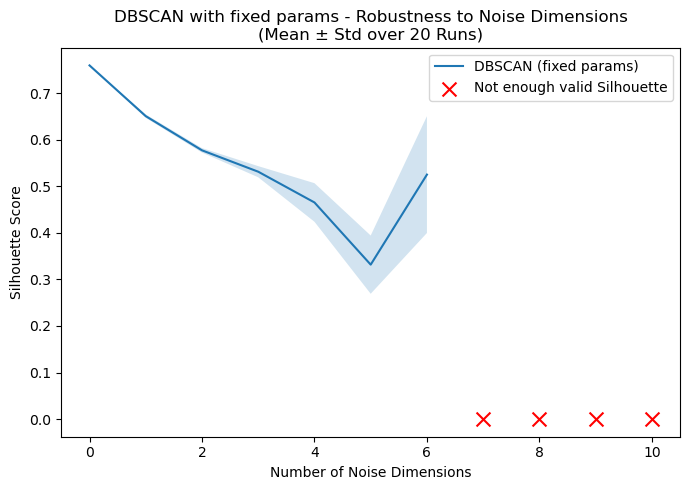

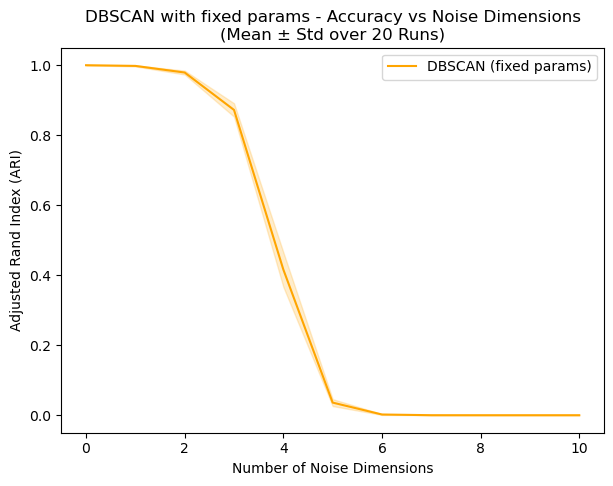

In [38]:
# Convert to numpy arrays for easier indexing
noise_dims_arr = np.array(noise_dims)
sil_means_arr  = np.array(dbscan_sil_means, dtype=float)
sil_stds_arr   = np.array(dbscan_sil_stds, dtype=float)
ari_means_arr  = np.array(dbscan_ari_means, dtype=float)
ari_stds_arr   = np.array(dbscan_ari_stds, dtype=float)
valid_counts   = np.array(dbscan_sil_valid_counts)
min_valid = 10

# Make a copy of means where invalid points are set to NaN
sil_means_plot = sil_means_arr.copy()
sil_means_plot[valid_counts < min_valid] = np.nan

# masks
band_mask = valid_counts >= min_valid  # fill band only where fully valid
invalid_mask = valid_counts < min_valid  # mark invalid dims

# Plot Silhouette
plt.figure(figsize=(7, 5))
plt.plot(noise_dims_arr, sil_means_plot, label='DBSCAN (fixed params)')

# Only fill where fully valid (avoids filling across NaNs)
plt.fill_between(noise_dims_arr[band_mask],
                 sil_means_arr[band_mask] - sil_stds_arr[band_mask],
                 sil_means_arr[band_mask] + sil_stds_arr[band_mask],
                 alpha=0.2)

# Mark dims that weren't fully valid (incl. 0 valid)
plt.scatter(noise_dims_arr[invalid_mask],
            np.zeros(invalid_mask.sum()),
            color='red', marker='x', s=100, label='Not enough valid Silhouette')

plt.title('DBSCAN with fixed params - Robustness to Noise Dimensions\n(Mean ± Std over 20 Runs)')
plt.xlabel("Number of Noise Dimensions")
plt.ylabel("Silhouette Score")
plt.legend()
plt.tight_layout()
plt.show()

# ARI plot 
plt.figure(figsize=(7, 5))
plt.plot(noise_dims_arr, ari_means_arr, label='DBSCAN (fixed params)', color='orange')
plt.fill_between(noise_dims_arr,
                 ari_means_arr - ari_stds_arr,
                 ari_means_arr + ari_stds_arr,
                 alpha=0.2, color='orange')
plt.title('DBSCAN with fixed params - Accuracy vs Noise Dimensions\n(Mean ± Std over 20 Runs)')
plt.xlabel("Number of Noise Dimensions")
plt.ylabel("Adjusted Rand Index (ARI)")
plt.legend()
plt.show()

## Fixed min_sample with best eps

Noise dims: 0, Best eps: 0.50, Silhouette: 0.791, ARI: 0.790, Clusters: 8, Noise ratio: 0.13
Unique labels at noise dim 0 (best eps): [-1  0  1  2  3  4  5  6  7]
Noise dims: 1, Best eps: 0.76, Silhouette: 0.694, ARI: 0.712, Clusters: 8, Noise ratio: 0.17
Unique labels at noise dim 1 (best eps): [-1  0  1  2  3  4  5  6  7]
Noise dims: 2, Best eps: 0.89, Silhouette: 0.611, ARI: 0.279, Clusters: 9, Noise ratio: 0.40
Unique labels at noise dim 2 (best eps): [-1  0  1  2  3  4  5  6  7  8]
Noise dims: 3, Best eps: 0.76, Silhouette: 0.835, ARI: 0.001, Clusters: 3, Noise ratio: 0.97
Unique labels at noise dim 3 (best eps): [-1  0  1  2]
Noise dims: 4, Best eps: 1.03, Silhouette: 0.599, ARI: 0.001, Clusters: 6, Noise ratio: 0.96
Unique labels at noise dim 4 (best eps): [-1  0  1  2  3  4  5]
Noise dims: 5, Best eps: 1.16, Silhouette: 0.790, ARI: 0.000, Clusters: 2, Noise ratio: 0.99
Unique labels at noise dim 5 (best eps): [-1  0  1]
Noise dims: 6, Best eps: 1.42, Silhouette: 0.495, ARI: 0.0

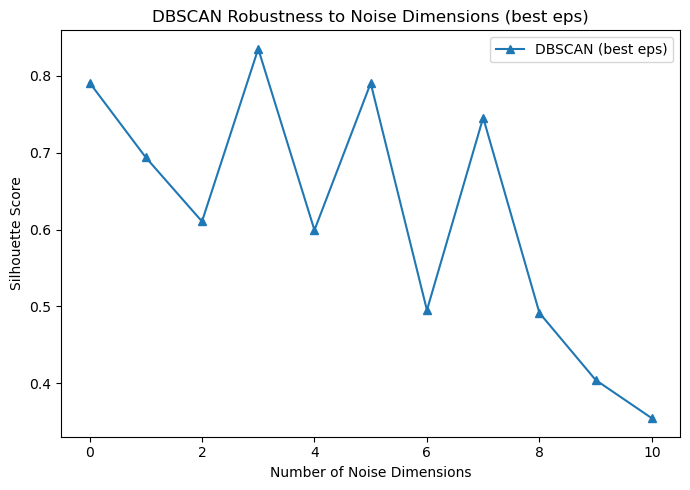

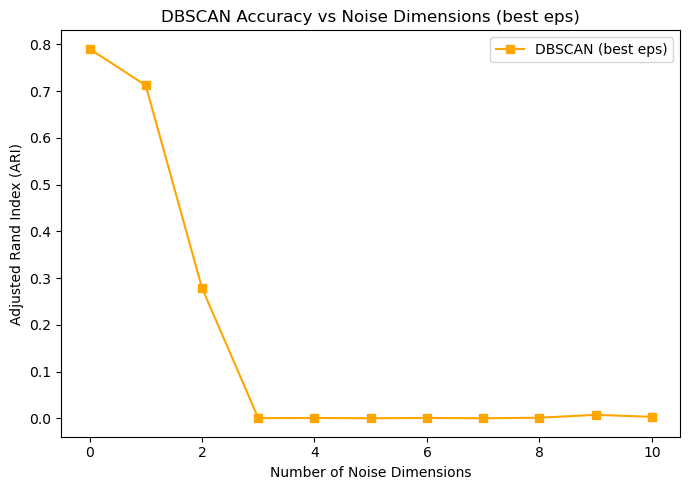

In [20]:
# Fixed min_sample with best eps
eps_range = np.linspace(0.5, 3.0, 20)
best_sil_scores, best_ari_scores = [],[]
best_eps_values = []
best_n_clusters = []
best_noise_ratio = []

for d in noise_dims:
    X_noisy = add_noise_dims(X, d, 1.0)
    
    best_sil = -np.inf # put negative infinite as worst value
    best_ari = np.nan
    best_eps = None
    best_labels = None
    
    for eps in eps_range:
        dbscan = DBSCAN(eps=eps, min_samples=5)
        labels = dbscan.fit_predict(X_noisy)
        
        # Silhouette (exclude noise)
        # creat boolean mask to filter out the noise (-1)
        mask = labels != -1
        # check if more then 1 cluster as sil need at least 2 clusters
        # check if there is at least one valid point which is not noise
        if len(set(labels[mask])) > 1 and mask.sum() > 0:
            # if yes then compute sil score
            sil = silhouette_score(X_noisy[mask], labels[mask])
            ari = adjusted_rand_score(y, labels)  # y = true labels
            
            if sil > best_sil:
                best_sil = sil
                best_ari = ari
                best_eps = eps
                best_labels = labels  
        
    # record results for this noise dimension
    if best_labels is None:
        # no valid eps -> mark as NaN/None; use 0 clusters and noise_ratio=1 for context
        best_sil_scores.append(np.nan)
        best_ari_scores.append(np.nan)
        best_eps_values.append(None)
        best_n_clusters.append(0)
        best_noise_ratio.append(1.0)
        print(f"Noise dims: {d}, no valid eps (all one cluster or all noise).")
    else:
        n_clusters = len(set(best_labels)) - (1 if -1 in best_labels else 0)
        noise_ratio = (best_labels == -1).mean()

        best_sil_scores.append(best_sil)
        best_ari_scores.append(best_ari)
        best_eps_values.append(best_eps)
        best_n_clusters.append(n_clusters)
        best_noise_ratio.append(noise_ratio)

        print(f"Noise dims: {d}, Best eps: {best_eps:.2f}, "
              f"Silhouette: {best_sil:.3f}, ARI: {best_ari:.3f}, "
              f"Clusters: {n_clusters}, Noise ratio: {noise_ratio:.2f}")
        print(f"Unique labels at noise dim {d} (best eps): {np.unique(best_labels)}")

x = np.array(noise_dims)
sil = np.array(best_sil_scores, dtype=float)
ari = np.array(best_ari_scores, dtype=float)

# Plot Silhouette
plt.figure(figsize=(7, 5))
plt.plot(x, sil, marker='^', label='DBSCAN (best eps)')
plt.xlabel("Number of Noise Dimensions"); plt.ylabel("Silhouette Score")
plt.title("DBSCAN Robustness to Noise Dimensions (best eps)")
plt.legend(); plt.tight_layout(); plt.show()

# Plot ARI
plt.figure(figsize=(7, 5))
plt.plot(x, ari, marker='s', label='DBSCAN (best eps)', color='orange')
plt.xlabel("Number of Noise Dimensions"); plt.ylabel("Adjusted Rand Index (ARI)")
plt.title("DBSCAN Accuracy vs Noise Dimensions (best eps)")
plt.legend(); plt.tight_layout(); plt.show()

## Best eps and min_sample

Noise dims: 0, Best eps: 0.50, Best min_samples: 19, Silhouette: 0.855, ARI: 0.128, Clusters: 8, Noise ratio: 0.54
Unique labels at noise dim 0 (best params): [-1  0  1  2  3  4  5  6  7]
Noise dims: 1, Best eps: 0.50, Best min_samples: 9, Silhouette: 0.930, ARI: 0.003, Clusters: 2, Noise ratio: 0.96
Unique labels at noise dim 1 (best params): [-1  0  1]
Noise dims: 2, Best eps: 0.63, Best min_samples: 6, Silhouette: 0.871, ARI: 0.001, Clusters: 2, Noise ratio: 0.98
Unique labels at noise dim 2 (best params): [-1  0  1]
Noise dims: 3, Best eps: 0.76, Best min_samples: 5, Silhouette: 0.835, ARI: 0.001, Clusters: 3, Noise ratio: 0.97
Unique labels at noise dim 3 (best params): [-1  0  1  2]
Noise dims: 4, Best eps: 1.29, Best min_samples: 12, Silhouette: 0.846, ARI: 0.002, Clusters: 2, Noise ratio: 0.97
Unique labels at noise dim 4 (best params): [-1  0  1]
Noise dims: 5, Best eps: 1.16, Best min_samples: 5, Silhouette: 0.790, ARI: 0.000, Clusters: 2, Noise ratio: 0.99
Unique labels at n

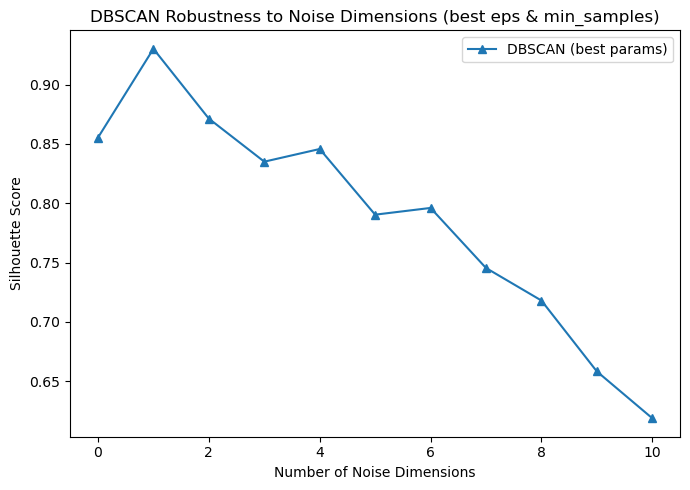

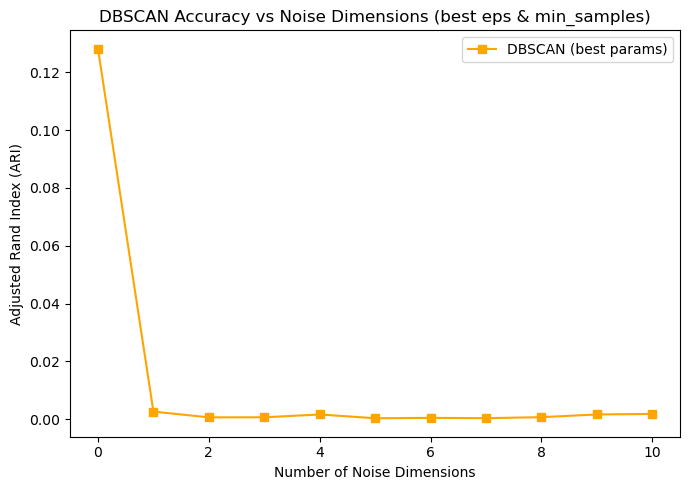

In [21]:
# Best eps and min_sample
eps_range_2 = np.linspace(0.5, 3.0, 20)
min_samples_range_2 = range(5, 20)  

best_sil_scores_2 = []
best_ari_scores_2 = []
best_eps_values_2 = []
best_min_samples_values_2 = []
best_n_clusters_2 = []
best_noise_ratio_2 = []

for d in noise_dims:
    X_noisy_2 = add_noise_dims(X, d, 1.0)
    
    best_sil = -np.inf
    best_ari = np.nan
    best_eps = None
    best_min_samples = None
    best_labels = None
    
    for eps in eps_range_2:
        for min_samples in min_samples_range_2:
            dbscan_2 = DBSCAN(eps=eps, min_samples=min_samples)
            labels_2 = dbscan_2.fit_predict(X_noisy_2)
            
            # Silhouette (exclude noise)
            # creat boolean mask to filter out the noise (-1)
            mask_2 = labels_2 != -1
            # check if more then 1 cluster as sil need at least 2 clusters
            # check if there is at least one valid point which is not noise
            if len(set(labels_2[mask_2])) > 1 and mask_2.sum() > 0:
                # if yes then compute sil score
                sil_2 = silhouette_score(X_noisy_2[mask_2], labels_2[mask_2])
                ari_2 = adjusted_rand_score(y, labels_2)  # y = true labels

                if sil_2 > best_sil:
                    best_sil = sil_2
                    best_ari = ari_2
                    best_eps = eps
                    best_min_samples = min_samples
                    best_labels = labels_2
    
    if best_labels is None:
        # no valid (eps, min_samples) gave ≥2 non-noise clusters
        best_sil_scores_2.append(np.nan)
        best_ari_scores_2.append(np.nan)
        best_eps_values_2.append(None)
        best_min_samples_values_2.append(None)
        best_n_clusters_2.append(0)
        best_noise_ratio_2.append(1.0)
        print(f"Noise dims: {d}, no valid (eps, min_samples).")
    else:
        n_clusters = len(set(best_labels)) - (1 if -1 in best_labels else 0)
        noise_ratio = (best_labels == -1).mean()

        best_sil_scores_2.append(best_sil)
        best_ari_scores_2.append(best_ari)
        best_eps_values_2.append(best_eps)
        best_min_samples_values_2.append(best_min_samples)
        best_n_clusters_2.append(n_clusters)
        best_noise_ratio_2.append(noise_ratio)

        print(
            f"Noise dims: {d}, Best eps: {best_eps:.2f}, Best min_samples: {best_min_samples}, "
            f"Silhouette: {best_sil:.3f}, ARI: {best_ari:.3f}, "
            f"Clusters: {n_clusters}, Noise ratio: {noise_ratio:.2f}"
        )
        print(f"Unique labels at noise dim {d} (best params): {np.unique(best_labels)}")

# Plot Silhouette
x = np.array(noise_dims)
sil2 = np.array(best_sil_scores_2, dtype=float)
ari2 = np.array(best_ari_scores_2, dtype=float)

plt.figure(figsize=(7, 5))
plt.plot(x, sil2, marker='^', label='DBSCAN (best params)')
plt.xlabel("Number of Noise Dimensions")
plt.ylabel("Silhouette Score")
plt.title("DBSCAN Robustness to Noise Dimensions (best eps & min_samples)")
plt.legend(); plt.tight_layout(); plt.show()

# Plot ARI
plt.figure(figsize=(7, 5))
plt.plot(x, ari2, marker='s', label='DBSCAN (best params)', color='orange')
plt.xlabel("Number of Noise Dimensions")
plt.ylabel("Adjusted Rand Index (ARI)")
plt.title("DBSCAN Accuracy vs Noise Dimensions (best eps & min_samples)")
plt.legend(); plt.tight_layout(); plt.show()

Noise dims: 0, Best eps: 0.50, Best min_samples: 19, Silhouette: 0.855, ARI: 0.128, Clusters: 8, Noise ratio: 0.54
Unique labels at noise dim 0 (best params): [-1  0  1  2  3  4  5  6  7]
Noise dims: 1, Best eps: 0.63, Best min_samples: 14, Silhouette: 0.865, ARI: 0.008, Clusters: 5, Noise ratio: 0.89
Unique labels at noise dim 1 (best params): [-1  0  1  2  3  4]
Noise dims: 2, Best eps: 0.76, Best min_samples: 9, Silhouette: 0.831, ARI: 0.002, Clusters: 5, Noise ratio: 0.94
Unique labels at noise dim 2 (best params): [-1  0  1  2  3  4]
Noise dims: 3, Best eps: 1.03, Best min_samples: 8, Silhouette: 0.734, ARI: 0.012, Clusters: 5, Noise ratio: 0.88
Unique labels at noise dim 3 (best params): [-1  0  1  2  3  4]
Noise dims: 4, Best eps: 1.29, Best min_samples: 9, Silhouette: 0.677, ARI: 0.011, Clusters: 7, Noise ratio: 0.87
Unique labels at noise dim 4 (best params): [-1  0  1  2  3  4  5  6]
Noise dims: 5, Best eps: 1.29, Best min_samples: 6, Silhouette: 0.700, ARI: 0.002, Clusters: 

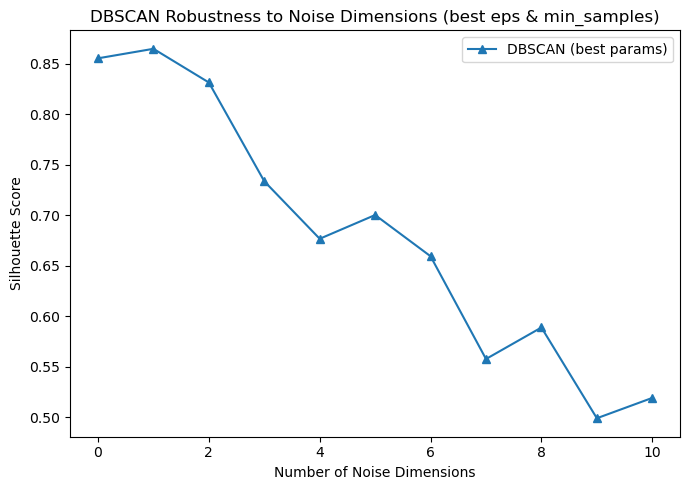

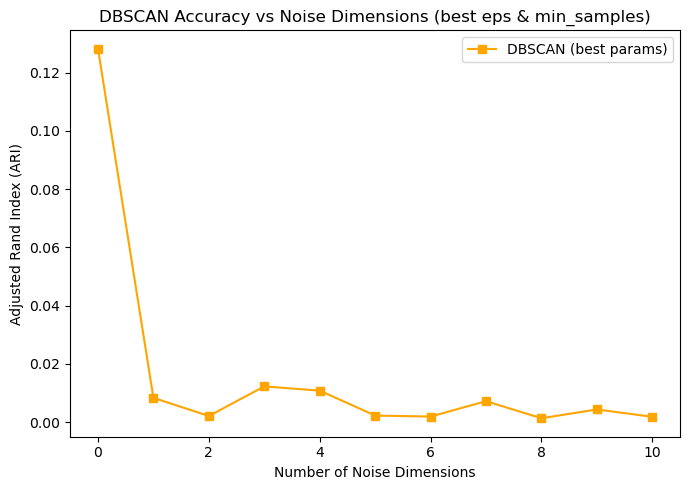

In [22]:
# Best eps and min_sample with at least more then 5 cluster
eps_range_2 = np.linspace(0.5, 3.0, 20)
min_samples_range_2 = range(5, 20)  

best_sil_scores_2 = []
best_ari_scores_2 = []
best_eps_values_2 = []
best_min_samples_values_2 = []
best_n_clusters_2 = []
best_noise_ratio_2 = []

for d in noise_dims:
    X_noisy_2 = add_noise_dims(X, d, 1.0)
    
    best_sil = -np.inf
    best_ari = np.nan
    best_eps = None
    best_min_samples = None
    best_labels = None
    best_n_clusters_curr = 0
    best_noise_ratio_curr = 1.0
    
    for eps in eps_range_2:
        for min_samples in min_samples_range_2:
            dbscan_2 = DBSCAN(eps=eps, min_samples=min_samples)
            labels_2 = dbscan_2.fit_predict(X_noisy_2)
            
            n_clusters = len(set(labels_2)) - (1 if -1 in labels_2 else 0)
            noise_ratio = (labels_2 == -1).mean()
            
            # Silhouette (exclude noise)
            # creat boolean mask to filter out the noise (-1)
            mask_2 = labels_2 != -1
            # check if more then 1 cluster as sil need at least 2 clusters
            # check if there is at least one valid point which is not noise
            if len(set(labels_2[mask_2])) > 1 and mask_2.sum() > 0:
                # if yes then compute sil score
                sil_2 = silhouette_score(X_noisy_2[mask_2], labels_2[mask_2])
                ari_2 = adjusted_rand_score(y, labels_2)  # y = true labels

                if sil_2 > best_sil and n_clusters >= 5:
                    best_sil = sil_2
                    best_ari = ari_2
                    best_eps = eps
                    best_min_samples = min_samples
                    best_labels = labels_2
                    best_n_clusters_curr = n_clusters
                    best_noise_ratio_curr = noise_ratio
    
    if best_labels is None:
        best_sil_scores_2.append(np.nan)
        best_ari_scores_2.append(np.nan)
        best_eps_values_2.append(None)
        best_min_samples_values_2.append(None)
        best_n_clusters_2.append(0)
        best_noise_ratio_2.append(1.0)
        print(f"Noise dims: {d}, no valid (eps, min_samples).")
    else:
        best_sil_scores_2.append(best_sil)
        best_ari_scores_2.append(best_ari)
        best_eps_values_2.append(best_eps)
        best_min_samples_values_2.append(best_min_samples)
        best_n_clusters_2.append(best_n_clusters_curr)
        best_noise_ratio_2.append(best_noise_ratio_curr)

        print(
            f"Noise dims: {d}, Best eps: {best_eps:.2f}, Best min_samples: {best_min_samples}, "
            f"Silhouette: {best_sil:.3f}, ARI: {best_ari:.3f}, "
            f"Clusters: {best_n_clusters_curr}, Noise ratio: {best_noise_ratio_curr:.2f}"
        )
        print(f"Unique labels at noise dim {d} (best params): {np.unique(best_labels)}")

# Plot Silhouette
x = np.array(noise_dims)
sil2 = np.array(best_sil_scores_2, dtype=float)
ari2 = np.array(best_ari_scores_2, dtype=float)

plt.figure(figsize=(7, 5))
plt.plot(x, sil2, marker='^', label='DBSCAN (best params)')
plt.xlabel("Number of Noise Dimensions")
plt.ylabel("Silhouette Score")
plt.title("DBSCAN Robustness to Noise Dimensions (best eps & min_samples)")
plt.legend(); plt.tight_layout(); plt.show()

# Plot ARI
plt.figure(figsize=(7, 5))
plt.plot(x, ari2, marker='s', label='DBSCAN (best params)', color='orange')
plt.xlabel("Number of Noise Dimensions")
plt.ylabel("Adjusted Rand Index (ARI)")
plt.title("DBSCAN Accuracy vs Noise Dimensions (best eps & min_samples)")
plt.legend(); plt.tight_layout(); plt.show()

In [23]:
n_runs = 20
random_seeds = np.random.randint(0, 10000, size=n_runs)

eps_range = np.linspace(0.5, 3.0, 20)
min_samples_range = range(5, 20)

best_sil_all, best_sil_mean, best_sil_std = [], [], []
best_ari_all, best_ari_mean, best_ari_std = [], [], []

valid_runs_list = []
avg_clusters_list = []
avg_noise_ratio_list = []

for d in noise_dims:
    run_sil_scores, run_ari_scores = [], []
    run_clusters = []
    run_noise_ratios = []
    
    valid_runs = 0
    
    for seed in random_seeds:
        X_noisy = add_noise_dims(X, d, 1.0, seed=seed)
        
        best_sil = -np.inf
        best_ari = np.nan
        best_eps = None
        best_min_samples = None
        best_labels = None
        
        for eps in eps_range:
            for min_samples in min_samples_range:
                dbscan = DBSCAN(eps=eps, min_samples=min_samples)
                labels = dbscan.fit_predict(X_noisy)
                
                # Silhouette (exclude noise)
                # creat boolean mask to filter out the noise (-1)
                mask = labels != -1
                # check if more then 1 cluster as sil need at least 2 clusters
                # check if there is at least one valid point which is not noise
                if mask.sum() > 0 and len(set(labels[mask])) > 1:
                    sil = silhouette_score(X_noisy[mask], labels[mask])
                    ari = adjusted_rand_score(y, labels)
                    
                    if sil > best_sil:
                        best_sil = sil
                        best_ari = ari
                        best_eps = eps
                        best_min_samples = min_samples
                        best_labels = labels
        
        if best_labels is not None:
            valid_runs += 1
            n_clusters = len(set(best_labels)) - (1 if -1 in best_labels else 0)
            noise_ratio = (best_labels == -1).mean()
        else:
            n_clusters = 0
            noise_ratio = 1.0
            if np.isneginf(best_sil):
                best_sil = 0.0
                best_ari = 0.0
        
        run_sil_scores.append(best_sil)
        run_ari_scores.append(best_ari)
        run_clusters.append(n_clusters)
        run_noise_ratios.append(noise_ratio)
    
    best_sil_all.append(run_sil_scores)
    best_ari_all.append(run_ari_scores)
    best_sil_mean.append(np.mean(run_sil_scores))
    best_sil_std.append(np.std(run_sil_scores))
    best_ari_mean.append(np.mean(run_ari_scores))
    best_ari_std.append(np.std(run_ari_scores))
    
    valid_runs_list.append(valid_runs)
    avg_clusters_list.append(np.mean(run_clusters))
    avg_noise_ratio_list.append(np.mean(run_noise_ratios))
    
    print(f"Noise dim {d}: valid_runs={valid_runs}, avg_clusters={np.mean(run_clusters):.2f}, "
          f"avg_noise_ratio={np.mean(run_noise_ratios):.2f}, "
          f"sil_mean={np.mean(run_sil_scores):.3f}, ari_mean={np.mean(run_ari_scores):.3f}")

Noise dim 0: valid_runs=20, avg_clusters=8.00, avg_noise_ratio=0.54, sil_mean=0.855, ari_mean=0.128
Noise dim 1: valid_runs=20, avg_clusters=2.55, avg_noise_ratio=0.96, sil_mean=0.899, ari_mean=0.003
Noise dim 2: valid_runs=20, avg_clusters=2.30, avg_noise_ratio=0.97, sil_mean=0.890, ari_mean=0.002
Noise dim 3: valid_runs=20, avg_clusters=2.45, avg_noise_ratio=0.97, sil_mean=0.844, ari_mean=0.001
Noise dim 4: valid_runs=20, avg_clusters=2.50, avg_noise_ratio=0.97, sil_mean=0.803, ari_mean=0.002
Noise dim 5: valid_runs=20, avg_clusters=2.35, avg_noise_ratio=0.97, sil_mean=0.769, ari_mean=0.001
Noise dim 6: valid_runs=20, avg_clusters=2.20, avg_noise_ratio=0.97, sil_mean=0.762, ari_mean=0.001
Noise dim 7: valid_runs=20, avg_clusters=2.35, avg_noise_ratio=0.97, sil_mean=0.712, ari_mean=0.002
Noise dim 8: valid_runs=20, avg_clusters=2.25, avg_noise_ratio=0.97, sil_mean=0.690, ari_mean=0.002
Noise dim 9: valid_runs=20, avg_clusters=2.10, avg_noise_ratio=0.98, sil_mean=0.671, ari_mean=0.001


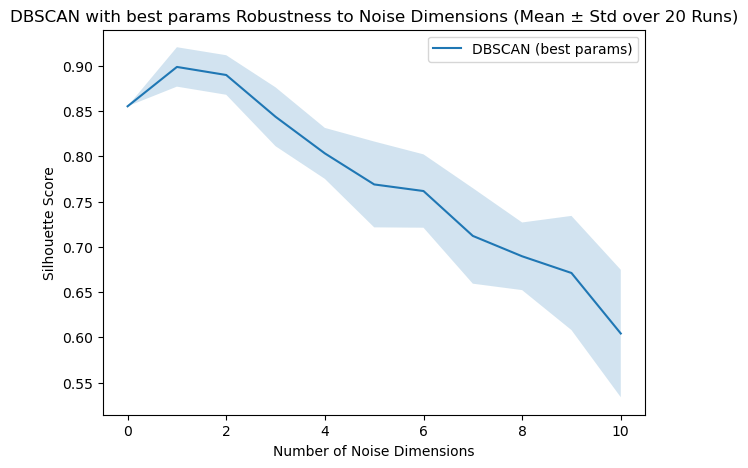

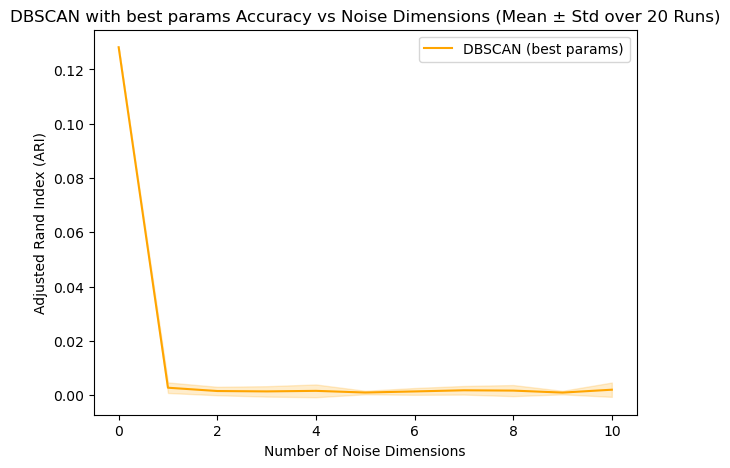

In [24]:
# Plot Silhouette
plt.figure(figsize=(7, 5))
plt.plot(noise_dims, best_sil_mean, label='DBSCAN (best params)')
plt.title('DBSCAN with best params Robustness to Noise Dimensions (Mean ± Std over 20 Runs)')
plt.fill_between(noise_dims,
                 np.array(best_sil_mean) - np.array(best_sil_std),
                 np.array(best_sil_mean) + np.array(best_sil_std),
                 alpha=0.2)
plt.xlabel("Number of Noise Dimensions")
plt.ylabel("Silhouette Score")
plt.legend()
plt.show()

# Plot ARI 
plt.figure(figsize=(7, 5))
plt.plot(noise_dims, best_ari_mean, label='DBSCAN (best params)', color='orange')
plt.title('DBSCAN with best params Accuracy vs Noise Dimensions (Mean ± Std over 20 Runs)')
plt.fill_between(noise_dims,
                 np.array(best_ari_mean) - np.array(best_ari_std),
                 np.array(best_ari_mean) + np.array(best_ari_std),
                 alpha=0.2, color='orange')
plt.xlabel("Number of Noise Dimensions")
plt.ylabel("Adjusted Rand Index (ARI)")
plt.legend()
plt.show()

# Agglomerative

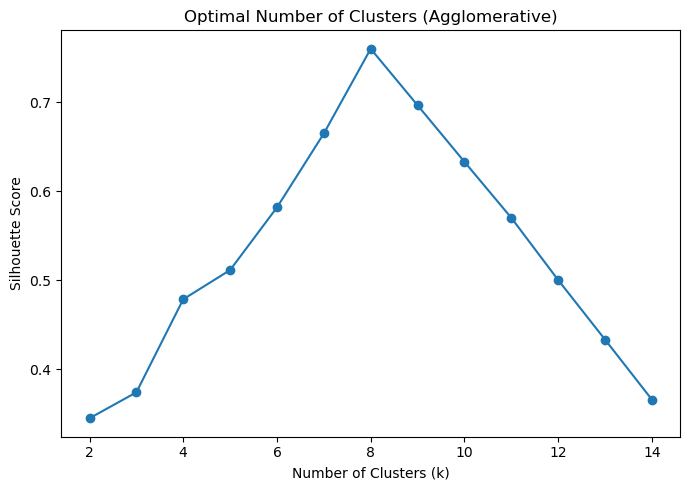

In [25]:
range_k = range(2, 15)
agglo_sil_scores_by_k = [] 
Z = linkage(X, method='ward')

for k in range_k:
    labels = fcluster(Z, t=k, criterion='maxclust')
    sil = silhouette_score(X, labels)
    agglo_sil_scores_by_k.append(sil)

# Plot silhouette scores
plt.figure(figsize=(7, 5))
plt.plot(range_k, agglo_sil_scores_by_k, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Optimal Number of Clusters (Agglomerative)')
plt.tight_layout()
plt.show()

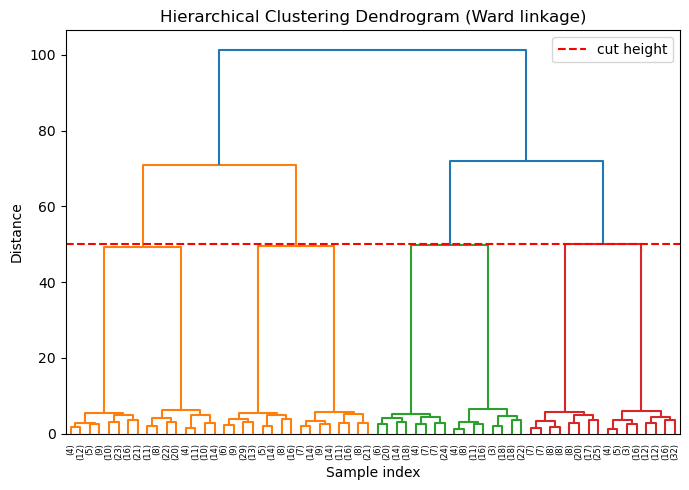

In [26]:
# linkage matrix
Z = linkage(X, method='ward')

# dendrogram
plt.figure(figsize=(7, 5))
dendrogram(Z, truncate_mode='level', p=5)
plt.axhline(y=50, color='r', linestyle='--', label='cut height')
plt.title('Hierarchical Clustering Dendrogram (Ward linkage)')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.legend()
plt.tight_layout()
plt.show()


Running Agglomerative Clustering with linkage = 'ward'
Noise dims: 0, Silhouette: 0.760, ARI: 1.000
Noise dims: 1, Silhouette: 0.651, ARI: 1.000
Noise dims: 2, Silhouette: 0.571, ARI: 1.000
Noise dims: 3, Silhouette: 0.510, ARI: 1.000
Noise dims: 4, Silhouette: 0.461, ARI: 1.000
Noise dims: 5, Silhouette: 0.423, ARI: 1.000
Noise dims: 6, Silhouette: 0.389, ARI: 1.000
Noise dims: 7, Silhouette: 0.364, ARI: 1.000
Noise dims: 8, Silhouette: 0.337, ARI: 1.000
Noise dims: 9, Silhouette: 0.316, ARI: 1.000
Noise dims: 10, Silhouette: 0.299, ARI: 1.000


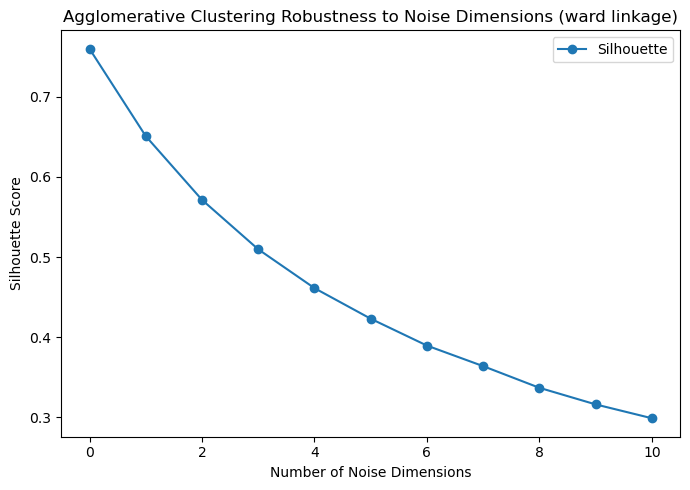

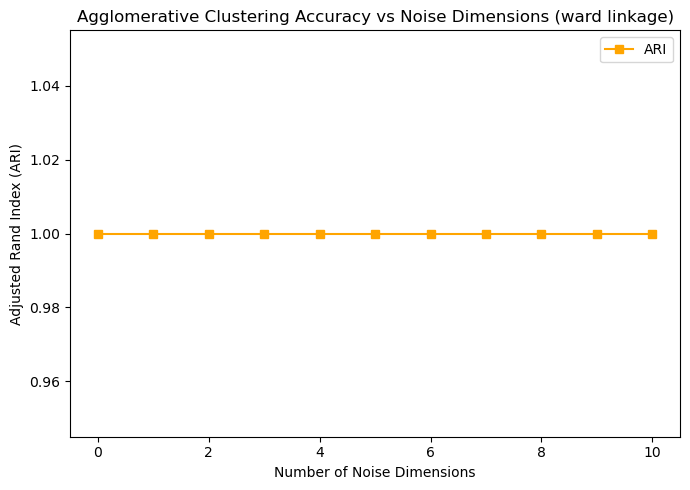


Running Agglomerative Clustering with linkage = 'average'
Noise dims: 0, Silhouette: 0.760, ARI: 1.000
Noise dims: 1, Silhouette: 0.651, ARI: 1.000
Noise dims: 2, Silhouette: 0.571, ARI: 1.000
Noise dims: 3, Silhouette: 0.510, ARI: 1.000
Noise dims: 4, Silhouette: 0.461, ARI: 1.000
Noise dims: 5, Silhouette: 0.423, ARI: 1.000
Noise dims: 6, Silhouette: 0.389, ARI: 1.000
Noise dims: 7, Silhouette: 0.364, ARI: 1.000
Noise dims: 8, Silhouette: 0.337, ARI: 1.000
Noise dims: 9, Silhouette: 0.279, ARI: 0.870
Noise dims: 10, Silhouette: 0.298, ARI: 0.997


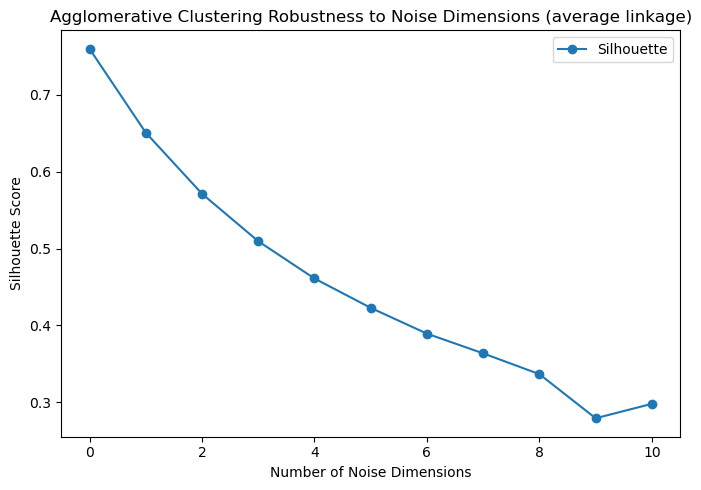

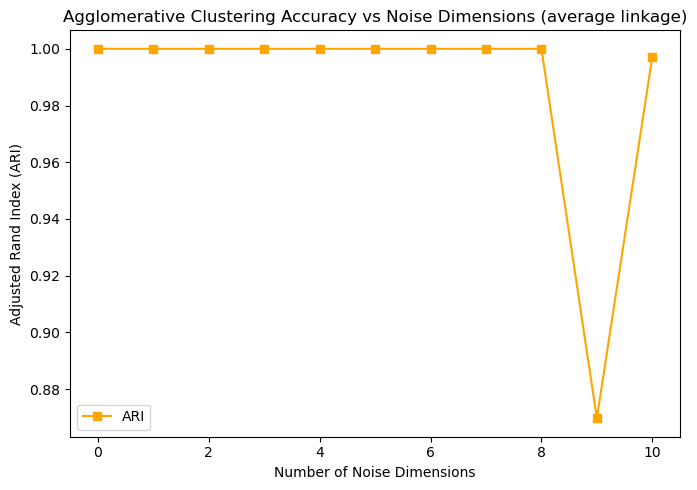


Running Agglomerative Clustering with linkage = 'complete'
Noise dims: 0, Silhouette: 0.760, ARI: 1.000
Noise dims: 1, Silhouette: 0.651, ARI: 1.000
Noise dims: 2, Silhouette: 0.571, ARI: 1.000
Noise dims: 3, Silhouette: 0.510, ARI: 1.000
Noise dims: 4, Silhouette: 0.461, ARI: 1.000
Noise dims: 5, Silhouette: 0.423, ARI: 1.000
Noise dims: 6, Silhouette: 0.389, ARI: 1.000
Noise dims: 7, Silhouette: 0.364, ARI: 1.000
Noise dims: 8, Silhouette: 0.337, ARI: 1.000
Noise dims: 9, Silhouette: 0.278, ARI: 0.870
Noise dims: 10, Silhouette: 0.299, ARI: 1.000


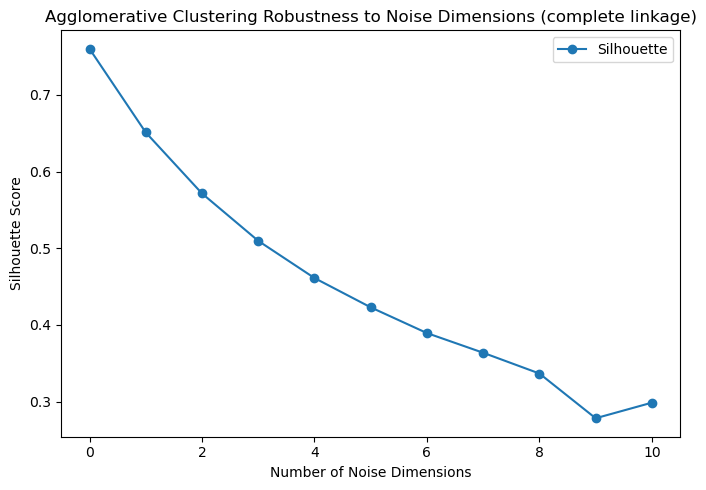

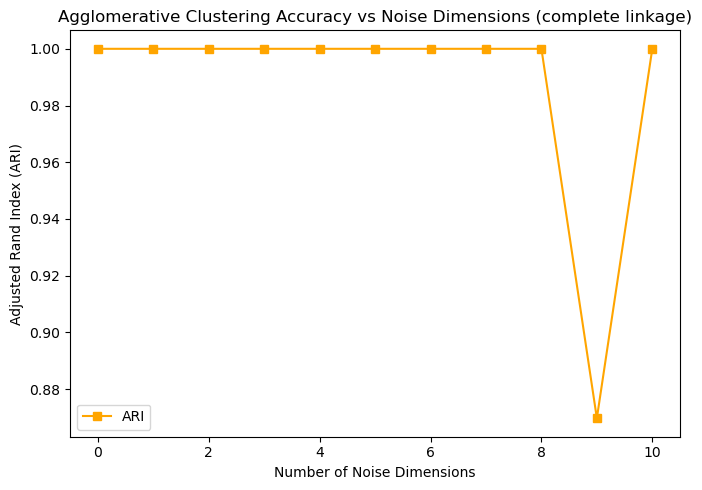


Running Agglomerative Clustering with linkage = 'single'
Noise dims: 0, Silhouette: 0.760, ARI: 1.000
Noise dims: 1, Silhouette: 0.651, ARI: 1.000
Noise dims: 2, Silhouette: 0.571, ARI: 1.000
Noise dims: 3, Silhouette: 0.510, ARI: 1.000
Noise dims: 4, Silhouette: 0.392, ARI: 0.869
Noise dims: 5, Silhouette: 0.290, ARI: 0.761
Noise dims: 6, Silhouette: 0.259, ARI: 0.761
Noise dims: 7, Silhouette: 0.124, ARI: 0.472
Noise dims: 8, Silhouette: -0.011, ARI: 0.177
Noise dims: 9, Silhouette: -0.067, ARI: 0.157
Noise dims: 10, Silhouette: -0.155, ARI: -0.000


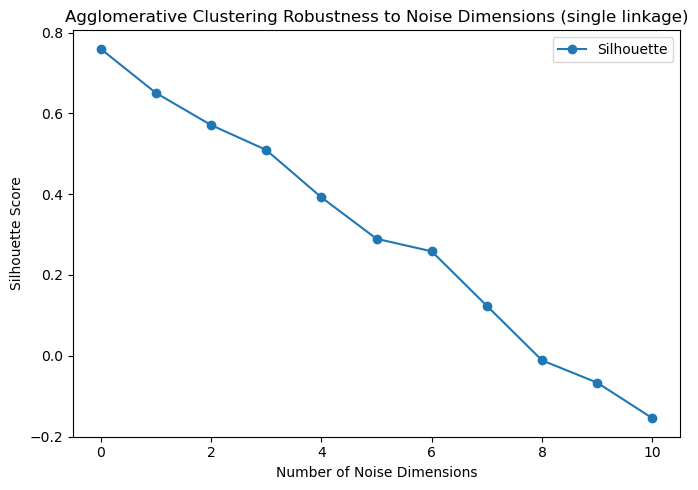

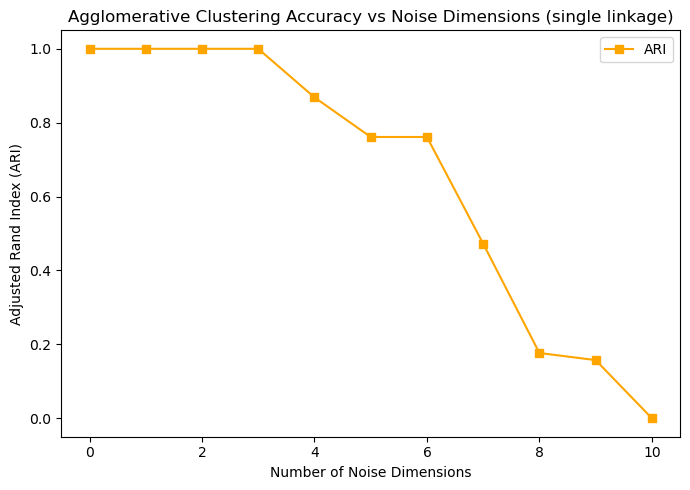

In [27]:
# use diffrent type of linkage
linkages = ['ward', 'average', 'complete', 'single']
agglo_scores_by_linkage_sil = {}  
agglo_scores_by_linkage_ari = {}  

for link in linkages:
    agglo_sil_scores = []
    agglo_ari_scores = []

    print(f"\nRunning Agglomerative Clustering with linkage = '{link}'")
    
    for d in noise_dims:
        X_noisy = add_noise_dims(X, d, 1.0)
        
        if link == 'ward':
            model = AgglomerativeClustering(n_clusters=8, linkage=link)
        else:
            model = AgglomerativeClustering(n_clusters=8, linkage=link, metric='euclidean')
        
        labels = model.fit_predict(X_noisy)
        
        sil = silhouette_score(X_noisy, labels)
        ari = adjusted_rand_score(y, labels)  # y = true labels
        
        agglo_sil_scores.append(sil)
        agglo_ari_scores.append(ari)
        
        print(f"Noise dims: {d}, Silhouette: {sil:.3f}, ARI: {ari:.3f}")
    
    agglo_scores_by_linkage_sil[link] = agglo_sil_scores
    agglo_scores_by_linkage_ari[link] = agglo_ari_scores  

    # Plot Silhouette 
    plt.figure(figsize=(7, 5))
    plt.plot(noise_dims, agglo_sil_scores, marker='o', label="Silhouette")
    plt.title(f'Agglomerative Clustering Robustness to Noise Dimensions ({link} linkage)')
    plt.xlabel('Number of Noise Dimensions')
    plt.ylabel('Silhouette Score')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot ARI
    plt.figure(figsize=(7, 5))
    plt.plot(noise_dims, agglo_ari_scores, marker='s', label="ARI", color='orange')
    plt.title(f'Agglomerative Clustering Accuracy vs Noise Dimensions ({link} linkage)')
    plt.xlabel('Number of Noise Dimensions')
    plt.ylabel('Adjusted Rand Index (ARI)')
    plt.legend()
    plt.tight_layout()
    plt.show()

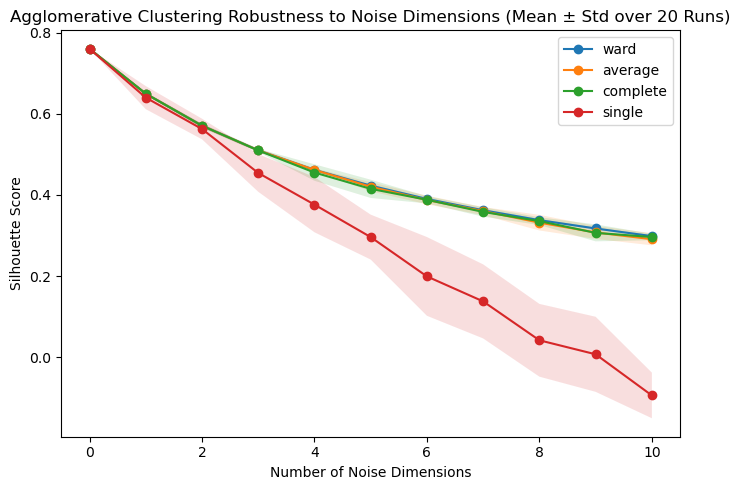

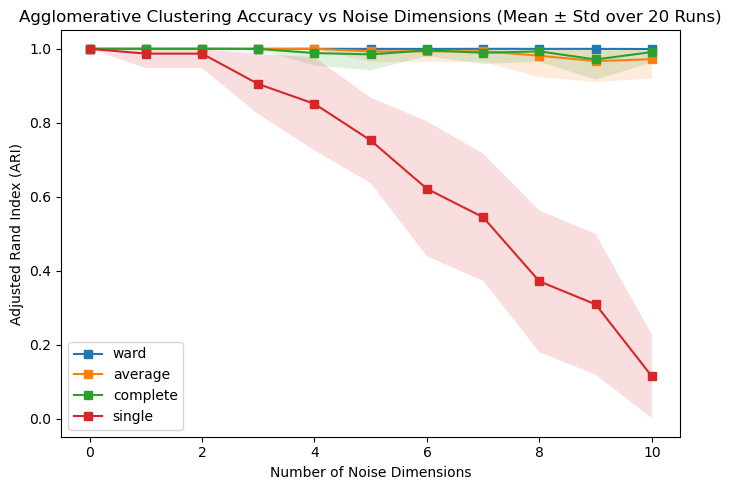

In [28]:
n_runs = 20
random_seeds = np.random.randint(0, 10000, size=n_runs)

linkages = ['ward', 'average', 'complete', 'single']

# Store results separately for Silhouette and ARI
agglo_scores_by_linkage_sil_multi = {}  
agglo_all_scores_by_linkage_sil_multi = {} 
agglo_scores_by_linkage_ari_multi = {}  
agglo_all_scores_by_linkage_ari_multi = {} 

for link in linkages:
    mean_scores_sil = []
    std_scores_sil = []
    all_scores_sil = []
    
    mean_scores_ari = []
    std_scores_ari = []
    all_scores_ari = []
    
    for d in noise_dims:
        scores_sil_1 = []
        scores_ari_1 = []
        
        for seed in random_seeds:
            X_noisy = add_noise_dims(X, d, 1.0, seed=seed)
            
            if link == 'ward':
                model = AgglomerativeClustering(n_clusters=8, linkage=link)
            else:
                model = AgglomerativeClustering(n_clusters=8, linkage=link, metric='euclidean')
            
            labels = model.fit_predict(X_noisy)
            
            sil = silhouette_score(X_noisy, labels)
            ari = adjusted_rand_score(y, labels)  # y = true labels
            
            scores_sil_1.append(sil)
            scores_ari_1.append(ari)
        
        all_scores_sil.append(scores_sil_1)
        mean_scores_sil.append(np.mean(scores_sil_1))
        std_scores_sil.append(np.std(scores_sil_1))
        
        all_scores_ari.append(scores_ari_1)
        mean_scores_ari.append(np.mean(scores_ari_1))
        std_scores_ari.append(np.std(scores_ari_1))
    
    # Save for this linkage
    agglo_scores_by_linkage_sil_multi[link] = (mean_scores_sil, std_scores_sil)
    agglo_all_scores_by_linkage_sil_multi[link] = all_scores_sil
    
    agglo_scores_by_linkage_ari_multi[link] = (mean_scores_ari, std_scores_ari)
    agglo_all_scores_by_linkage_ari_multi[link] = all_scores_ari

# Plot Silhouette
plt.figure(figsize=(7, 5))
for link in linkages:
    means, stds = agglo_scores_by_linkage_sil_multi[link]
    means = np.array(means, dtype=float)
    stds  = np.array(stds, dtype=float)
    plt.plot(noise_dims, means, marker='o', label=f'{link}')
    plt.fill_between(noise_dims, means-stds, means+stds, alpha=0.15)
plt.title(f'Agglomerative Clustering Robustness to Noise Dimensions (Mean ± Std over 20 Runs)')
plt.xlabel('Number of Noise Dimensions')
plt.ylabel('Silhouette Score')
plt.legend()
plt.tight_layout()
plt.show()

# Plot ARI mean 
plt.figure(figsize=(7, 5))
for link in linkages:
    means, stds = agglo_scores_by_linkage_ari_multi[link]
    means = np.array(means, dtype=float)
    stds  = np.array(stds, dtype=float)
    
    # Clip upper and lower bounds to valid ARI range
    upper = np.minimum(means + stds, 1.0)
    lower = np.maximum(means - stds, 0.0)
    
    plt.plot(noise_dims, means, marker='s', label=f'{link}')
    plt.fill_between(noise_dims, lower, upper, alpha=0.15)
    
plt.title('Agglomerative Clustering Accuracy vs Noise Dimensions (Mean ± Std over 20 Runs)')
plt.xlabel('Number of Noise Dimensions')
plt.ylabel('Adjusted Rand Index (ARI)')
plt.legend()
plt.tight_layout()
plt.show()


# GMM

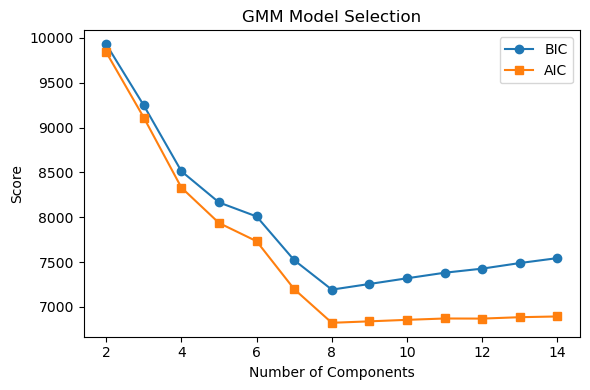

In [29]:
bic_scores = []
aic_scores = []
n_components_range = range(2, 15)

for k in n_components_range:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(X)
    bic_scores.append(gmm.bic(X))
    aic_scores.append(gmm.aic(X))

plt.figure(figsize=(6, 4))
plt.plot(n_components_range, bic_scores, marker='o', label='BIC')
plt.plot(n_components_range, aic_scores, marker='s', label='AIC')
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.title('GMM Model Selection')
plt.legend()
plt.tight_layout()
plt.show()

Noise dims: 0, GMM Silhouette Score: 0.760, ARI: 1.000
Noise dims: 1, GMM Silhouette Score: 0.651, ARI: 1.000
Noise dims: 2, GMM Silhouette Score: 0.571, ARI: 1.000
Noise dims: 3, GMM Silhouette Score: 0.510, ARI: 1.000
Noise dims: 4, GMM Silhouette Score: 0.461, ARI: 1.000
Noise dims: 5, GMM Silhouette Score: 0.423, ARI: 1.000
Noise dims: 6, GMM Silhouette Score: 0.389, ARI: 1.000
Noise dims: 7, GMM Silhouette Score: 0.284, ARI: 0.834
Noise dims: 8, GMM Silhouette Score: 0.337, ARI: 1.000
Noise dims: 9, GMM Silhouette Score: 0.316, ARI: 1.000
Noise dims: 10, GMM Silhouette Score: 0.299, ARI: 1.000


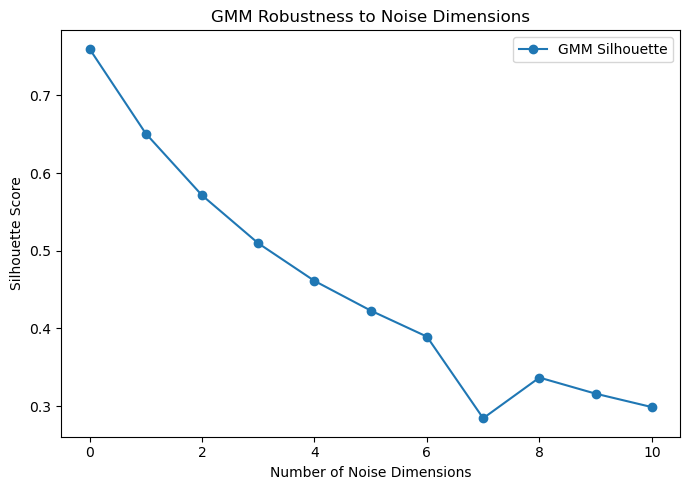

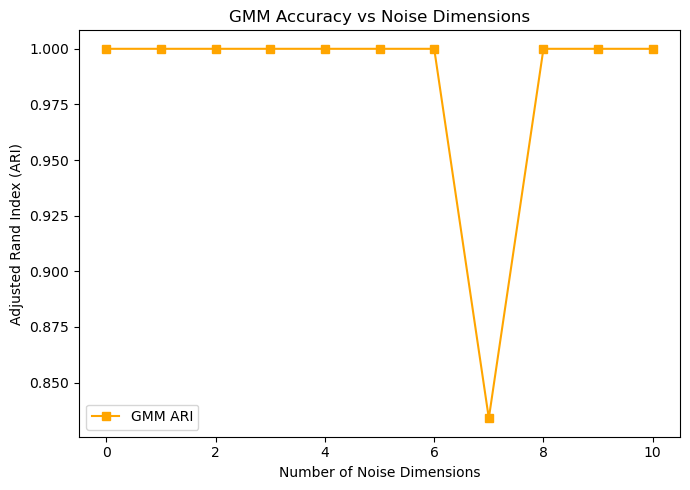

In [30]:
gmm_sil_scores_single = []
gmm_ari_scores_single = []

for d in noise_dims:
    X_noisy = add_noise_dims(X, d, 1.0)
    
    gmm = GaussianMixture(n_components=8, covariance_type='full', random_state=42)
    labels = gmm.fit_predict(X_noisy)
    
    sil = silhouette_score(X_noisy, labels)
    # y = true labels
    ari = adjusted_rand_score(y, labels)
    
    gmm_sil_scores_single.append(sil)
    gmm_ari_scores_single.append(ari)
    
    print(f"Noise dims: {d}, GMM Silhouette Score: {sil:.3f}, ARI: {ari:.3f}")

# Plot Silhouette
plt.figure(figsize=(7, 5))
plt.plot(noise_dims, gmm_sil_scores_single, marker='o', label='GMM Silhouette')
plt.xlabel('Number of Noise Dimensions')
plt.ylabel('Silhouette Score')
plt.title('GMM Robustness to Noise Dimensions')
plt.legend()
plt.tight_layout()
plt.show()

# Plot ARI
plt.figure(figsize=(7, 5))
plt.plot(noise_dims, gmm_ari_scores_single, marker='s', label='GMM ARI', color='orange')
plt.xlabel('Number of Noise Dimensions')
plt.ylabel('Adjusted Rand Index (ARI)')
plt.title('GMM Accuracy vs Noise Dimensions')
plt.legend()
plt.tight_layout()
plt.show()

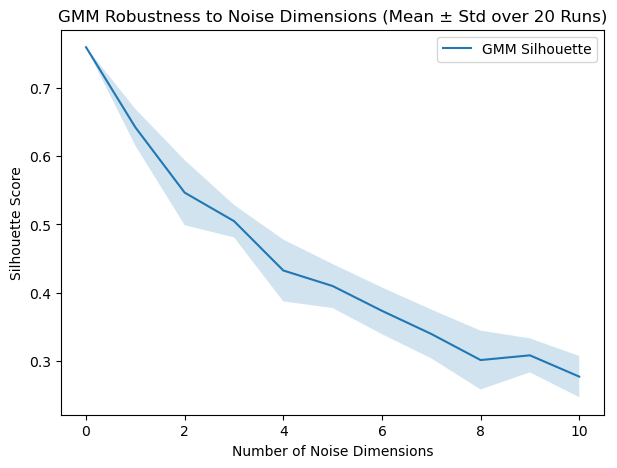

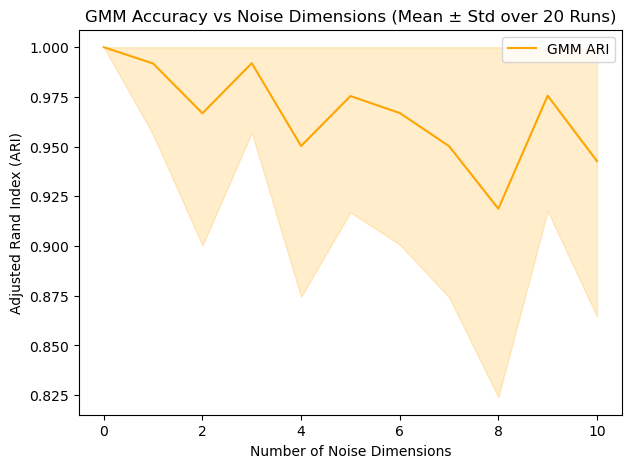

In [31]:
n_runs = 20
random_seeds = np.random.randint(0, 10000, size=n_runs)

# Silhouette storage
gmm_means_sil = []
gmm_stds_sil = []
gmm_all_scores_sil = []

# ARI storage
gmm_means_ari = []
gmm_stds_ari = []
gmm_all_scores_ari = []

for d in noise_dims:
    gmm_sil_scores1 = []
    gmm_ari_scores1 = []
    
    for seed in random_seeds:
        X_noisy = add_noise_dims(X, d, 1.0, seed=seed)
        
        gmm = GaussianMixture(n_components=8, random_state=seed)
        labels = gmm.fit_predict(X_noisy)
        
        sil = silhouette_score(X_noisy, labels)
        ari = adjusted_rand_score(y, labels)  # y = true labels
        
        gmm_sil_scores1.append(sil)
        gmm_ari_scores1.append(ari)
    
    # Store Silhouette
    gmm_all_scores_sil.append(gmm_sil_scores1)
    gmm_means_sil.append(np.mean(gmm_sil_scores1))
    gmm_stds_sil.append(np.std(gmm_sil_scores1))
    
    # Store ARI
    gmm_all_scores_ari.append(gmm_ari_scores1)
    gmm_means_ari.append(np.mean(gmm_ari_scores1))
    gmm_stds_ari.append(np.std(gmm_ari_scores1))

# Plot GMM Silhouette
plt.figure(figsize=(7, 5))
plt.plot(noise_dims, gmm_means_sil, label='GMM Silhouette')
plt.title('GMM Robustness to Noise Dimensions (Mean ± Std over 20 Runs)')
plt.fill_between(noise_dims,
                 np.array(gmm_means_sil) - np.array(gmm_stds_sil),
                 np.array(gmm_means_sil) + np.array(gmm_stds_sil),
                 alpha=0.2)
plt.xlabel("Number of Noise Dimensions")
plt.ylabel("Silhouette Score")
plt.legend()
plt.show()

# Plot GMM ARI 
plt.figure(figsize=(7, 5))
plt.plot(noise_dims, gmm_means_ari, label='GMM ARI', color='orange')

upper = np.minimum(np.array(gmm_means_ari) + np.array(gmm_stds_ari), 1.0)
lower = np.maximum(np.array(gmm_means_ari) - np.array(gmm_stds_ari), 0.0)

plt.title('GMM Accuracy vs Noise Dimensions (Mean ± Std over 20 Runs)')
plt.fill_between(noise_dims, lower, upper, alpha=0.2, color='orange')
plt.xlabel("Number of Noise Dimensions")
plt.ylabel("Adjusted Rand Index (ARI)")
plt.legend()
plt.show()



# Compare Clustering Method

### One run Sil Score

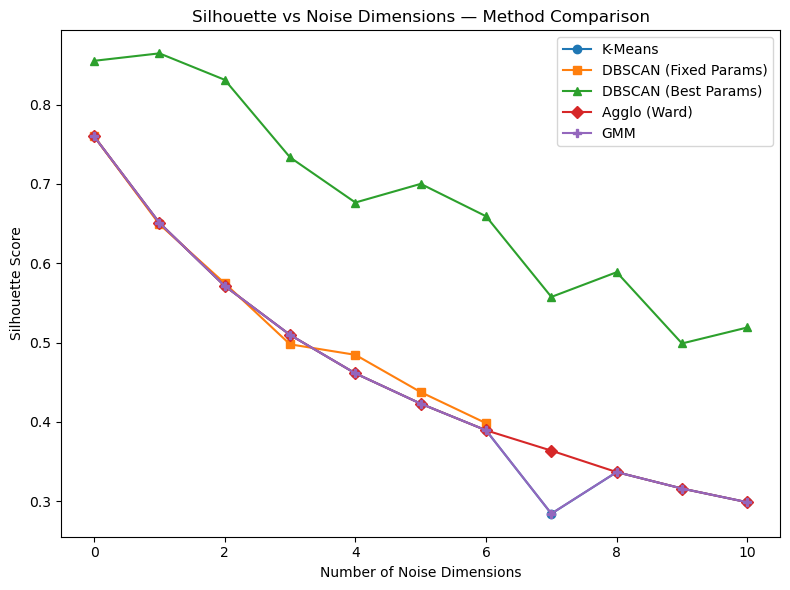

In [32]:
plt.figure(figsize=(8, 6))

# K-Means
plt.plot(noise_dims, kmeans_sil_scores_single, marker='o', label='K-Means')

# DBSCAN (fixed params)
plt.plot(noise_dims_dbscan, dbscan_sil_scores, marker='s', label='DBSCAN (Fixed Params)')

# DBSCAN (best params)
plt.plot(x, sil2, marker='^', label='DBSCAN (Best Params)')

# Agglomerative (ward)
plt.plot(noise_dims, agglo_scores_by_linkage_sil['ward'], marker='D', label="Agglo (Ward)")

# GMM
plt.plot(noise_dims, gmm_sil_scores_single, marker='P', label='GMM')

plt.title('Silhouette vs Noise Dimensions — Method Comparison')
plt.xlabel('Number of Noise Dimensions')
plt.ylabel('Silhouette Score')
plt.legend()
plt.tight_layout()
plt.show()

### One run ARI Score

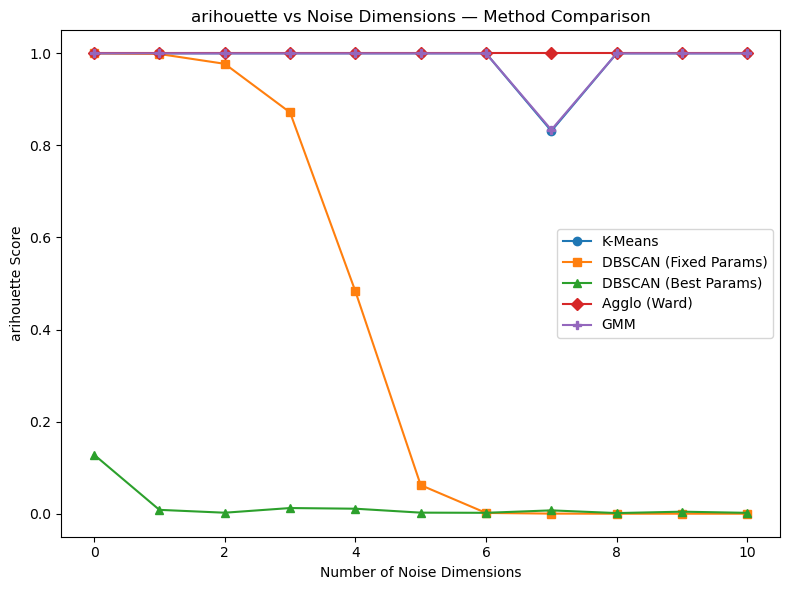

In [33]:
plt.figure(figsize=(8, 6))

# K-Means
plt.plot(noise_dims, kmeans_ari_scores_single, marker='o', label='K-Means')

# DBSCAN (fixed params)
plt.plot(noise_dims_dbscan, dbscan_ari_scores, marker='s', label='DBSCAN (Fixed Params)')

# DBSCAN (best params)
plt.plot(x, ari2, marker='^', label='DBSCAN (Best Params)')

# Agglomerative (ward)
plt.plot(noise_dims, agglo_scores_by_linkage_ari['ward'], marker='D', label="Agglo (Ward)")

# GMM
plt.plot(noise_dims, gmm_ari_scores_single, marker='P', label='GMM')

plt.title('arihouette vs Noise Dimensions — Method Comparison')
plt.xlabel('Number of Noise Dimensions')
plt.ylabel('arihouette Score')
plt.legend()
plt.tight_layout()
plt.show()

## SIL 20 RUN 

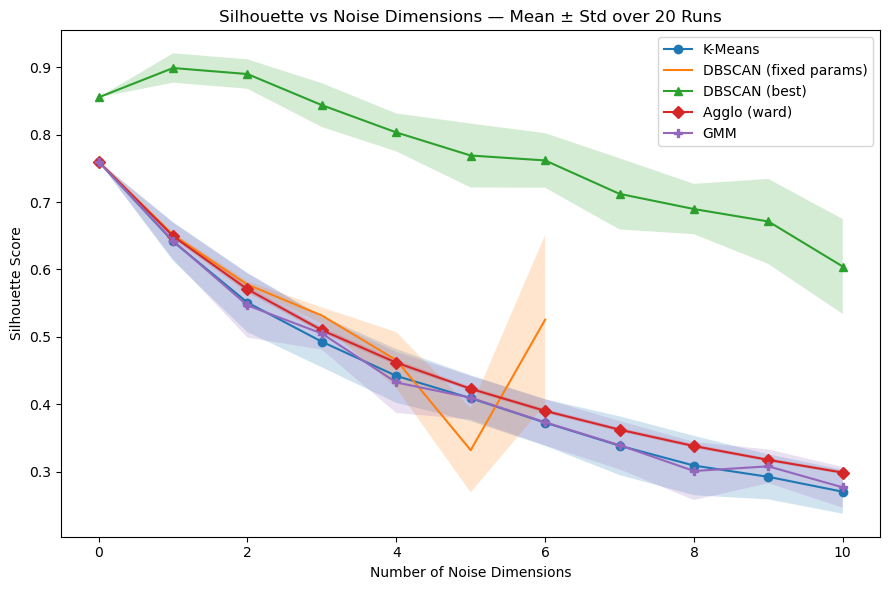

In [39]:
# Sil score
plt.figure(figsize=(9, 6))

# Kmeans
km_mean = np.array(kmeans_sil_means, dtype=float)
km_std  = np.array(kmeans_sil_stds, dtype=float)
plt.plot(noise_dims, km_mean, marker='o', label='K-Means')
plt.fill_between(noise_dims,
                 np.clip(km_mean - km_std, -1, 1),
                 np.clip(km_mean + km_std, -1, 1),
                 alpha=0.2)

# DBSCAN (fixed params)
plt.plot(noise_dims_arr, sil_means_plot, label='DBSCAN (fixed params)')

# Only fill where fully valid (avoids filling across NaNs)
plt.fill_between(noise_dims_arr[band_mask],
                 sil_means_arr[band_mask] - sil_stds_arr[band_mask],
                 sil_means_arr[band_mask] + sil_stds_arr[band_mask],
                 alpha=0.2)

# DBSCAN (best params)
bs_mean = np.array(best_sil_mean, dtype=float)
bs_std  = np.array(best_sil_std, dtype=float)
plt.plot(noise_dims, bs_mean, marker='^', label='DBSCAN (best)')
plt.fill_between(noise_dims,
                 np.clip(bs_mean - bs_std, -1, 1),
                 np.clip(bs_mean + bs_std, -1, 1),
                 alpha=0.2)

# Agglomerative (ward)
ward_means, ward_stds = agglo_scores_by_linkage_sil_multi['ward']
ward_means = np.array(ward_means, dtype=float)
ward_stds  = np.array(ward_stds, dtype=float)
plt.plot(noise_dims, ward_means, marker='D', label='Agglo (ward)')
plt.fill_between(noise_dims,
                 np.clip(ward_means - ward_stds, -1, 1),
                 np.clip(ward_means + ward_stds, -1, 1),
                 alpha=0.2)

# GMM 
gmm_mean = np.array(gmm_means_sil, dtype=float)
gmm_std  = np.array(gmm_stds_sil, dtype=float)
plt.plot(noise_dims, gmm_mean, marker='P', label='GMM')
plt.fill_between(noise_dims,
                 np.clip(gmm_mean - gmm_std, -1, 1),
                 np.clip(gmm_mean + gmm_std, -1, 1),
                 alpha=0.2)

plt.title('Silhouette vs Noise Dimensions — Mean ± Std over 20 Runs')
plt.xlabel('Number of Noise Dimensions')
plt.ylabel('Silhouette Score')
plt.legend()
plt.tight_layout()
plt.show()


## ARI 20 RUN 

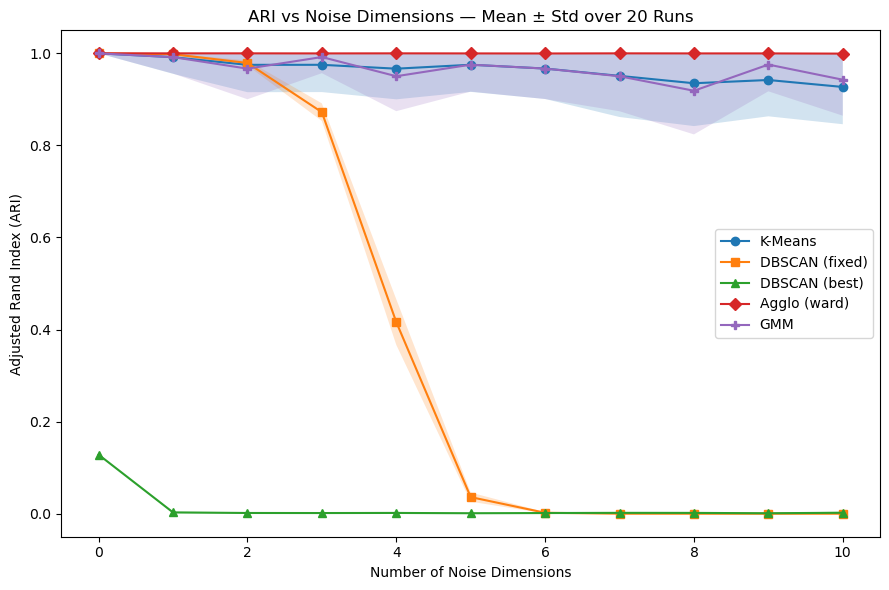

In [35]:
plt.figure(figsize=(9, 6))

# Kmeans
km_mean = np.array(kmeans_ari_means, dtype=float)
km_std  = np.array(kmeans_ari_stds, dtype=float)
upper = np.minimum(km_mean + km_std, 1.0)
lower = np.maximum(km_mean - km_std, 0.0)
plt.plot(noise_dims, km_mean, marker='o', label='K-Means')
plt.fill_between(noise_dims, lower, upper, alpha=0.2)

# DBSCAN (fixed params)
ari_means_arr = np.array(ari_means_arr, dtype=float)
ari_stds_arr  = np.array(ari_stds_arr, dtype=float)
band_mask = ~np.isnan(ari_means_arr)
upper = np.minimum((ari_means_arr + ari_stds_arr)[band_mask], 1.0)
lower = np.maximum((ari_means_arr - ari_stds_arr)[band_mask], 0.0)
plt.plot(noise_dims_arr, ari_means_arr, marker='s', label='DBSCAN (fixed)')
plt.fill_between(noise_dims_arr[band_mask], lower, upper, alpha=0.2)

# DBSCAN (best params)
bs_mean = np.array(best_ari_mean, dtype=float)
bs_std  = np.array(best_ari_std, dtype=float)
upper = np.minimum(bs_mean + bs_std, 1.0)
lower = np.maximum(bs_mean - bs_std, 0.0)
plt.plot(noise_dims, bs_mean, marker='^', label='DBSCAN (best)')
plt.fill_between(noise_dims, lower, upper, alpha=0.2)

# Agglomerative (ward)
ward_means, ward_stds = agglo_scores_by_linkage_ari_multi['ward']
ward_means = np.array(ward_means, dtype=float)
ward_stds  = np.array(ward_stds, dtype=float)
upper = np.minimum(ward_means + ward_stds, 1.0)
lower = np.maximum(ward_means - ward_stds, 0.0)
plt.plot(noise_dims, ward_means, marker='D', label='Agglo (ward)')
plt.fill_between(noise_dims, lower, upper, alpha=0.2)

# GMM
gmm_mean = np.array(gmm_means_ari, dtype=float)
gmm_std  = np.array(gmm_stds_ari, dtype=float)
upper = np.minimum(gmm_mean + gmm_std, 1.0)
lower = np.maximum(gmm_mean - gmm_std, 0.0)
plt.plot(noise_dims, gmm_mean, marker='P', label='GMM')
plt.fill_between(noise_dims, lower, upper, alpha=0.2)

plt.title('ARI vs Noise Dimensions — Mean ± Std over 20 Runs')
plt.xlabel('Number of Noise Dimensions')
plt.ylabel('Adjusted Rand Index (ARI)')
plt.legend()
plt.tight_layout()
plt.show()

# Experiment with diff noise std

In [40]:
def add_within_dim_noise(X, noise_std, seed=42):
    rng = np.random.default_rng(seed)
    noise = rng.normal(0, noise_std, size=X.shape)
    return X + noise

In [41]:
# Simple 3D dataset
X_simple_3d = np.array([
    [0, 0, 0],
    [0, 0, 5],
    [0, 5, 0],
    [0, 5, 5],
    [5, 0, 0],
    [5, 0, 5],
    [5, 5, 0],
    [5, 5, 5]
])

# Try different noise standard deviations
for noise_std in [0.0, 0.5, 1.0, 2.0]:
    X_noisy = add_within_dim_noise(X_simple_3d, noise_std)
    print(f"\nNoise std: {noise_std}, Shape: {X_noisy.shape}")
    print(X_noisy)


Noise std: 0.0, Shape: (8, 3)
[[0. 0. 0.]
 [0. 0. 5.]
 [0. 5. 0.]
 [0. 5. 5.]
 [5. 0. 0.]
 [5. 0. 5.]
 [5. 5. 0.]
 [5. 5. 5.]]

Noise std: 0.5, Shape: (8, 3)
[[ 0.15235854 -0.51999205  0.3752256 ]
 [ 0.47028236 -0.97551759  4.34891025]
 [ 0.0639202   4.8418787  -0.00840058]
 [-0.42652196  5.43969899  5.38889597]
 [ 5.03301535  0.5636206   0.23375467]
 [ 4.57035377  0.18437539  4.5205587 ]
 [ 5.43922515  4.97503704 -0.09243118]
 [ 4.65953523  5.61127067  4.92273526]]

Noise std: 1.0, Shape: (8, 3)
[[ 0.30471708 -1.03998411  0.7504512 ]
 [ 0.94056472 -1.95103519  3.69782049]
 [ 0.1278404   4.68375741 -0.01680116]
 [-0.85304393  5.87939797  5.77779194]
 [ 5.0660307   1.12724121  0.46750934]
 [ 4.14070754  0.36875078  4.0411174 ]
 [ 5.8784503   4.95007409 -0.18486236]
 [ 4.31907046  6.22254134  4.84547052]]

Noise std: 2.0, Shape: (8, 3)
[[ 0.60943416 -2.07996821  1.50090239]
 [ 1.88112943 -3.90207038  2.39564099]
 [ 0.25568081  4.36751482 -0.03360232]
 [-1.70608786  6.75879595  6.5555838

## K-Means

KMeans | Within noise std: 0.0, Silhouette Score: 0.760, ARI: 1.000
KMeans | Within noise std: 0.05, Silhouette Score: 0.759, ARI: 1.000
KMeans | Within noise std: 0.1, Silhouette Score: 0.756, ARI: 1.000
KMeans | Within noise std: 0.2, Silhouette Score: 0.741, ARI: 1.000
KMeans | Within noise std: 0.5, Silhouette Score: 0.651, ARI: 1.000
KMeans | Within noise std: 0.8, Silhouette Score: 0.527, ARI: 0.966
KMeans | Within noise std: 1.0, Silhouette Score: 0.450, ARI: 0.917
KMeans | Within noise std: 2.0, Silhouette Score: 0.264, ARI: 0.416
KMeans | Within noise std: 3.0, Silhouette Score: 0.241, ARI: 0.187


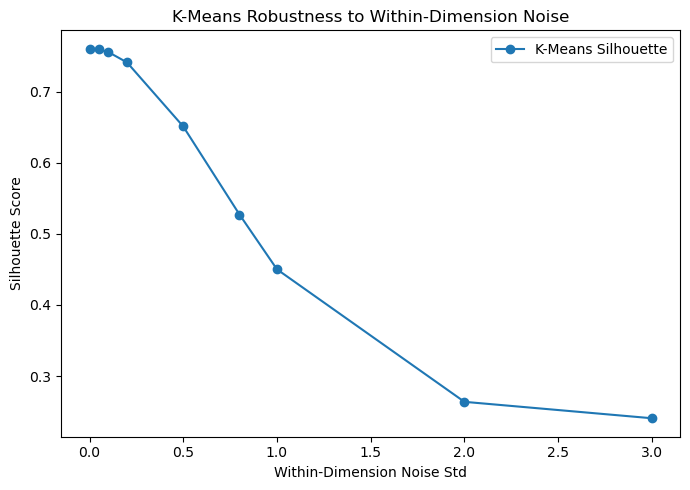

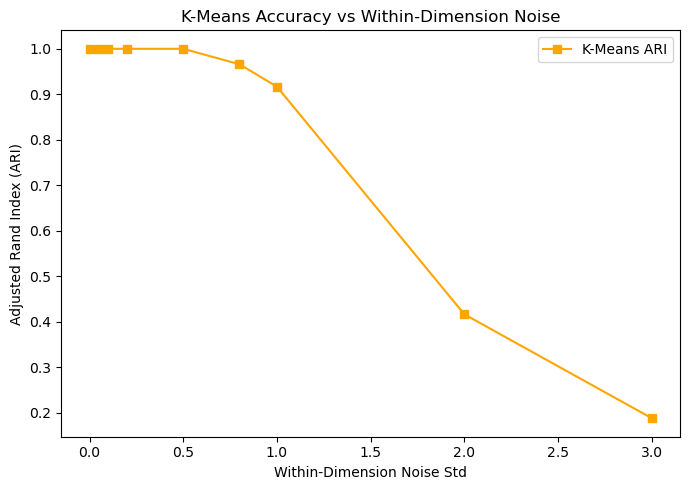

In [42]:
# Store the Silhouette and ARI scores 
kmeans_sil_scores_within = []
kmeans_ari_scores_within = []

# Noise standard deviations to test (within-dimension noise)
noise_stds = [0.0, 0.05, 0.1, 0.2, 0.5, 0.8, 1.0, 2.0, 3.0]

# Add within-dimension noise to the cluster
for std in noise_stds:
    X_noisy = add_within_dim_noise(X, std)  
    
    kmeans = KMeans(n_clusters=8, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_noisy)
    
    sil = silhouette_score(X_noisy, labels)
    ari = adjusted_rand_score(y, labels)
    
    kmeans_sil_scores_within.append(sil)
    kmeans_ari_scores_within.append(ari)
    
    print(f"KMeans | Within noise std: {std}, Silhouette Score: {sil:.3f}, ARI: {ari:.3f}")


# Plot Silhouette
plt.figure(figsize=(7, 5))
plt.plot(noise_stds, kmeans_sil_scores_within, marker='o', label="K-Means Silhouette")
plt.xlabel('Within-Dimension Noise Std')
plt.ylabel('Silhouette Score')
plt.title('K-Means Robustness to Within-Dimension Noise')
plt.legend()
plt.tight_layout()
plt.show()

# Plot ARI
plt.figure(figsize=(7, 5))
plt.plot(noise_stds, kmeans_ari_scores_within, marker='s', label="K-Means ARI", color='orange')
plt.xlabel('Within-Dimension Noise Std')
plt.ylabel('Adjusted Rand Index (ARI)')
plt.title('K-Means Accuracy vs Within-Dimension Noise')
plt.legend()
plt.tight_layout()
plt.show()

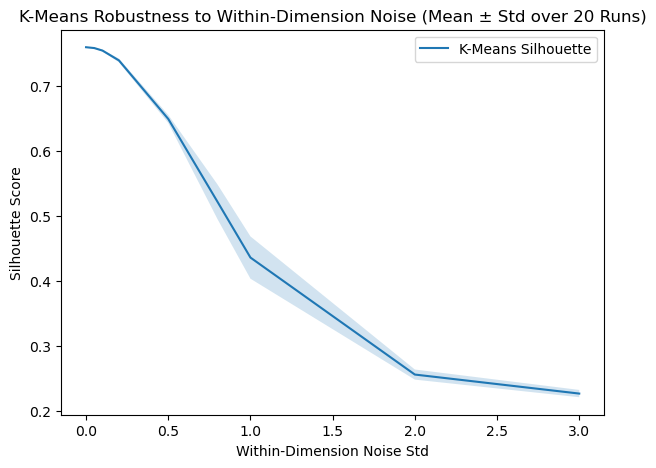

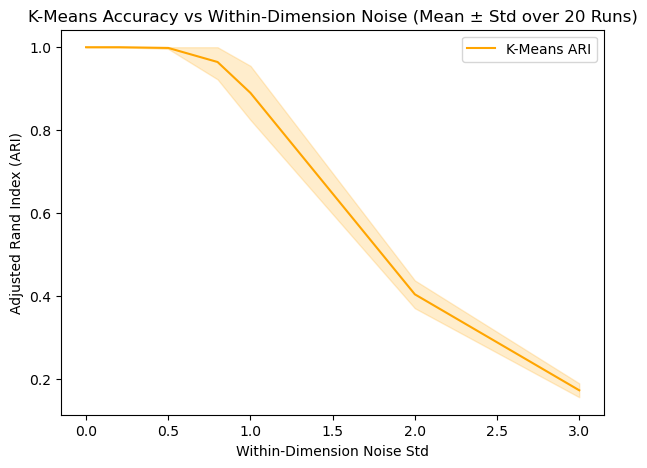

In [43]:
# Parameters
n_runs = 20
noise_stds = [0.0, 0.05, 0.1, 0.2, 0.5, 0.8, 1.0, 2.0, 3.0]

# Storage for results
kmeans_within_sil_means, kmeans_within_sil_stds = [], []
kmeans_within_ari_means, kmeans_within_ari_stds = [], []

all_kmeans_within_sil_scores, all_kmeans_within_ari_scores = [], []

# Different random seeds for reproducibility
random_seeds_within = np.random.randint(0, 10000, size=n_runs)

# Experiment loop
for std in noise_stds:
    sil_scores_run = []
    ari_scores_run = []
    
    for seed in random_seeds_within:
        X_noisy = add_within_dim_noise(X, std, seed=seed)
        kmeans = KMeans(n_clusters=8, random_state=42, n_init='auto')
        labels = kmeans.fit_predict(X_noisy)
        
        sil = silhouette_score(X_noisy, labels)
        ari = adjusted_rand_score(y, labels)  
        
        sil_scores_run.append(sil)
        ari_scores_run.append(ari)
    
    all_kmeans_within_sil_scores.append(sil_scores_run)
    all_kmeans_within_ari_scores.append(ari_scores_run)
    
    kmeans_within_sil_means.append(np.mean(sil_scores_run))
    kmeans_within_sil_stds.append(np.std(sil_scores_run))
    kmeans_within_ari_means.append(np.mean(ari_scores_run))
    kmeans_within_ari_stds.append(np.std(ari_scores_run))

# Plot Silhouette
plt.figure(figsize=(7, 5))
plt.plot(noise_stds, kmeans_within_sil_means, label='K-Means Silhouette')
plt.title('K-Means Robustness to Within-Dimension Noise (Mean ± Std over 20 Runs)')
plt.fill_between(noise_stds,
                 np.array(kmeans_within_sil_means) - np.array(kmeans_within_sil_stds),
                 np.array(kmeans_within_sil_means) + np.array(kmeans_within_sil_stds),
                 alpha=0.2)
plt.xlabel("Within-Dimension Noise Std")
plt.ylabel("Silhouette Score")
plt.legend()
plt.show()

# Plot ARI
plt.figure(figsize=(7, 5))
plt.title('K-Means Accuracy vs Within-Dimension Noise (Mean ± Std over 20 Runs)')
plt.plot(noise_stds, kmeans_within_ari_means, label='K-Means ARI', color='orange')

upper_whithin = np.minimum(np.array(kmeans_within_ari_means) + np.array(kmeans_within_ari_stds), 1.0)
lower_whithin = np.maximum(np.array(kmeans_within_ari_means) - np.array(kmeans_within_ari_stds), 0.0)

plt.fill_between(noise_stds, upper_whithin, lower_whithin, alpha=0.2, color='orange')
plt.xlabel("Within-Dimension Noise Std")
plt.ylabel("Adjusted Rand Index (ARI)")
plt.legend()
plt.show()

## DBSCAN
#### fixed eps and min_samples 

DBSCAN | Within noise std: 0.0, Silhouette Score: 0.760, ARI: 1.000
Unique labels at within noise std 0.0: [0 1 2 3 4 5 6 7]
DBSCAN | Within noise std: 0.05, Silhouette Score: 0.759, ARI: 1.000
Unique labels at within noise std 0.05: [0 1 2 3 4 5 6 7]
DBSCAN | Within noise std: 0.1, Silhouette Score: 0.756, ARI: 1.000
Unique labels at within noise std 0.1: [0 1 2 3 4 5 6 7]
DBSCAN | Within noise std: 0.2, Silhouette Score: 0.741, ARI: 1.000
Unique labels at within noise std 0.2: [0 1 2 3 4 5 6 7]
DBSCAN | Within noise std: 0.5, Silhouette Score: 0.454, ARI: 0.674
Unique labels at within noise std 0.5: [0 1 2 3 4 5]
DBSCAN | Within noise std: 0.8, Silhouette Score: nan, ARI: -0.000
Unique labels at within noise std 0.8: [-1  0]
DBSCAN | Within noise std: 1.0, Silhouette Score: nan, ARI: 0.000
Unique labels at within noise std 1.0: [-1  0]
DBSCAN | Within noise std: 2.0, Silhouette Score: 0.115, ARI: 0.001
Unique labels at within noise std 2.0: [-1  0  1]
DBSCAN | Within noise std: 3.0, 

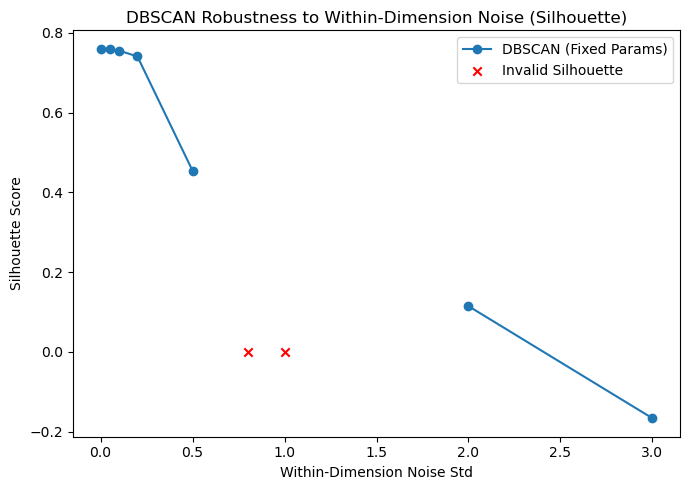

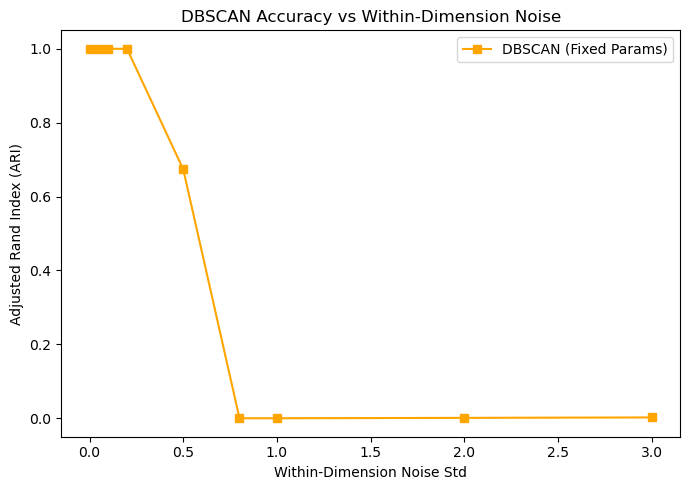

In [44]:
# DBSCAN with fixed eps and min_samples 
dbscan_within_sil_scores = []
dbscan_within_ari_scores = []

for std in noise_stds:
    X_noisy = add_within_dim_noise(X, std)
    
    dbscan = DBSCAN(eps=1.5, min_samples=5)
    labels = dbscan.fit_predict(X_noisy)
    
    # Silhouette (exclude noise)
    # creat boolean mask to filter out the noise (-1)
    mask = labels != -1
    # check if more then 1 cluster as sil need at least 2 clusters
    # check if there is at least one valid point which is not noise
    if len(set(labels[mask])) > 1 and mask.sum() > 0:
        # if yes then compute sil score
        sil = silhouette_score(X_noisy[mask], labels[mask])
    else:
        # if not state as nan
        sil = np.nan
    
    # ARI (include noise as its own cluster)
    ari = adjusted_rand_score(y, labels)  
    
    dbscan_within_sil_scores.append(sil)
    dbscan_within_ari_scores.append(ari)
    
    print(f"DBSCAN | Within noise std: {std}, Silhouette Score: {sil:.3f}, ARI: {ari:.3f}")
    print(f"Unique labels at within noise std {std}: {np.unique(labels)}")
    
# Arrays for plotting (DBSCAN fixed params)
noise_stds_dbscan_fixed = np.array(noise_stds, dtype=float)
sil_dbscan_fixed  = np.array(dbscan_within_sil_scores, dtype=float)
ari_dbscan_fixed  = np.array(dbscan_within_ari_scores, dtype=float)

# Silhouette 
plt.figure(figsize=(7,5))
# Mask invalid so the line has gaps
sil_ma_dbscan_fixed = np.ma.masked_invalid(sil_dbscan_fixed)
plt.plot(noise_stds_dbscan_fixed, sil_ma_dbscan_fixed, marker='o',
         label='DBSCAN (Fixed Params)', zorder=1)

# Mark NaN points with red X at y=0
nan_mask_dbscan_fixed = np.isnan(sil_dbscan_fixed)
plt.scatter(noise_stds_dbscan_fixed[nan_mask_dbscan_fixed],
            np.zeros(nan_mask_dbscan_fixed.sum()),
            marker='x', color='red', label='Invalid Silhouette', zorder=2)

plt.xlabel('Within-Dimension Noise Std')
plt.ylabel('Silhouette Score')
plt.title('DBSCAN Robustness to Within-Dimension Noise (Silhouette)')
plt.legend()
plt.tight_layout()
plt.show()

# ARI 
plt.figure(figsize=(7,5))
plt.plot(noise_stds_dbscan_fixed, ari_dbscan_fixed, marker='s', 
         label='DBSCAN (Fixed Params)', color='orange')
plt.xlabel('Within-Dimension Noise Std')
plt.ylabel('Adjusted Rand Index (ARI)')
plt.title('DBSCAN Accuracy vs Within-Dimension Noise')
plt.legend()
plt.tight_layout()
plt.show()

In [45]:
# Parameters
n_runs = 20
noise_stds = [0.0, 0.05, 0.1, 0.2, 0.5, 0.8, 1.0, 2.0, 3.0]

# Storage for results
dbscan_within_sil_means, dbscan_within_sil_stds = [], []
dbscan_within_ari_means, dbscan_within_ari_stds = [], []
dbscan_within_sil_valid_counts = []
avg_clusters_per_std = []
avg_noise_ratio_per_std = []
all_dbscan_within_sil_scores, all_dbscan_within_ari_scores = [], []

# Different seeds for repeated runs
random_seeds_within = np.random.randint(0, 10000, size=n_runs)

# Loop over noise std levels
for std in noise_stds:
    sil_scores_run, ari_scores_run = [], []
    num_clusters_list = []
    noise_ratio_list = []
    
    for seed in random_seeds_within:
        X_noisy = add_within_dim_noise(X, std, seed=seed)
        dbscan = DBSCAN(eps=1.5, min_samples=5)
        labels = dbscan.fit_predict(X_noisy)
        
        # Clusters count
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        num_clusters_list.append(n_clusters)

        # Noise ratio
        noise_ratio = np.sum(labels == -1) / len(labels)
        noise_ratio_list.append(noise_ratio)
        
        # Silhouette (exclude noise)
        # creat boolean mask to filter out the noise (-1)
        mask = labels != -1
        # check if more then 1 cluster as sil need at least 2 clusters
        # check if there is at least one valid point which is not noise
        if len(set(labels[mask])) > 1 and mask.sum() > 0:
            # if yes then compute sil score
            sil = silhouette_score(X_noisy[mask], labels[mask])
        else:
            # if not state as nan
            sil = np.nan
        
        # ARI (include noise)
        ari = adjusted_rand_score(y, labels)
        
        sil_scores_run.append(sil)
        ari_scores_run.append(ari)
    
    # Store all runs
    all_dbscan_within_sil_scores.append(sil_scores_run)
    all_dbscan_within_ari_scores.append(ari_scores_run)

    # Count valid silhouette runs
    valid_count = np.sum(~np.isnan(sil_scores_run))
    dbscan_within_sil_valid_counts.append(valid_count)

    # Average clusters & noise ratio
    avg_clusters_per_std.append(np.mean(num_clusters_list))
    avg_noise_ratio_per_std.append(np.mean(noise_ratio_list))

    # Means & stds (handle NaN case)
    if valid_count == 0:
        dbscan_within_sil_means.append(0)
        dbscan_within_sil_stds.append(0)
    else:
        dbscan_within_sil_means.append(np.nanmean(sil_scores_run))
        dbscan_within_sil_stds.append(np.nanstd(sil_scores_run))

    dbscan_within_ari_means.append(np.mean(ari_scores_run))
    dbscan_within_ari_stds.append(np.std(ari_scores_run))

# Print like noise-dimension experiment
for i, std in enumerate(noise_stds):
    print(f"Noise std {std}: valid_runs={dbscan_within_sil_valid_counts[i]}, "
          f"avg_clusters={avg_clusters_per_std[i]:.2f}, "
          f"avg_noise_ratio={avg_noise_ratio_per_std[i]:.2f}, "
          f"sil_mean={dbscan_within_sil_means[i]:.3f}, "
          f"ari_mean={dbscan_within_ari_means[i]:.3f}")

Noise std 0.0: valid_runs=20, avg_clusters=8.00, avg_noise_ratio=0.00, sil_mean=0.760, ari_mean=1.000
Noise std 0.05: valid_runs=20, avg_clusters=8.00, avg_noise_ratio=0.00, sil_mean=0.759, ari_mean=1.000
Noise std 0.1: valid_runs=20, avg_clusters=8.00, avg_noise_ratio=0.00, sil_mean=0.754, ari_mean=1.000
Noise std 0.2: valid_runs=20, avg_clusters=7.95, avg_noise_ratio=0.00, sil_mean=0.734, ari_mean=0.993
Noise std 0.5: valid_runs=20, avg_clusters=5.45, avg_noise_ratio=0.00, sil_mean=0.426, ari_mean=0.637
Noise std 0.8: valid_runs=0, avg_clusters=1.00, avg_noise_ratio=0.01, sil_mean=0.000, ari_mean=0.000
Noise std 1.0: valid_runs=0, avg_clusters=1.00, avg_noise_ratio=0.02, sil_mean=0.000, ari_mean=0.000
Noise std 2.0: valid_runs=18, avg_clusters=3.00, avg_noise_ratio=0.15, sil_mean=0.007, ari_mean=0.001
Noise std 3.0: valid_runs=20, avg_clusters=9.90, avg_noise_ratio=0.36, sil_mean=-0.183, ari_mean=0.002


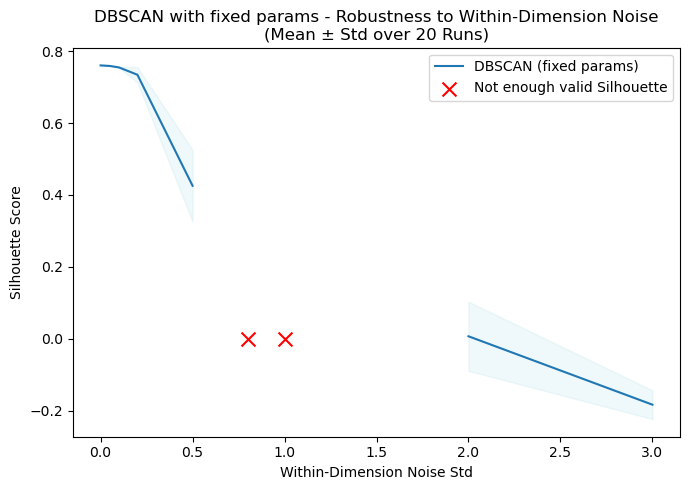

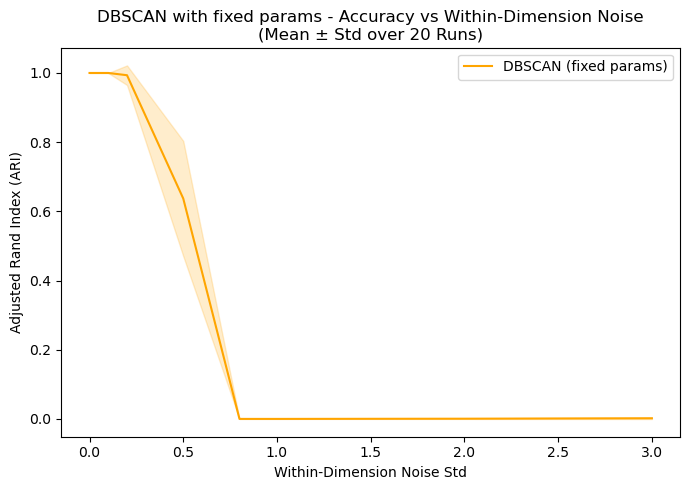

In [46]:
# Convert to numpy arrays for easier indexing
noise_stds_within_arr = np.array(noise_stds, dtype=float)
sil_within_means_arr  = np.array(dbscan_within_sil_means, dtype=float)
sil_within_stds_arr   = np.array(dbscan_within_sil_stds, dtype=float)
ari_within_means_arr  = np.array(dbscan_within_ari_means, dtype=float)
ari_within_stds_arr   = np.array(dbscan_within_ari_stds, dtype=float)

valid_counts_within   = np.array(dbscan_within_sil_valid_counts, dtype=int)
min_valid_within = 10  

# Make a copy of means where invalid points are set to NaN
sil_within_means_plot = sil_within_means_arr.copy()
sil_within_means_plot[valid_counts_within < min_valid_within] = np.nan

# Masks
band_mask_within    = valid_counts_within >= min_valid_within   # fill band only where fully valid
invalid_mask_within = valid_counts_within < min_valid_within    # mark stds with too few valid runs

# Silhouette
plt.figure(figsize=(7, 5))
plt.plot(noise_stds_within_arr, sil_within_means_plot, 
         label='DBSCAN (fixed params)')

# Shade only contiguous valid segments
valid_idx = np.where(band_mask_within)[0]
segments = np.split(valid_idx, np.where(np.diff(valid_idx) != 1)[0] + 1)
for seg in segments:
    if len(seg) < 2:
        continue
    plt.fill_between(
        noise_stds_within_arr[seg],
        sil_within_means_arr[seg] - sil_within_stds_arr[seg],
        sil_within_means_arr[seg] + sil_within_stds_arr[seg],
        color='powderblue',
        alpha=0.2
    )

# Mark invalid points at baseline
plt.scatter(
    noise_stds_within_arr[invalid_mask_within],
    np.zeros(invalid_mask_within.sum()),
    color='red', marker='x', s=100, label='Not enough valid Silhouette'
)

plt.title('DBSCAN with fixed params - Robustness to Within-Dimension Noise\n(Mean ± Std over 20 Runs)')
plt.xlabel('Within-Dimension Noise Std')
plt.ylabel('Silhouette Score')
plt.legend()
plt.tight_layout()
plt.show()

# ARI
plt.figure(figsize=(7, 5))
plt.plot(noise_stds_within_arr, ari_within_means_arr, label='DBSCAN (fixed params)', color='orange')
plt.fill_between(noise_stds_within_arr,
                 ari_within_means_arr - ari_within_stds_arr,
                 ari_within_means_arr + ari_within_stds_arr,
                 alpha=0.2, color='orange')

plt.title('DBSCAN with fixed params - Accuracy vs Within-Dimension Noise\n(Mean ± Std over 20 Runs)')
plt.xlabel('Within-Dimension Noise Std')
plt.ylabel('Adjusted Rand Index (ARI)')
plt.legend()
plt.tight_layout()
plt.show()


#### best eps fixed min_samples 

Within noise std: 0.0, Best eps: 0.50, Silhouette: 0.791, ARI: 0.790, Clusters: 8, Noise ratio: 0.13
Unique labels at within std 0.0 (best params): [-1  0  1  2  3  4  5  6  7]
Within noise std: 0.05, Best eps: 0.50, Silhouette: 0.790, ARI: 0.788, Clusters: 8, Noise ratio: 0.13
Unique labels at within std 0.05 (best params): [-1  0  1  2  3  4  5  6  7]
Within noise std: 0.1, Best eps: 0.63, Silhouette: 0.767, ARI: 0.952, Clusters: 8, Noise ratio: 0.04
Unique labels at within std 0.1 (best params): [-1  0  1  2  3  4  5  6  7]
Within noise std: 0.2, Best eps: 0.63, Silhouette: 0.756, ARI: 0.939, Clusters: 8, Noise ratio: 0.05
Unique labels at within std 0.2 (best params): [-1  0  1  2  3  4  5  6  7]
Within noise std: 0.5, Best eps: 0.76, Silhouette: 0.680, ARI: 0.888, Clusters: 8, Noise ratio: 0.08
Unique labels at within std 0.5 (best params): [-1  0  1  2  3  4  5  6  7]
Within noise std: 0.8, Best eps: 0.76, Silhouette: 0.511, ARI: 0.435, Clusters: 10, Noise ratio: 0.30
Unique labe

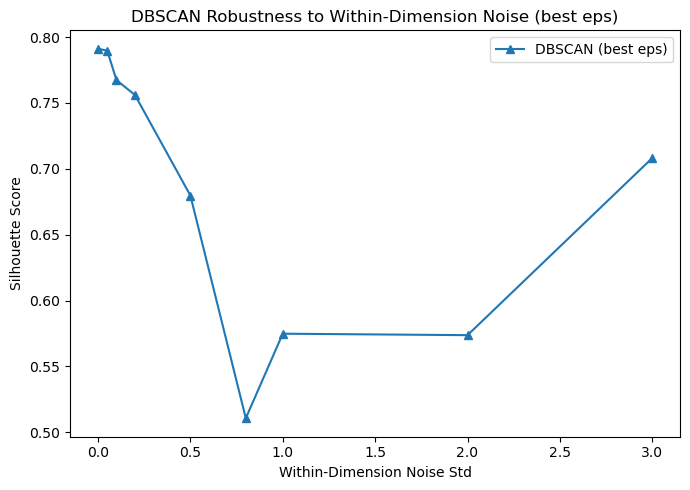

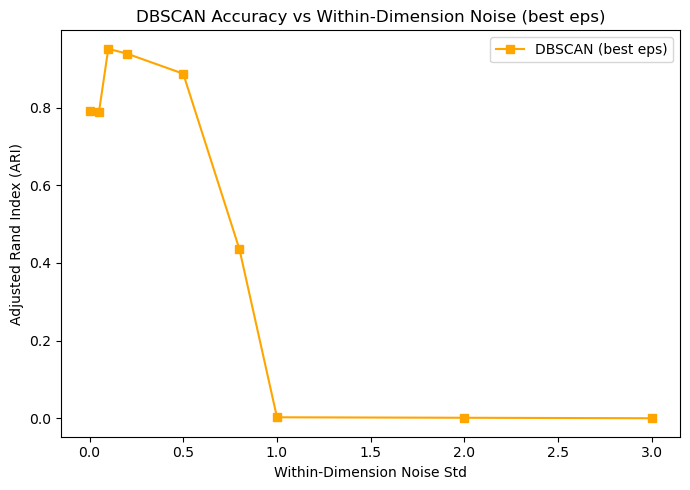

In [47]:
# DBSCAN best eps fixed min_samples 
eps_range_within = np.linspace(0.5, 3.0, 20)
best_sil_scores_within, best_ari_scores_within, best_eps_values_within = [], [], []
best_n_clusters_within = []
best_noise_ratio_within = []

# Within-dimension noise std levels
noise_stds = [0.0, 0.05, 0.1, 0.2, 0.5, 0.8, 1.0, 2.0, 3.0]

for std in noise_stds:
    X_noisy = add_within_dim_noise(X, std)
    
    best_sil = -np.inf
    best_ari = np.nan
    best_eps = None
    best_labels = None
    
    for eps in eps_range_within:
        dbscan = DBSCAN(eps=eps, min_samples=5)
        labels = dbscan.fit_predict(X_noisy)
        
        # Silhouette (exclude noise)
        # creat boolean mask to filter out the noise (-1)
        mask = labels != -1
        # check if more then 1 cluster as sil need at least 2 clusters
        # check if there is at least one valid point which is not noise
        if len(set(labels[mask])) > 1 and mask.sum() > 0:
            # if yes then compute sil score
            sil = silhouette_score(X_noisy[mask], labels[mask])
            ari = adjusted_rand_score(y, labels)  # y = true labels
            
            if sil > best_sil:
                best_sil = sil
                best_ari = ari
                best_eps = eps
                best_labels = labels

    if best_labels is None:
        # no valid eps produced ≥2 non-noise clusters
        best_sil_scores_within.append(np.nan)
        best_ari_scores_within.append(np.nan)
        best_eps_values_within.append(None)
        best_n_clusters_within.append(0)
        best_noise_ratio_within.append(1.0)
        print(f"Within noise std: {std}, no valid eps (min_samples=5).")
    else:
        n_clusters = len(set(best_labels)) - (1 if -1 in best_labels else 0)
        noise_ratio = (best_labels == -1).mean()

        best_sil_scores_within.append(best_sil)
        best_ari_scores_within.append(best_ari)
        best_eps_values_within.append(best_eps)
        best_n_clusters_within.append(n_clusters)
        best_noise_ratio_within.append(noise_ratio)

        print(
            f"Within noise std: {std}, Best eps: {best_eps:.2f}, "
            f"Silhouette: {best_sil:.3f}, ARI: {best_ari:.3f}, "
            f"Clusters: {n_clusters}, Noise ratio: {noise_ratio:.2f}"
        )
        print(f"Unique labels at within std {std} (best params): {np.unique(best_labels)}")
        
# Prep arrays + masks
noise_stds_arr = np.array(noise_stds)
sil_best_arr = np.array(best_sil_scores_within, dtype=float)
ari_best_arr = np.array(best_ari_scores_within, dtype=float)

# Silhouette 
plt.figure(figsize=(7,5))
plt.plot(noise_stds_arr, sil_best_arr, marker='^', label='DBSCAN (best eps)')
plt.title('DBSCAN Robustness to Within-Dimension Noise (best eps)')
plt.xlabel('Within-Dimension Noise Std')
plt.ylabel('Silhouette Score')
plt.legend()
plt.tight_layout()
plt.show()

# ARI 
plt.figure(figsize=(7,5))
plt.plot(noise_stds_arr, ari_best_arr, marker='s', label='DBSCAN (best eps)', color='orange')
plt.title('DBSCAN Accuracy vs Within-Dimension Noise (best eps)')
plt.xlabel('Within-Dimension Noise Std')
plt.ylabel('Adjusted Rand Index (ARI)')
plt.legend()
plt.tight_layout()
plt.show()

#### best eps and min_samples 

Within noise std: 0.0, Best eps: 0.50, Best min_samples: 10, Silhouette: 0.812, ARI: 0.553, Clusters: 8, Noise ratio: 0.25
Unique labels at within std 0.0 (best params): [-1  0  1  2  3  4  5  6  7]
Within noise std: 0.05, Best eps: 0.50, Best min_samples: 10, Silhouette: 0.812, ARI: 0.540, Clusters: 8, Noise ratio: 0.25
Unique labels at within std 0.05 (best params): [-1  0  1  2  3  4  5  6  7]
Within noise std: 0.1, Best eps: 0.50, Best min_samples: 10, Silhouette: 0.812, ARI: 0.493, Clusters: 8, Noise ratio: 0.28
Unique labels at within std 0.1 (best params): [-1  0  1  2  3  4  5  6  7]
Within noise std: 0.2, Best eps: 0.50, Best min_samples: 10, Silhouette: 0.808, ARI: 0.376, Clusters: 8, Noise ratio: 0.34
Unique labels at within std 0.2 (best params): [-1  0  1  2  3  4  5  6  7]
Within noise std: 0.5, Best eps: 0.50, Best min_samples: 10, Silhouette: 0.768, ARI: 0.025, Clusters: 7, Noise ratio: 0.83
Unique labels at within std 0.5 (best params): [-1  0  1  2  3  4  5  6]
Within

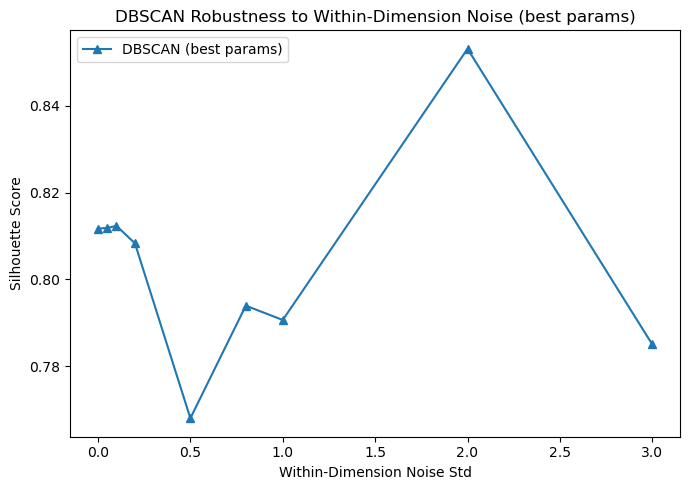

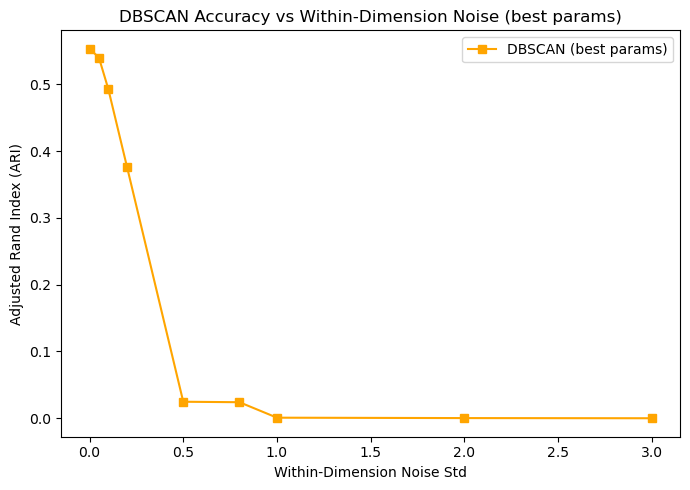

In [48]:
# DBSCAN best eps best min_samples
eps_range_within_2 = np.linspace(0.5, 3.0, 20)
min_samples_range_within_2 = range(2, 11)

best_sil_scores_within_2, best_ari_scores_within_2 = [], []
best_eps_values_within_2, best_min_samples_values_within_2 = [], []
best_n_clusters_within_2, best_noise_ratio_within_2 = [], []

# Within-dimension noise std levels
noise_stds = [0.0, 0.05, 0.1, 0.2, 0.5, 0.8, 1.0, 2.0, 3.0]

for std in noise_stds:
    X_noisy_within_2 = add_within_dim_noise(X, std)
    
    best_sil_w2 = -np.inf
    best_ari_w2 = np.nan
    best_eps_w2 = None
    best_min_samples_w2 = None
    best_labels_w2 = None
    
    for eps in eps_range_within_2:
        for min_samples in min_samples_range_within_2:
            dbscan_w2 = DBSCAN(eps=eps, min_samples=min_samples)
            labels_w2 = dbscan_w2.fit_predict(X_noisy_within_2)
            
            # Silhouette (exclude noise)
            # creat boolean mask to filter out the noise (-1)
            mask_w2 = labels_w2 != -1
            # check if more then 1 cluster as sil need at least 2 clusters
            # check if there is at least one valid point which is not noise
            if len(set(labels_w2[mask_w2])) > 1 and mask_w2.sum() > 0:
                # if yes then compute sil score
                sil_w2 = silhouette_score(X_noisy_within_2[mask_w2], labels_w2[mask_w2])
                ari_w2 = adjusted_rand_score(y, labels_w2)  # y = true labels

                if sil_w2 > best_sil_w2:
                    best_sil_w2 = sil_w2
                    best_ari_w2 = ari_w2
                    best_eps_w2 = eps
                    best_min_samples_w2 = min_samples
                    best_labels_w2 = labels_w2
    
    if best_labels_w2 is None:
        # no (eps, min_samples) produced ≥2 non-noise clusters
        best_sil_scores_within_2.append(np.nan)
        best_ari_scores_within_2.append(np.nan)
        best_eps_values_within_2.append(None)
        best_min_samples_values_within_2.append(None)
        best_n_clusters_within_2.append(0)
        best_noise_ratio_within_2.append(1.0)
        print(f"Within noise std: {std}, no valid (eps, min_samples).")
    else:
        n_clusters_w2 = len(set(best_labels_w2)) - (1 if -1 in best_labels_w2 else 0)
        noise_ratio_w2 = (best_labels_w2 == -1).mean()

        best_sil_scores_within_2.append(best_sil_w2)
        best_ari_scores_within_2.append(best_ari_w2)
        best_eps_values_within_2.append(best_eps_w2)
        best_min_samples_values_within_2.append(best_min_samples_w2)
        best_n_clusters_within_2.append(n_clusters_w2)
        best_noise_ratio_within_2.append(noise_ratio_w2)

        print(
            f"Within noise std: {std}, Best eps: {best_eps_w2:.2f}, "
            f"Best min_samples: {best_min_samples_w2}, "
            f"Silhouette: {best_sil_w2:.3f}, ARI: {best_ari_w2:.3f}, "
            f"Clusters: {n_clusters_w2}, Noise ratio: {noise_ratio_w2:.2f}"
        )
        print(f"Unique labels at within std {std} (best params): {np.unique(best_labels_w2)}")
        
# Prep arrays + masks
sil_best_arr2 = np.array(best_sil_scores_within_2, dtype=float)
ari_best_arr2 = np.array(best_ari_scores_within_2, dtype=float)

# Silhouette 
plt.figure(figsize=(7,5))
plt.plot(noise_stds_arr, sil_best_arr2, marker='^', label='DBSCAN (best params)')
plt.title('DBSCAN Robustness to Within-Dimension Noise (best params)')
plt.xlabel('Within-Dimension Noise Std')
plt.ylabel('Silhouette Score')
plt.legend()
plt.tight_layout()
plt.show()

# ARI 
plt.figure(figsize=(7,5))
plt.plot(noise_stds_arr, ari_best_arr2, marker='s', label='DBSCAN (best params)', color='orange')
plt.title('DBSCAN Accuracy vs Within-Dimension Noise (best params)')
plt.xlabel('Within-Dimension Noise Std')
plt.ylabel('Adjusted Rand Index (ARI)')
plt.legend()
plt.tight_layout()
plt.show()

Within noise std: 0.0, Best eps: 0.50, Best min_samples: 10, Silhouette: 0.812, ARI: 0.553, Clusters: 8, Noise ratio: 0.25
Unique labels at within std 0.0 (best params): [-1  0  1  2  3  4  5  6  7]
Within noise std: 0.05, Best eps: 0.50, Best min_samples: 10, Silhouette: 0.812, ARI: 0.540, Clusters: 8, Noise ratio: 0.25
Unique labels at within std 0.05 (best params): [-1  0  1  2  3  4  5  6  7]
Within noise std: 0.1, Best eps: 0.50, Best min_samples: 10, Silhouette: 0.812, ARI: 0.493, Clusters: 8, Noise ratio: 0.28
Unique labels at within std 0.1 (best params): [-1  0  1  2  3  4  5  6  7]
Within noise std: 0.2, Best eps: 0.50, Best min_samples: 10, Silhouette: 0.808, ARI: 0.376, Clusters: 8, Noise ratio: 0.34
Unique labels at within std 0.2 (best params): [-1  0  1  2  3  4  5  6  7]
Within noise std: 0.5, Best eps: 0.50, Best min_samples: 10, Silhouette: 0.768, ARI: 0.025, Clusters: 7, Noise ratio: 0.83
Unique labels at within std 0.5 (best params): [-1  0  1  2  3  4  5  6]
Within

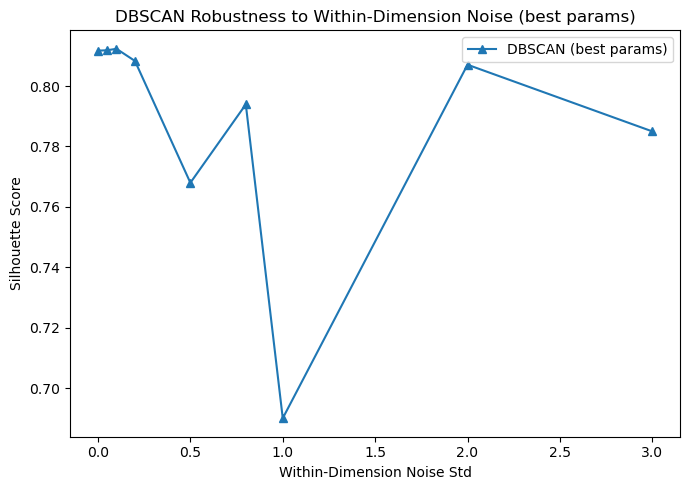

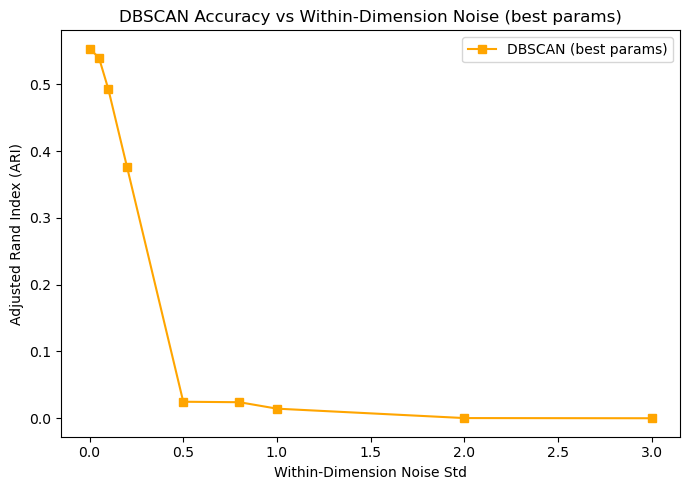

In [49]:
# DBSCAN best eps best min_samples with at least more then 5 cluster
eps_range_within_2 = np.linspace(0.5, 3.0, 20)
min_samples_range_within_2 = range(2, 11)

best_sil_scores_within_2, best_ari_scores_within_2 = [], []
best_eps_values_within_2, best_min_samples_values_within_2 = [], []
best_n_clusters_within_2, best_noise_ratio_within_2 = [], []

# Within-dimension noise std levels
noise_stds = [0.0, 0.05, 0.1, 0.2, 0.5, 0.8, 1.0, 2.0, 3.0]

for std in noise_stds:
    X_noisy_within_2 = add_within_dim_noise(X, std)
    
    best_sil_w2 = -np.inf
    best_ari_w2 = np.nan
    best_eps_w2 = None
    best_min_samples_w2 = None
    best_labels_w2 = None
    best_n_clusters_curr = 0
    best_noise_ratio_curr = 1.0
    
    for eps in eps_range_within_2:
        for min_samples in min_samples_range_within_2:
            dbscan_w2 = DBSCAN(eps=eps, min_samples=min_samples)
            labels_w2 = dbscan_w2.fit_predict(X_noisy_within_2)
            
            # cluster stats for this candidate
            n_clusters = len(set(labels_w2)) - (1 if -1 in labels_w2 else 0)
            noise_ratio = (labels_w2 == -1).mean()
            
            # Silhouette (exclude noise)
            # creat boolean mask to filter out the noise (-1)
            mask_w2 = labels_w2 != -1
            # check if more then 1 cluster as sil need at least 2 clusters
            # check if there is at least one valid point which is not noise
            if len(set(labels_w2[mask_w2])) > 1 and mask_w2.sum() > 0:
                # if yes then compute sil score
                sil_w2 = silhouette_score(X_noisy_within_2[mask_w2], labels_w2[mask_w2])
                ari_w2 = adjusted_rand_score(y, labels_w2)  # y = true labels

                # require at least 5 clusters
                if sil_w2 > best_sil_w2 and n_clusters >= 5:
                    best_sil_w2 = sil_w2
                    best_ari_w2 = ari_w2
                    best_eps_w2 = eps
                    best_min_samples_w2 = min_samples
                    best_labels_w2 = labels_w2
                    best_n_clusters_curr = n_clusters
                    best_noise_ratio_curr = noise_ratio
    
    if best_labels_w2 is None:
        # no (eps, min_samples) gave ≥5 clusters w/ valid silhouette
        best_sil_scores_within_2.append(np.nan)
        best_ari_scores_within_2.append(np.nan)
        best_eps_values_within_2.append(None)
        best_min_samples_values_within_2.append(None)
        best_n_clusters_within_2.append(0)
        best_noise_ratio_within_2.append(1.0)
        print(f"Within noise std: {std}, no valid (eps, min_samples) with ≥5 clusters.")
    else:
        best_sil_scores_within_2.append(best_sil_w2)
        best_ari_scores_within_2.append(best_ari_w2)
        best_eps_values_within_2.append(best_eps_w2)
        best_min_samples_values_within_2.append(best_min_samples_w2)
        best_n_clusters_within_2.append(best_n_clusters_curr)
        best_noise_ratio_within_2.append(best_noise_ratio_curr)

        print(
            f"Within noise std: {std}, Best eps: {best_eps_w2:.2f}, "
            f"Best min_samples: {best_min_samples_w2}, "
            f"Silhouette: {best_sil_w2:.3f}, ARI: {best_ari_w2:.3f}, "
            f"Clusters: {best_n_clusters_curr}, Noise ratio: {best_noise_ratio_curr:.2f}"
        )
        print(f"Unique labels at within std {std} (best params): {np.unique(best_labels_w2)}")
        
# Prep arrays + masks
sil_best_arr2 = np.array(best_sil_scores_within_2, dtype=float)
ari_best_arr2 = np.array(best_ari_scores_within_2, dtype=float)

# Silhouette 
plt.figure(figsize=(7,5))
plt.plot(noise_stds_arr, sil_best_arr2, marker='^', label='DBSCAN (best params)')
plt.title('DBSCAN Robustness to Within-Dimension Noise (best params)')
plt.xlabel('Within-Dimension Noise Std')
plt.ylabel('Silhouette Score')
plt.legend()
plt.tight_layout()
plt.show()

# ARI 
plt.figure(figsize=(7,5))
plt.plot(noise_stds_arr, ari_best_arr2, marker='s', label='DBSCAN (best params)', color='orange')
plt.title('DBSCAN Accuracy vs Within-Dimension Noise (best params)')
plt.xlabel('Within-Dimension Noise Std')
plt.ylabel('Adjusted Rand Index (ARI)')
plt.legend()
plt.tight_layout()
plt.show()

In [50]:
# DBSCAN best params 
n_runs_within = 20
random_seeds_within = np.random.randint(0, 10000, size=n_runs_within)

eps_range_within = np.linspace(0.5, 3.0, 20)
min_samples_range_within = range(2, 11)

best_sil_all_within, best_sil_mean_within, best_sil_std_within = [], [], []

best_ari_all_within, best_ari_mean_within, best_ari_std_within = [], [], []

valid_runs_list_within = []
avg_clusters_list_within = []
avg_noise_ratio_list_within = []

# Noise std levels for within-dimension noise
noise_stds = [0.0, 0.05, 0.1, 0.2, 0.5, 0.8, 1.0, 2.0, 3.0]

for std in noise_stds:
    run_sil_scores_w, run_ari_scores_w = [], []
    run_clusters_w = []
    run_noise_ratios_w = []

    valid_runs_w = 0
    
    for seed in random_seeds_within:
        X_noisy_w = add_within_dim_noise(X, std, seed=seed)
        
        best_sil_w = -np.inf
        best_ari_w = np.nan
        best_eps_w = None
        best_min_samples_w = None
        best_labels_w = None
        
        for eps in eps_range_within:
            for min_samples in min_samples_range_within:
                dbscan_w = DBSCAN(eps=eps, min_samples=min_samples)
                labels_w = dbscan_w.fit_predict(X_noisy_w)
                
                mask_w = labels_w != -1
                if len(set(labels_w[mask_w])) > 1 and mask_w.sum() > 0:
                    sil_w = silhouette_score(X_noisy_w[mask_w], labels_w[mask_w])
                    ari_w = adjusted_rand_score(y, labels_w)
                    
                    if sil_w > best_sil_w:
                        best_sil_w = sil_w
                        best_ari_w = ari_w
                        best_eps_w = eps
                        best_min_samples_w = min_samples
                        best_labels_w = labels_w

        if best_labels_w is not None:
            valid_runs_w += 1
            n_clusters_w = len(set(best_labels_w)) - (1 if -1 in best_labels_w else 0)
            noise_ratio_w = (best_labels_w == -1).mean()
        else:
            n_clusters_w = 0
            noise_ratio_w = 1.0
            if np.isneginf(best_sil_w):
                best_sil_w = 0.0
                best_ari_w = 0.0

        run_sil_scores_w.append(best_sil_w)
        run_ari_scores_w.append(best_ari_w)
        run_clusters_w.append(n_clusters_w)
        run_noise_ratios_w.append(noise_ratio_w)

    best_sil_all_within.append(run_sil_scores_w)
    best_ari_all_within.append(run_ari_scores_w)
    best_sil_mean_within.append(np.mean(run_sil_scores_w))
    best_sil_std_within.append(np.std(run_sil_scores_w))
    best_ari_mean_within.append(np.mean(run_ari_scores_w))
    best_ari_std_within.append(np.std(run_ari_scores_w))

    valid_runs_list_within.append(valid_runs_w)
    avg_clusters_list_within.append(np.mean(run_clusters_w))
    avg_noise_ratio_list_within.append(np.mean(run_noise_ratios_w))

    print(f"Noise std {std}: valid_runs={valid_runs_w}, "
          f"avg_clusters={np.mean(run_clusters_w):.2f}, "
          f"avg_noise_ratio={np.mean(run_noise_ratios_w):.2f}, "
          f"sil_mean={np.mean(run_sil_scores_w):.3f}, "
          f"ari_mean={np.mean(run_ari_scores_w):.3f}")

Noise std 0.0: valid_runs=20, avg_clusters=8.00, avg_noise_ratio=0.25, sil_mean=0.812, ari_mean=0.553
Noise std 0.05: valid_runs=20, avg_clusters=8.00, avg_noise_ratio=0.24, sil_mean=0.810, ari_mean=0.567
Noise std 0.1: valid_runs=20, avg_clusters=8.00, avg_noise_ratio=0.26, sil_mean=0.809, ari_mean=0.533
Noise std 0.2: valid_runs=20, avg_clusters=8.00, avg_noise_ratio=0.32, sil_mean=0.807, ari_mean=0.416
Noise std 0.5: valid_runs=20, avg_clusters=7.65, avg_noise_ratio=0.58, sil_mean=0.776, ari_mean=0.196
Noise std 0.8: valid_runs=20, avg_clusters=3.10, avg_noise_ratio=0.95, sil_mean=0.889, ari_mean=0.003
Noise std 1.0: valid_runs=20, avg_clusters=3.35, avg_noise_ratio=0.95, sil_mean=0.882, ari_mean=0.003
Noise std 2.0: valid_runs=20, avg_clusters=3.55, avg_noise_ratio=0.98, sil_mean=0.868, ari_mean=0.000
Noise std 3.0: valid_runs=20, avg_clusters=3.45, avg_noise_ratio=0.98, sil_mean=0.891, ari_mean=0.000


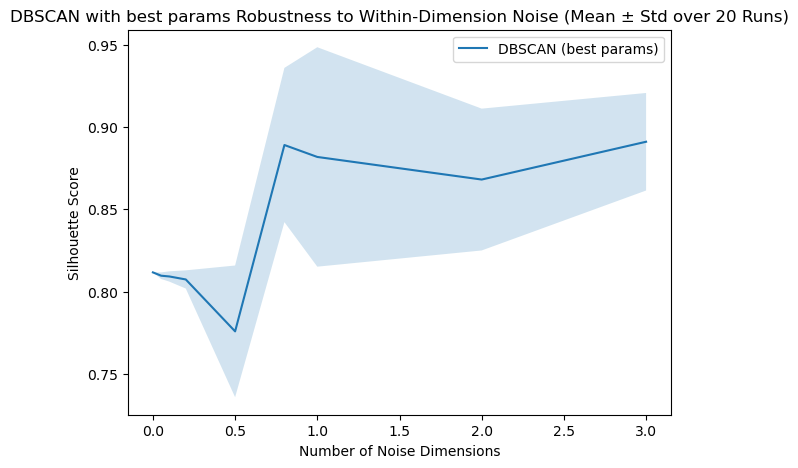

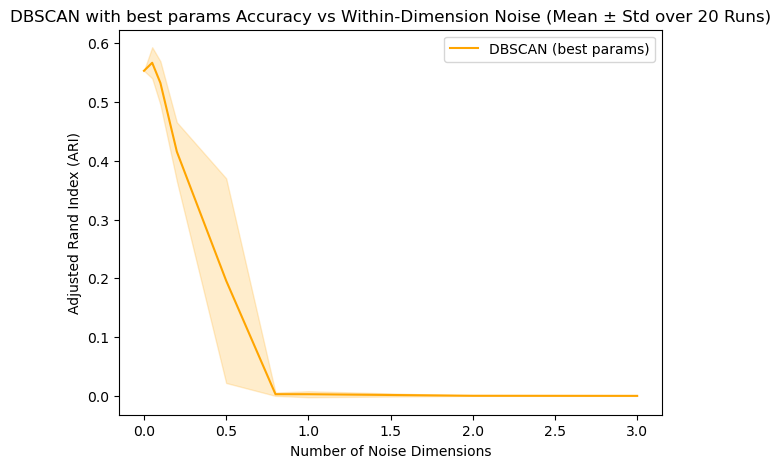

In [51]:
# Plot Silhouette
plt.figure(figsize=(7, 5))
plt.plot(noise_stds, best_sil_mean_within, label='DBSCAN (best params)')
plt.title('DBSCAN with best params Robustness to Within-Dimension Noise (Mean ± Std over 20 Runs)')
plt.fill_between(noise_stds,
                 np.array(best_sil_mean_within) - np.array(best_sil_std_within),
                 np.array(best_sil_mean_within) + np.array(best_sil_std_within),
                 alpha=0.2)
plt.xlabel("Number of Noise Dimensions")
plt.ylabel("Silhouette Score")
plt.legend()
plt.show()

# Plot ARI 
plt.figure(figsize=(7, 5))
plt.plot(noise_stds, best_ari_mean_within, label='DBSCAN (best params)', color='orange')
plt.title('DBSCAN with best params Accuracy vs Within-Dimension Noise (Mean ± Std over 20 Runs)')
plt.fill_between(noise_stds,
                 np.array(best_ari_mean_within) - np.array(best_ari_std_within),
                 np.array(best_ari_mean_within) + np.array(best_ari_std_within),
                 alpha=0.2, color='orange')
plt.xlabel("Number of Noise Dimensions")
plt.ylabel("Adjusted Rand Index (ARI)")
plt.legend()
plt.show()

# Agglomerative


Running Agglomerative Clustering (within-dimension noise) with linkage = 'ward'
Within noise std: 0.0, Silhouette: 0.760, ARI: 1.000
Within noise std: 0.05, Silhouette: 0.759, ARI: 1.000
Within noise std: 0.1, Silhouette: 0.756, ARI: 1.000
Within noise std: 0.2, Silhouette: 0.741, ARI: 1.000
Within noise std: 0.5, Silhouette: 0.650, ARI: 0.997
Within noise std: 0.8, Silhouette: 0.520, ARI: 0.946
Within noise std: 1.0, Silhouette: 0.437, ARI: 0.866
Within noise std: 2.0, Silhouette: 0.214, ARI: 0.336
Within noise std: 3.0, Silhouette: 0.176, ARI: 0.130


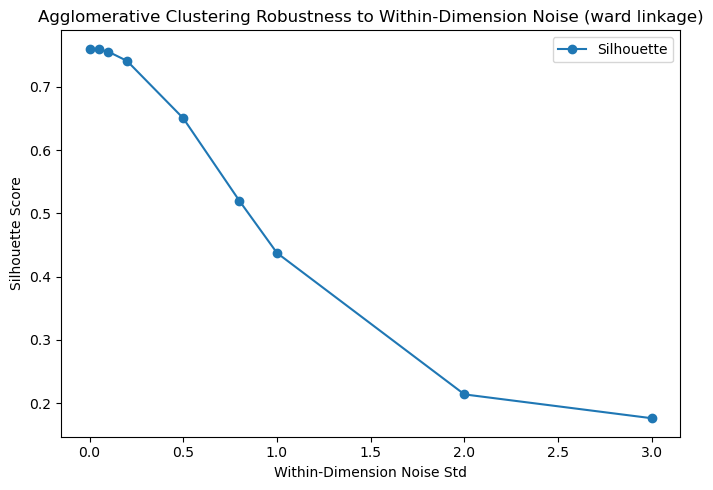

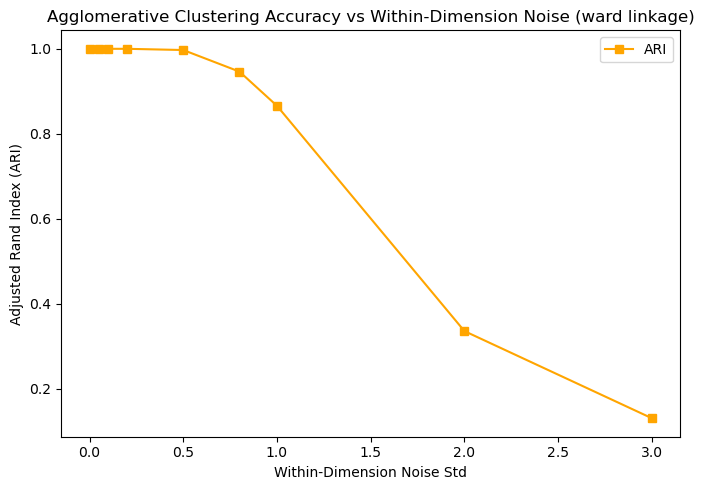


Running Agglomerative Clustering (within-dimension noise) with linkage = 'average'
Within noise std: 0.0, Silhouette: 0.760, ARI: 1.000
Within noise std: 0.05, Silhouette: 0.759, ARI: 1.000
Within noise std: 0.1, Silhouette: 0.756, ARI: 1.000
Within noise std: 0.2, Silhouette: 0.741, ARI: 1.000
Within noise std: 0.5, Silhouette: 0.650, ARI: 0.997
Within noise std: 0.8, Silhouette: 0.518, ARI: 0.922
Within noise std: 1.0, Silhouette: 0.430, ARI: 0.830
Within noise std: 2.0, Silhouette: 0.180, ARI: 0.297
Within noise std: 3.0, Silhouette: 0.164, ARI: 0.129


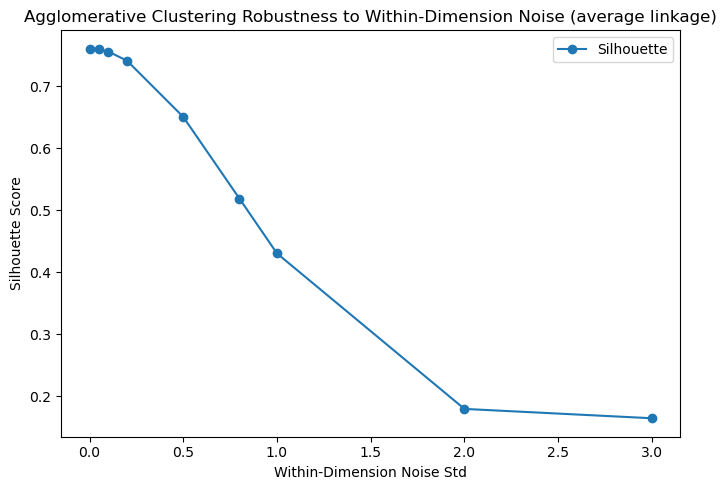

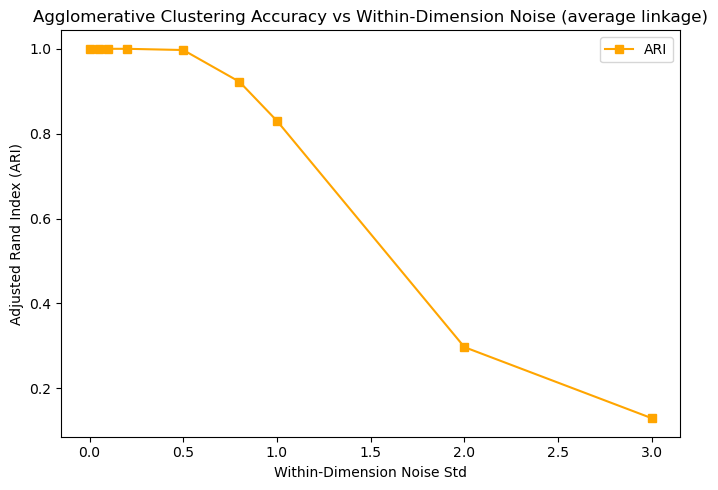


Running Agglomerative Clustering (within-dimension noise) with linkage = 'complete'
Within noise std: 0.0, Silhouette: 0.760, ARI: 1.000
Within noise std: 0.05, Silhouette: 0.759, ARI: 1.000
Within noise std: 0.1, Silhouette: 0.756, ARI: 1.000
Within noise std: 0.2, Silhouette: 0.741, ARI: 1.000
Within noise std: 0.5, Silhouette: 0.650, ARI: 0.997
Within noise std: 0.8, Silhouette: 0.490, ARI: 0.874
Within noise std: 1.0, Silhouette: 0.423, ARI: 0.837
Within noise std: 2.0, Silhouette: 0.187, ARI: 0.250
Within noise std: 3.0, Silhouette: 0.152, ARI: 0.141


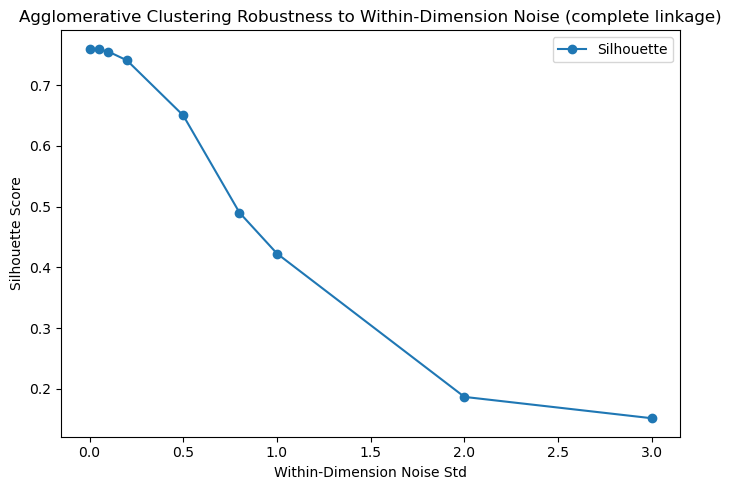

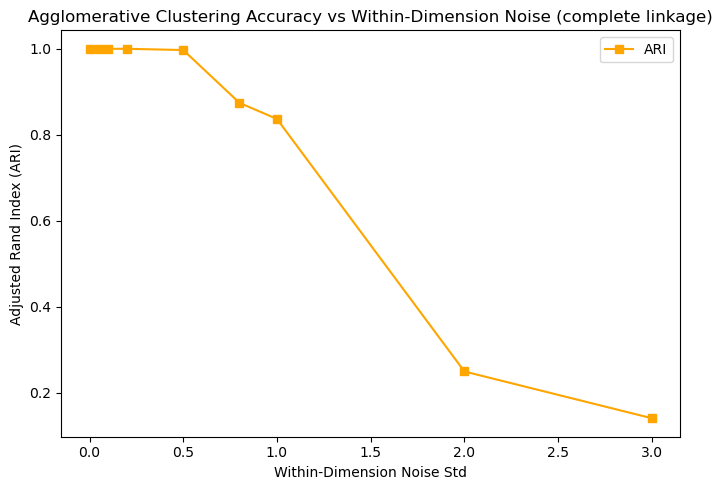


Running Agglomerative Clustering (within-dimension noise) with linkage = 'single'
Within noise std: 0.0, Silhouette: 0.760, ARI: 1.000
Within noise std: 0.05, Silhouette: 0.759, ARI: 1.000
Within noise std: 0.1, Silhouette: 0.756, ARI: 1.000
Within noise std: 0.2, Silhouette: 0.741, ARI: 1.000
Within noise std: 0.5, Silhouette: 0.479, ARI: 0.869
Within noise std: 0.8, Silhouette: -0.372, ARI: -0.000
Within noise std: 1.0, Silhouette: -0.328, ARI: 0.000
Within noise std: 2.0, Silhouette: -0.095, ARI: 0.000
Within noise std: 3.0, Silhouette: 0.015, ARI: 0.000


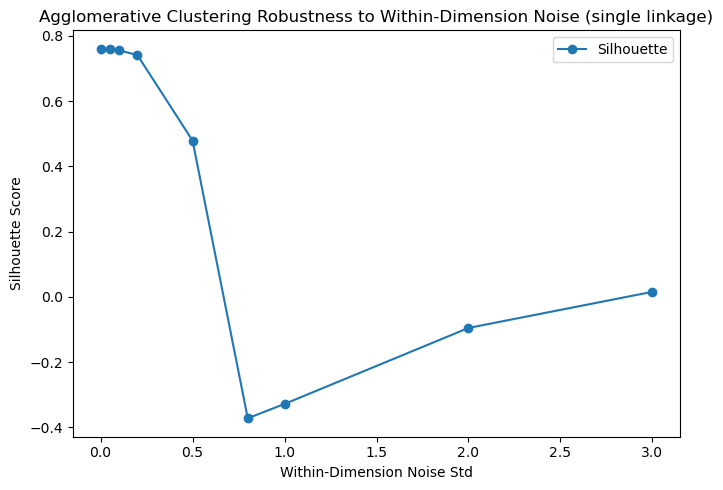

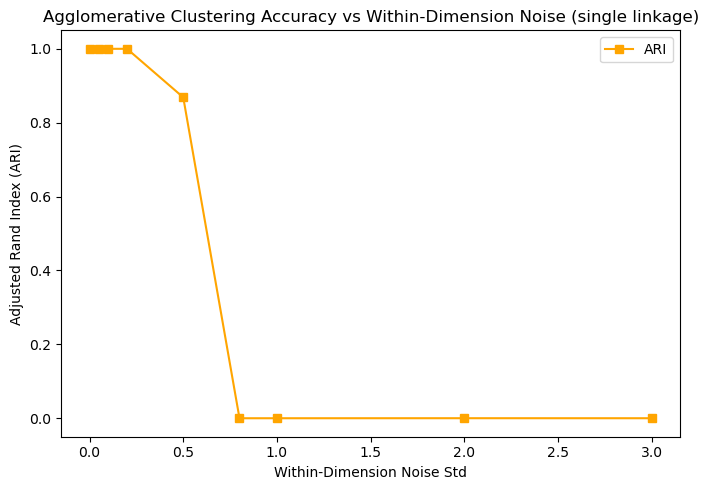

In [52]:
# Agglomerative Clustering with different linkages 
linkages_within = ['ward', 'average', 'complete', 'single']
agglo_scores_by_linkage_sil_within = {}  
agglo_scores_by_linkage_ari_within = {}  

# Within-dimension noise std levels
noise_stds = [0.0, 0.05, 0.1, 0.2, 0.5, 0.8, 1.0, 2.0, 3.0]

for link in linkages_within:
    agglo_sil_scores_w = []
    agglo_ari_scores_w = []

    print(f"\nRunning Agglomerative Clustering (within-dimension noise) with linkage = '{link}'")
    
    for std in noise_stds:
        X_noisy_w = add_within_dim_noise(X, std)
        
        if link == 'ward':
            model = AgglomerativeClustering(n_clusters=8, linkage=link)
        else:
            model = AgglomerativeClustering(n_clusters=8, linkage=link, metric='euclidean')
        
        labels_w = model.fit_predict(X_noisy_w)
        
        sil_w = silhouette_score(X_noisy_w, labels_w)
        ari_w = adjusted_rand_score(y, labels_w)  # y = true labels
        
        agglo_sil_scores_w.append(sil_w)
        agglo_ari_scores_w.append(ari_w)
        
        print(f"Within noise std: {std}, Silhouette: {sil_w:.3f}, ARI: {ari_w:.3f}")
    
    agglo_scores_by_linkage_sil_within[link] = agglo_sil_scores_w
    agglo_scores_by_linkage_ari_within[link] = agglo_ari_scores_w  

    # Plot Silhouette
    plt.figure(figsize=(7, 5))
    plt.plot(noise_stds, agglo_sil_scores_w, marker='o', label="Silhouette")
    plt.title(f'Agglomerative Clustering Robustness to Within-Dimension Noise ({link} linkage)')
    plt.xlabel('Within-Dimension Noise Std')
    plt.ylabel('Silhouette Score')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot ARI
    plt.figure(figsize=(7, 5))
    plt.plot(noise_stds, agglo_ari_scores_w, marker='s', label="ARI", color='orange')
    plt.title(f'Agglomerative Clustering Accuracy vs Within-Dimension Noise ({link} linkage)')
    plt.xlabel('Within-Dimension Noise Std')
    plt.ylabel('Adjusted Rand Index (ARI)')
    plt.legend()
    plt.tight_layout()
    plt.show()

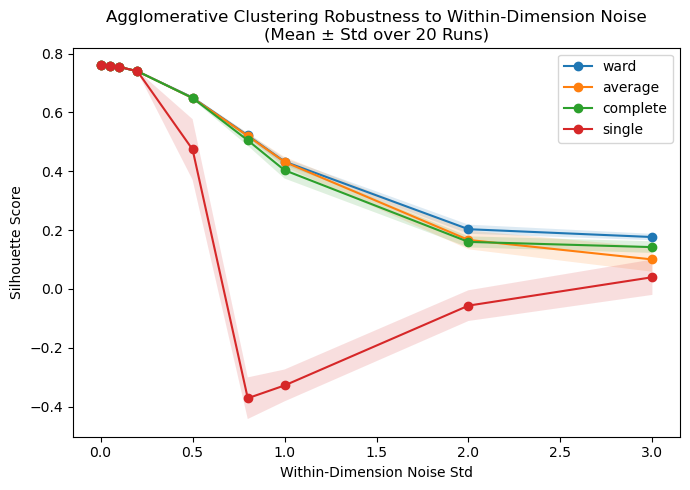

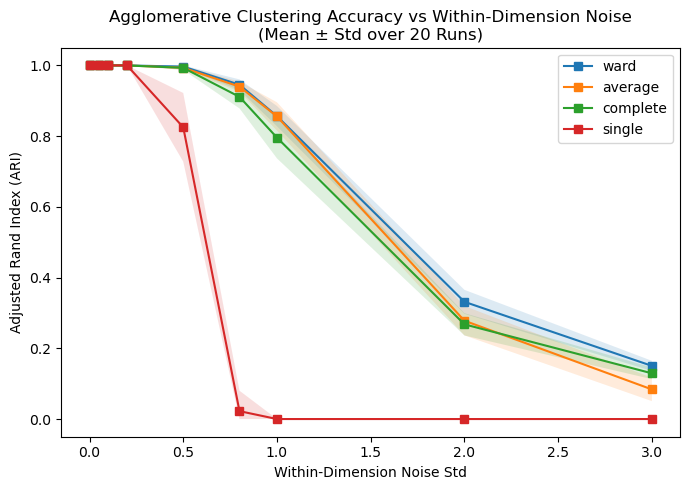

In [53]:
# Multi-run Agglomerative Clustering 
n_runs_within = 20
random_seeds_within = np.random.randint(0, 10000, size=n_runs_within)

linkages_within = ['ward', 'average', 'complete', 'single']

# Store results separately for Silhouette and ARI
agglo_scores_by_linkage_sil_within_multi = {}  
agglo_all_scores_by_linkage_sil_within_multi = {} 
agglo_scores_by_linkage_ari_within_multi = {}  
agglo_all_scores_by_linkage_ari_within_multi = {} 

# Within-dimension noise std levels
noise_stds = [0.0, 0.05, 0.1, 0.2, 0.5, 0.8, 1.0, 2.0, 3.0]


for link in linkages_within:
    mean_scores_sil_w = []
    std_scores_sil_w = []
    all_scores_sil_w = []
    
    mean_scores_ari_w = []
    std_scores_ari_w = []
    all_scores_ari_w = []
    
    for std in noise_stds:
        scores_sil_run_w = []
        scores_ari_run_w = []
        
        for seed in random_seeds_within:
            X_noisy_w = add_within_dim_noise(X, std, seed=seed)
            
            if link == 'ward':
                model = AgglomerativeClustering(n_clusters=8, linkage=link)
            else:
                model = AgglomerativeClustering(n_clusters=8, linkage=link, metric='euclidean')
            
            labels_w = model.fit_predict(X_noisy_w)
            
            sil_w = silhouette_score(X_noisy_w, labels_w)
            ari_w = adjusted_rand_score(y, labels_w)
            
            scores_sil_run_w.append(sil_w)
            scores_ari_run_w.append(ari_w)
        
        all_scores_sil_w.append(scores_sil_run_w)
        mean_scores_sil_w.append(np.mean(scores_sil_run_w))
        std_scores_sil_w.append(np.std(scores_sil_run_w))
        
        all_scores_ari_w.append(scores_ari_run_w)
        mean_scores_ari_w.append(np.mean(scores_ari_run_w))
        std_scores_ari_w.append(np.std(scores_ari_run_w))
    
    # Save results 
    agglo_scores_by_linkage_sil_within_multi[link] = (mean_scores_sil_w, std_scores_sil_w)
    agglo_all_scores_by_linkage_sil_within_multi[link] = all_scores_sil_w
    
    agglo_scores_by_linkage_ari_within_multi[link] = (mean_scores_ari_w, std_scores_ari_w)
    agglo_all_scores_by_linkage_ari_within_multi[link] = all_scores_ari_w

    # Plot Silhouette
plt.figure(figsize=(7, 5))
for link in linkages_within:
    means, stds = agglo_scores_by_linkage_sil_within_multi[link]
    means = np.array(means, dtype=float)
    stds = np.array(stds, dtype=float)
    
    plt.plot(noise_stds, means, marker='o', label=f'{link}')
    plt.fill_between(noise_stds, means - stds, means + stds, alpha=0.15)

plt.title('Agglomerative Clustering Robustness to Within-Dimension Noise\n(Mean ± Std over 20 Runs)')
plt.xlabel('Within-Dimension Noise Std')
plt.ylabel('Silhouette Score')
plt.legend()
plt.tight_layout()
plt.show()

# Plot ARI
plt.figure(figsize=(7, 5))
for link in linkages_within:
    means, stds = agglo_scores_by_linkage_ari_within_multi[link]
    means = np.array(means, dtype=float)
    stds = np.array(stds, dtype=float)
    
    # Clip to [0, 1] range for ARI
    lower = np.maximum(means - stds, 0.0)
    upper = np.minimum(means + stds, 1.0)
    
    plt.plot(noise_stds, means, marker='s', label=f'{link}')
    plt.fill_between(noise_stds, lower, upper, alpha=0.15)

plt.title('Agglomerative Clustering Accuracy vs Within-Dimension Noise\n(Mean ± Std over 20 Runs)')
plt.xlabel('Within-Dimension Noise Std')
plt.ylabel('Adjusted Rand Index (ARI)')
plt.legend()
plt.tight_layout()
plt.show()

## GMM

Noise std: 0.0, GMM Silhouette Score: 0.760, ARI: 1.000
Noise std: 0.05, GMM Silhouette Score: 0.759, ARI: 1.000
Noise std: 0.1, GMM Silhouette Score: 0.756, ARI: 1.000
Noise std: 0.2, GMM Silhouette Score: 0.741, ARI: 1.000
Noise std: 0.5, GMM Silhouette Score: 0.650, ARI: 0.997
Noise std: 0.8, GMM Silhouette Score: 0.527, ARI: 0.960
Noise std: 1.0, GMM Silhouette Score: 0.447, ARI: 0.905
Noise std: 2.0, GMM Silhouette Score: 0.250, ARI: 0.404
Noise std: 3.0, GMM Silhouette Score: 0.218, ARI: 0.187


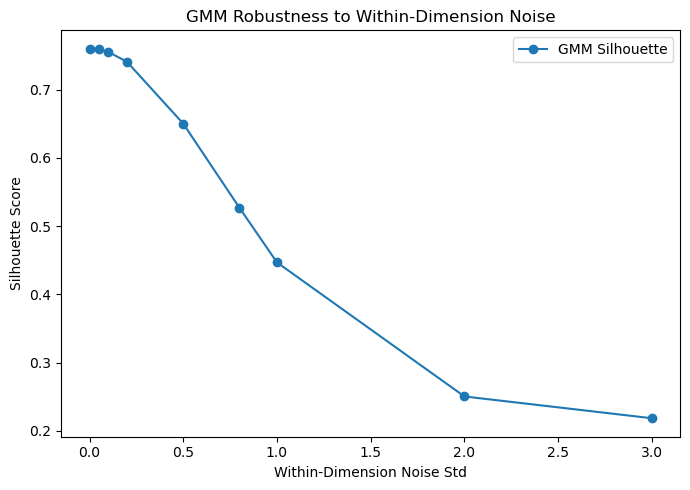

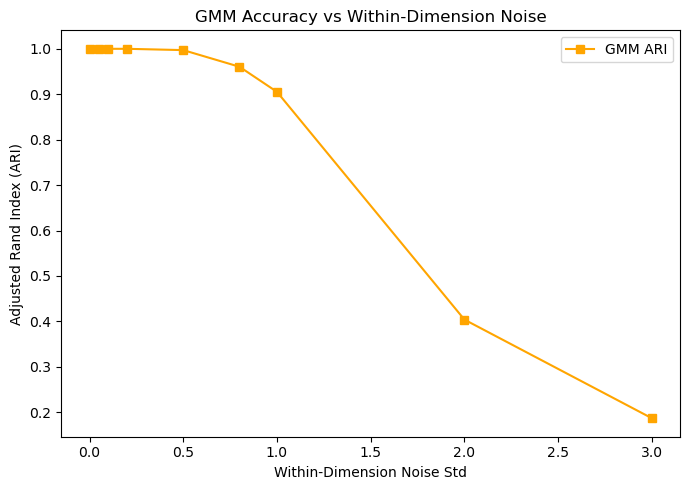

In [54]:
noise_stds = [0.0, 0.05, 0.1, 0.2, 0.5, 0.8, 1.0, 2.0, 3.0]

gmm_sil_scores_within = []
gmm_ari_scores_within = []

for std in noise_stds:
    X_noisy = add_within_dim_noise(X, std, seed=42)
    
    gmm = GaussianMixture(n_components=8, covariance_type='full', random_state=42)
    labels = gmm.fit_predict(X_noisy)
    
    sil = silhouette_score(X_noisy, labels)
    ari = adjusted_rand_score(y, labels)
    
    gmm_sil_scores_within.append(sil)
    gmm_ari_scores_within.append(ari)
    
    print(f"Noise std: {std}, GMM Silhouette Score: {sil:.3f}, ARI: {ari:.3f}")
    
# Plot Silhouette
plt.figure(figsize=(7, 5))
plt.plot(noise_stds, gmm_sil_scores_within, marker='o', label='GMM Silhouette')
plt.xlabel('Within-Dimension Noise Std')
plt.ylabel('Silhouette Score')
plt.title('GMM Robustness to Within-Dimension Noise')
plt.legend()
plt.tight_layout()
plt.show()

# Plot ARI
plt.figure(figsize=(7, 5))
plt.plot(noise_stds, gmm_ari_scores_within, marker='s', label='GMM ARI', color='orange')
plt.xlabel('Within-Dimension Noise Std')
plt.ylabel('Adjusted Rand Index (ARI)')
plt.title('GMM Accuracy vs Within-Dimension Noise')
plt.legend()
plt.tight_layout()
plt.show()

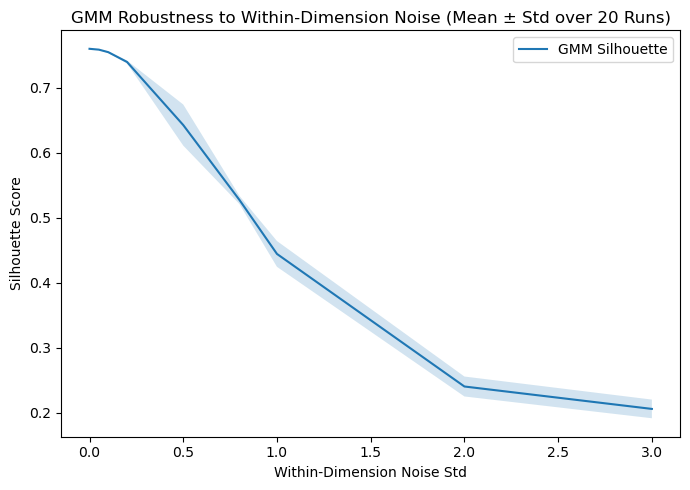

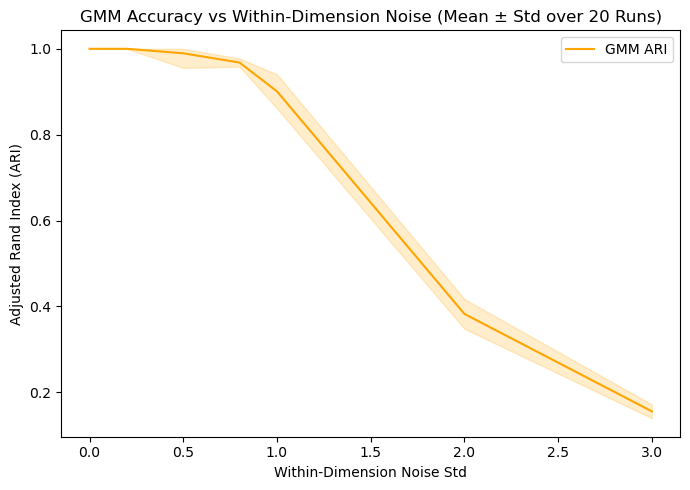

In [55]:
n_runs = 20
noise_stds = [0.0, 0.05, 0.1, 0.2, 0.5, 0.8, 1.0, 2.0, 3.0]
random_seeds_within = np.random.randint(0, 10000, size=n_runs)

# Silhouette storage
gmm_within_means_sil = []
gmm_within_stds_sil = []
gmm_within_all_scores_sil = []

# ARI storage
gmm_within_means_ari = []
gmm_within_stds_ari = []
gmm_within_all_scores_ari = []

for std in noise_stds:
    gmm_sil_scores_within1 = []
    gmm_ari_scores_within1 = []

    for seed in random_seeds_within:
        # Add within-dimension noise using the varying seed
        X_noisy = add_within_dim_noise(X, noise_std=std, seed=seed)

        gmm = GaussianMixture(n_components=8, covariance_type='full', random_state=42)
        labels = gmm.fit_predict(X_noisy)

        sil = silhouette_score(X_noisy, labels)
        ari = adjusted_rand_score(y, labels)

        gmm_sil_scores_within1.append(sil)
        gmm_ari_scores_within1.append(ari)

    # Store Silhouette stats
    gmm_within_all_scores_sil.append(gmm_sil_scores_within1)
    gmm_within_means_sil.append(np.mean(gmm_sil_scores_within1))
    gmm_within_stds_sil.append(np.std(gmm_sil_scores_within1))

    # Store ARI stats
    gmm_within_all_scores_ari.append(gmm_ari_scores_within1)
    gmm_within_means_ari.append(np.mean(gmm_ari_scores_within1))
    gmm_within_stds_ari.append(np.std(gmm_ari_scores_within1))

# silhoutte
plt.figure(figsize=(7, 5))
plt.plot(noise_stds, gmm_within_means_sil, label='GMM Silhouette')
plt.fill_between(noise_stds,
                 np.array(gmm_within_means_sil) - np.array(gmm_within_stds_sil),
                 np.array(gmm_within_means_sil) + np.array(gmm_within_stds_sil),
                 alpha=0.2)
plt.xlabel("Within-Dimension Noise Std")
plt.ylabel("Silhouette Score")
plt.title("GMM Robustness to Within-Dimension Noise (Mean ± Std over 20 Runs)")
plt.legend()
plt.tight_layout()
plt.show()

# ARI
plt.figure(figsize=(7, 5))
plt.plot(noise_stds, gmm_within_means_ari, label='GMM ARI', color='orange')

upper_whithin_gmm = np.minimum(np.array(gmm_within_means_ari) + np.array(gmm_within_stds_ari), 1.0)
lower_whithin_gmm = np.maximum(np.array(gmm_within_means_ari) - np.array(gmm_within_stds_ari), 0.0)

plt.fill_between(noise_stds, lower_whithin_gmm, upper_whithin_gmm, alpha=0.2, color='orange')
plt.xlabel("Within-Dimension Noise Std")
plt.ylabel("Adjusted Rand Index (ARI)")
plt.title("GMM Accuracy vs Within-Dimension Noise (Mean ± Std over 20 Runs)")
plt.legend()
plt.tight_layout()
plt.show()


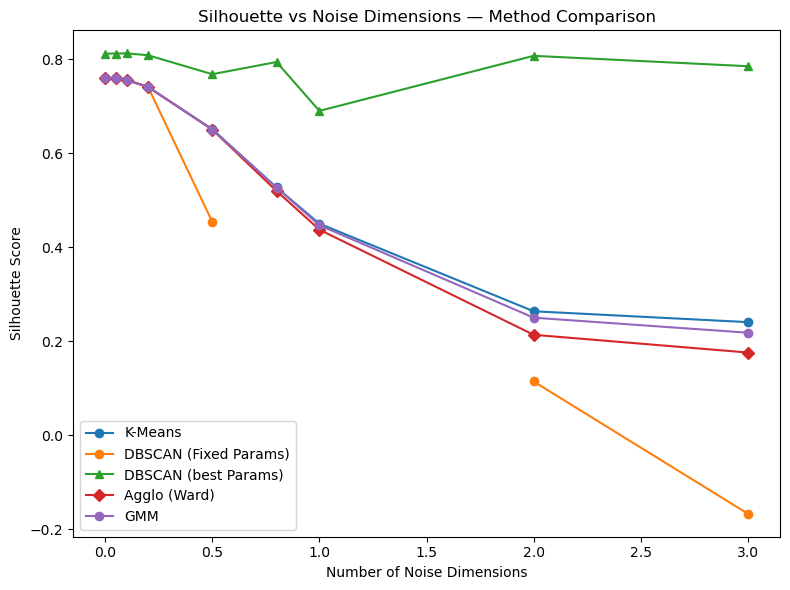

In [56]:
# SIL plot comparison
plt.figure(figsize=(8, 6))

# K-Means
plt.plot(noise_stds, kmeans_sil_scores_within, marker='o', label="K-Means")

# DBSCAN (fixed params)
plt.plot(noise_stds_dbscan_fixed, sil_ma_dbscan_fixed, marker='o', label='DBSCAN (Fixed Params)')

# DBSCAN (best params)
plt.plot(noise_stds_arr, sil_best_arr2, marker='^', label='DBSCAN (best Params)')

# Agglomerative (ward)
plt.plot(noise_stds, agglo_scores_by_linkage_sil_within['ward'], marker='D', label="Agglo (Ward)")

# GMM
plt.plot(noise_stds, gmm_sil_scores_within, marker='o', label='GMM')

plt.title('Silhouette vs Noise Dimensions — Method Comparison')
plt.xlabel('Number of Noise Dimensions')
plt.ylabel('Silhouette Score')
plt.legend()
plt.tight_layout()
plt.show()

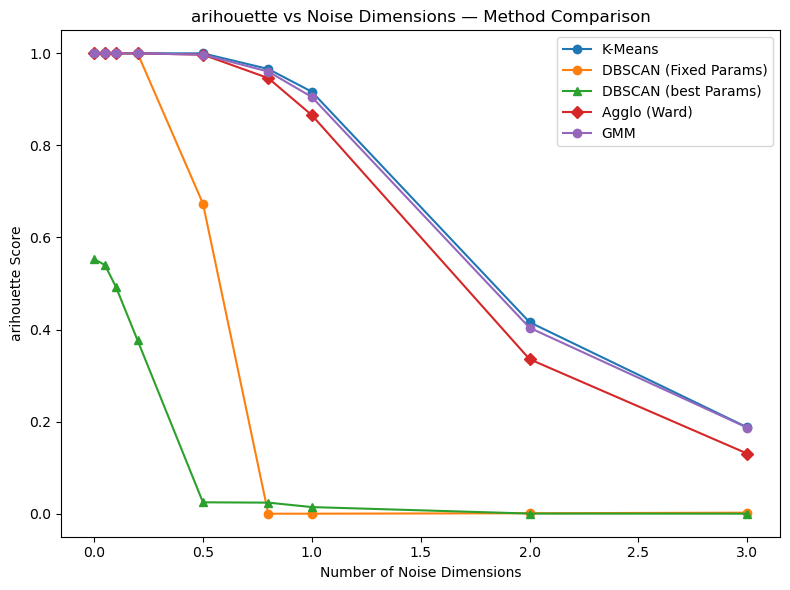

In [57]:
# ARI plot comparison
plt.figure(figsize=(8, 6))

# K-Means
plt.plot(noise_stds, kmeans_ari_scores_within, marker='o', label="K-Means")

# DBSCAN (fixed params)
plt.plot(noise_stds_dbscan_fixed, ari_dbscan_fixed, marker='o', label='DBSCAN (Fixed Params)')

# DBSCAN (best params)
plt.plot(noise_stds_arr, ari_best_arr2, marker='^', label='DBSCAN (best Params)')

# Agglomerative (ward)
plt.plot(noise_stds, agglo_scores_by_linkage_ari_within['ward'], marker='D', label="Agglo (Ward)")

# GMM
plt.plot(noise_stds, gmm_ari_scores_within, marker='o', label='GMM')

plt.title('arihouette vs Noise Dimensions — Method Comparison')
plt.xlabel('Number of Noise Dimensions')
plt.ylabel('arihouette Score')
plt.legend()
plt.tight_layout()
plt.show()

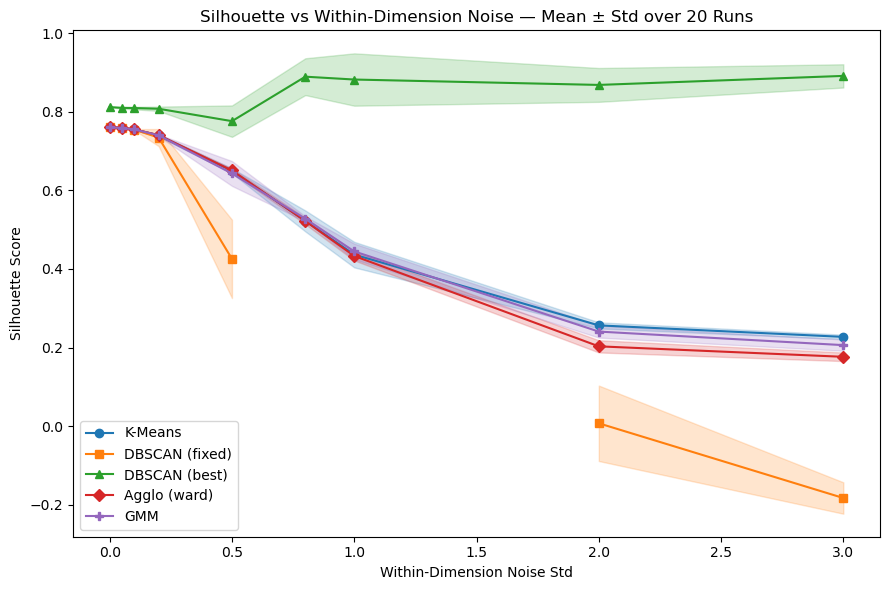

In [58]:
# Silhouette comparison across algorithms (within-dimension noise) 
plt.figure(figsize=(9, 6))

# Within-Dimension Noise
km_mean = np.array(kmeans_within_sil_means, dtype=float)
km_std  = np.array(kmeans_within_sil_stds, dtype=float)
line_km, = plt.plot(noise_stds, km_mean, marker='o', label='K-Means')
plt.fill_between(
    noise_stds,
    np.clip(km_mean - km_std, -1, 1),
    np.clip(km_mean + km_std, -1, 1),
    alpha=0.2, color=line_km.get_color()
)

# DBSCAN (fixed params)
# Must use the *within* variables and contiguous-segment fill
line_dbfix, = plt.plot(
    noise_stds_within_arr, sil_within_means_plot, marker='s', label='DBSCAN (fixed)'
)

valid_idx = np.where(band_mask_within)[0]
segments = np.split(valid_idx, np.where(np.diff(valid_idx) != 1)[0] + 1)
for seg in segments:
    if len(seg) < 2:
        continue
    plt.fill_between(
        noise_stds_within_arr[seg],
        np.clip(sil_within_means_arr[seg] - sil_within_stds_arr[seg], -1, 1),
        np.clip(sil_within_means_arr[seg] + sil_within_stds_arr[seg], -1, 1),
        alpha=0.2, color=line_dbfix.get_color()
    )

# DBSCAN (best params)
bs_mean = np.array(best_sil_mean_within, dtype=float)
bs_std  = np.array(best_sil_std_within, dtype=float)
line_dbbest, = plt.plot(noise_stds, bs_mean, marker='^', label='DBSCAN (best)')
plt.fill_between(
    noise_stds,
    np.clip(bs_mean - bs_std, -1, 1),
    np.clip(bs_mean + bs_std, -1, 1),
    alpha=0.2, color=line_dbbest.get_color()
)

# Agglomerative (ward)
ward_means, ward_stds = agglo_scores_by_linkage_sil_within_multi['ward']
ward_means = np.array(ward_means, dtype=float)
ward_stds  = np.array(ward_stds, dtype=float)
line_ward, = plt.plot(noise_stds, ward_means, marker='D', label='Agglo (ward)')
plt.fill_between(
    noise_stds,
    np.clip(ward_means - ward_stds, -1, 1),
    np.clip(ward_means + ward_stds, -1, 1),
    alpha=0.2, color=line_ward.get_color()
)

# GMM
gmm_mean = np.array(gmm_within_means_sil, dtype=float)
gmm_std  = np.array(gmm_within_stds_sil, dtype=float)
line_gmm, = plt.plot(noise_stds, gmm_mean, marker='P', label='GMM')
plt.fill_between(
    noise_stds,
    np.clip(gmm_mean - gmm_std, -1, 1),
    np.clip(gmm_mean + gmm_std, -1, 1),
    alpha=0.2, color=line_gmm.get_color()
)

plt.title('Silhouette vs Within-Dimension Noise — Mean ± Std over 20 Runs')
plt.xlabel('Within-Dimension Noise Std')
plt.ylabel('Silhouette Score')
plt.legend()
plt.tight_layout()
plt.show()


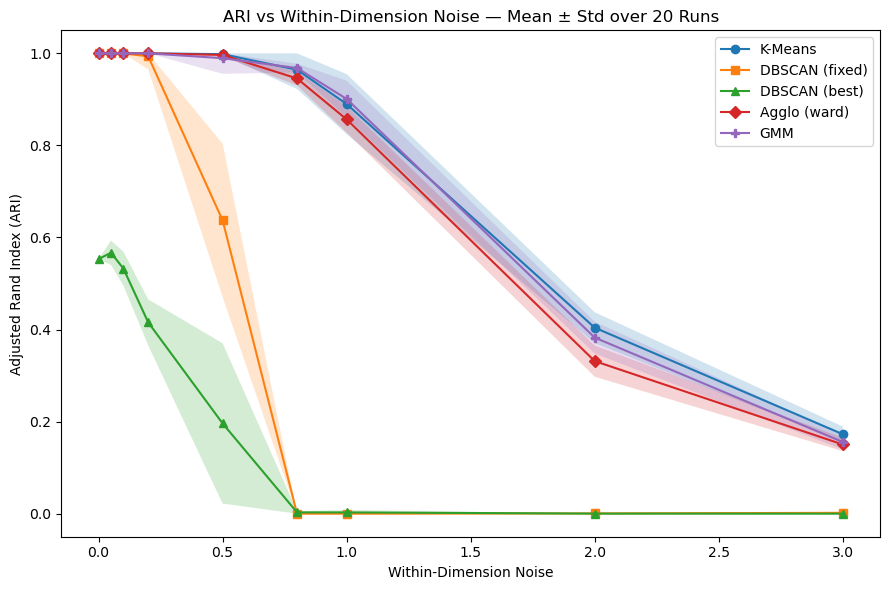

In [59]:
# ARI comparison across algorithms (within-dimension noise) 
plt.figure(figsize=(9, 6))

# Kmeans
km_mean = np.array(kmeans_within_ari_means, dtype=float)
km_std  = np.array(kmeans_within_ari_stds, dtype=float)
upper = np.minimum(km_mean + km_std, 1.0)
lower = np.maximum(km_mean - km_std, 0.0)
plt.plot(noise_stds, km_mean, marker='o', label='K-Means')
plt.fill_between(noise_stds, lower, upper, alpha=0.2)

# DBSCAN (fixed params)
ari_means_arr = np.array(ari_within_means_arr, dtype=float)
ari_stds_arr  = np.array(ari_within_stds_arr, dtype=float)
band_mask = ~np.isnan(ari_means_arr)
upper = np.minimum((ari_means_arr + ari_stds_arr)[band_mask], 1.0)
lower = np.maximum((ari_means_arr - ari_stds_arr)[band_mask], 0.0)
plt.plot(noise_stds_within_arr, ari_means_arr, marker='s', label='DBSCAN (fixed)')
plt.fill_between(noise_stds_arr[band_mask], lower, upper, alpha=0.2)

# DBSCAN (best params)
bs_mean = np.array(best_ari_mean_within, dtype=float)
bs_std  = np.array(best_ari_std_within, dtype=float)
upper = np.minimum(bs_mean + bs_std, 1.0)
lower = np.maximum(bs_mean - bs_std, 0.0)
plt.plot(noise_stds, bs_mean, marker='^', label='DBSCAN (best)')
plt.fill_between(noise_stds, lower, upper, alpha=0.2)

# Agglomerative (ward)
ward_means, ward_stds = agglo_scores_by_linkage_ari_within_multi['ward']
ward_means = np.array(ward_means, dtype=float)
ward_stds  = np.array(ward_stds, dtype=float)
upper = np.minimum(ward_means + ward_stds, 1.0)
lower = np.maximum(ward_means - ward_stds, 0.0)
plt.plot(noise_stds, ward_means, marker='D', label='Agglo (ward)')
plt.fill_between(noise_stds, lower, upper, alpha=0.2)

# GMM
gmm_mean = np.array(gmm_within_means_ari, dtype=float)
gmm_std  = np.array(gmm_within_stds_ari, dtype=float)
upper = np.minimum(gmm_mean + gmm_std, 1.0)
lower = np.maximum(gmm_mean - gmm_std, 0.0)
plt.plot(noise_stds, gmm_mean, marker='P', label='GMM')
plt.fill_between(noise_stds, lower, upper, alpha=0.2)

plt.title('ARI vs Within-Dimension Noise — Mean ± Std over 20 Runs')
plt.xlabel('Within-Dimension Noise')
plt.ylabel('Adjusted Rand Index (ARI)')
plt.legend()
plt.tight_layout()
plt.show()


## Extra Experiment

In [34]:
# Run experiment with diff noise std
# Parameters
noise_stds = [0.5, 1.0, 2.0, 3.0, 4.0]
noise_dims = range(0, 11)
silhouette_results = {}
ari_results = {}

# Run experiment
for std in noise_stds:
    print(f"\nRunning for noise std = {std}")
    sil_scores = []
    ari_scores = []

    for d in noise_dims:
        X_noisy = add_noise_dims(X, d, std=std)
        
        kmeans = KMeans(n_clusters=8, random_state=42, n_init='auto')
        labels = kmeans.fit_predict(X_noisy)
        
        sil = silhouette_score(X_noisy, labels)
        ari = adjusted_rand_score(y, labels)
        
        sil_scores.append(sil)
        ari_scores.append(ari)

        print(f"  Noise dims: {d}, Silhouette: {sil:.3f}, ARI: {ari:.3f}")
    
    silhouette_results[std] = sil_scores
    ari_results[std] = ari_scores


Running for noise std = 0.5
  Noise dims: 0, Silhouette: 0.760, ARI: 1.000
  Noise dims: 1, Silhouette: 0.724, ARI: 1.000
  Noise dims: 2, Silhouette: 0.689, ARI: 1.000
  Noise dims: 3, Silhouette: 0.660, ARI: 1.000
  Noise dims: 4, Silhouette: 0.633, ARI: 1.000
  Noise dims: 5, Silhouette: 0.608, ARI: 1.000
  Noise dims: 6, Silhouette: 0.586, ARI: 1.000
  Noise dims: 7, Silhouette: 0.572, ARI: 1.000
  Noise dims: 8, Silhouette: 0.552, ARI: 1.000
  Noise dims: 9, Silhouette: 0.537, ARI: 1.000
  Noise dims: 10, Silhouette: 0.518, ARI: 1.000

Running for noise std = 1.0
  Noise dims: 0, Silhouette: 0.760, ARI: 1.000
  Noise dims: 1, Silhouette: 0.649, ARI: 1.000
  Noise dims: 2, Silhouette: 0.570, ARI: 1.000
  Noise dims: 3, Silhouette: 0.512, ARI: 1.000
  Noise dims: 4, Silhouette: 0.457, ARI: 1.000
  Noise dims: 5, Silhouette: 0.432, ARI: 1.000
  Noise dims: 6, Silhouette: 0.312, ARI: 0.833
  Noise dims: 7, Silhouette: 0.361, ARI: 1.000
  Noise dims: 8, Silhouette: 0.340, ARI: 1.000
 

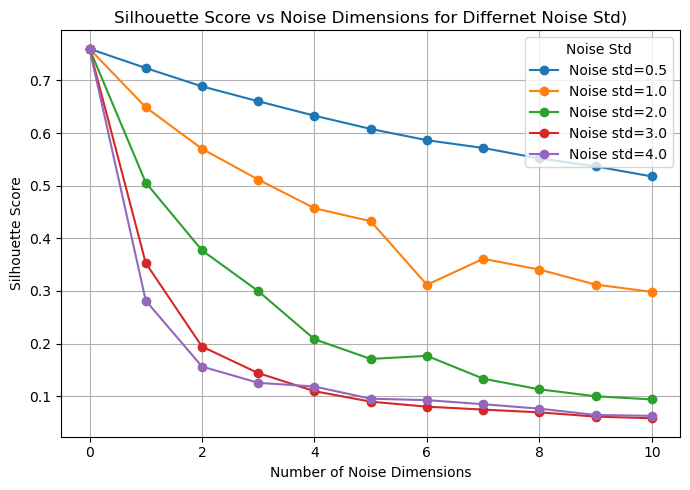

In [35]:
plt.figure(figsize=(7, 5))
for std, scores in silhouette_results.items():
    plt.plot(noise_dims, scores, marker='o', label=f"Noise std={std}")

plt.title("Silhouette Score vs Noise Dimensions for Differnet Noise Std)")
plt.xlabel("Number of Noise Dimensions")
plt.ylabel("Silhouette Score")
plt.legend(title="Noise Std")
plt.grid(True)
plt.tight_layout()
plt.show()


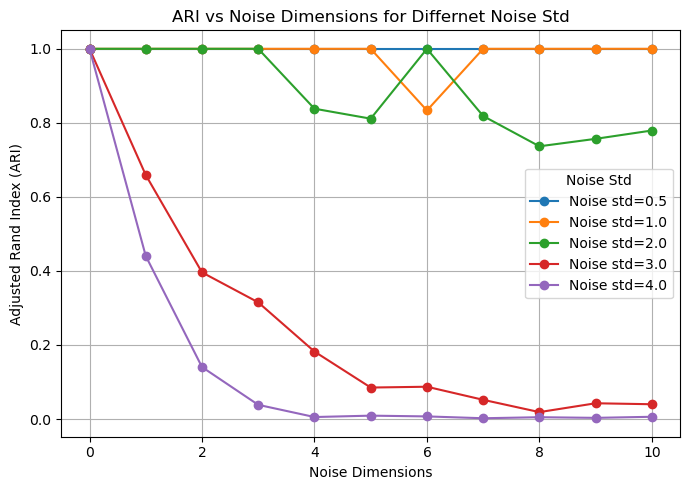

In [36]:
plt.figure(figsize=(7, 5))
for std, scores in ari_results.items():
    plt.plot(noise_dims, scores, marker='o', label=f"Noise std={std}")
    
plt.title("ARI vs Noise Dimensions for Differnet Noise Std")
plt.xlabel("Noise Dimensions")
plt.ylabel("Adjusted Rand Index (ARI)")
plt.legend(title="Noise Std")
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
# Experiment with different cluster std
cluster_stds = [0.5, 1.0, 1.5, 2.0]
results = {}

for std in cluster_stds:
    # Generate clusters with the given spread
    X_2, y_2 = generate_and_plot_clusters_3d(n_samples=800, cluster_std=std, plot=False)
    
    # Apply KMeans directly without adding noise dimensions
    kmeans = KMeans(n_clusters=8, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_2)
    
    # Calculate Silhouette score
    sil = silhouette_score(X_2, labels)
    
    results[std] = sil
    print(f"Cluster std: {std}, Silhouette Score: {sil:.3f}")


Cluster std: 0.5, Silhouette Score: 0.760
Cluster std: 1.0, Silhouette Score: 0.509
Cluster std: 1.5, Silhouette Score: 0.348
Cluster std: 2.0, Silhouette Score: 0.272


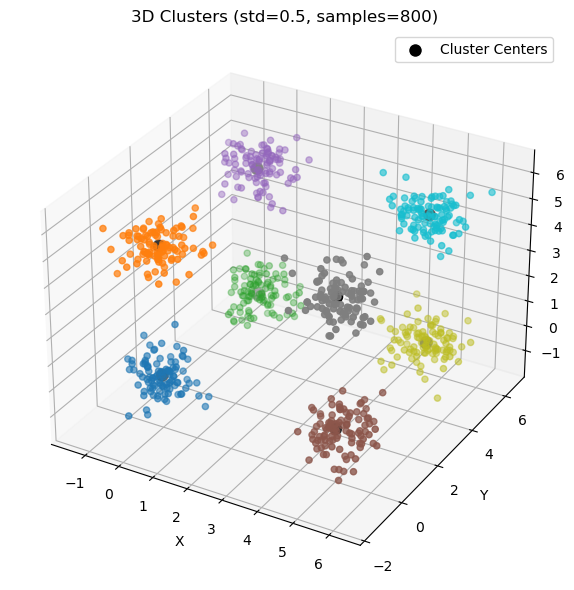

  Noise dims: 0, Silhouette Score: 0.760
  Noise dims: 1, Silhouette Score: 0.653
  Noise dims: 2, Silhouette Score: 0.569
  Noise dims: 3, Silhouette Score: 0.513
  Noise dims: 4, Silhouette Score: 0.360
  Noise dims: 5, Silhouette Score: 0.422
  Noise dims: 6, Silhouette Score: 0.309
  Noise dims: 7, Silhouette Score: 0.285
  Noise dims: 8, Silhouette Score: 0.263
  Noise dims: 9, Silhouette Score: 0.319
  Noise dims: 10, Silhouette Score: 0.302


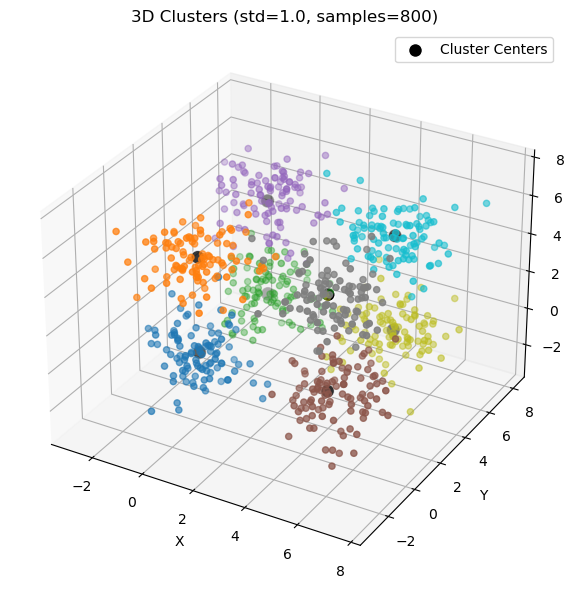

  Noise dims: 0, Silhouette Score: 0.509
  Noise dims: 1, Silhouette Score: 0.446
  Noise dims: 2, Silhouette Score: 0.407
  Noise dims: 3, Silhouette Score: 0.288
  Noise dims: 4, Silhouette Score: 0.332
  Noise dims: 5, Silhouette Score: 0.248
  Noise dims: 6, Silhouette Score: 0.287
  Noise dims: 7, Silhouette Score: 0.215
  Noise dims: 8, Silhouette Score: 0.254
  Noise dims: 9, Silhouette Score: 0.240
  Noise dims: 10, Silhouette Score: 0.224


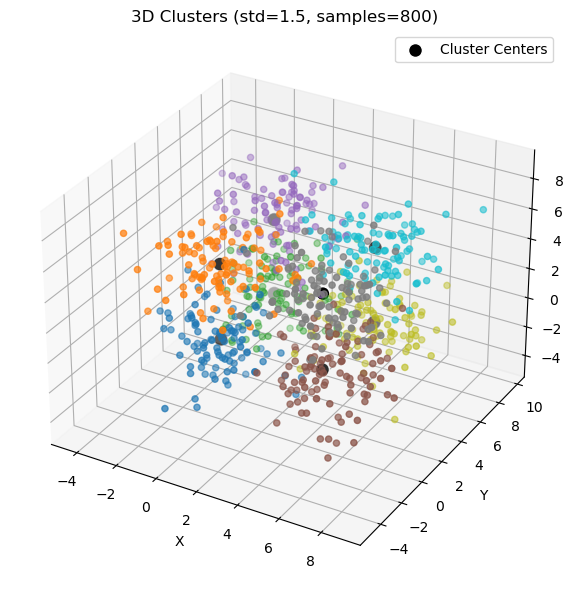

  Noise dims: 0, Silhouette Score: 0.348
  Noise dims: 1, Silhouette Score: 0.277
  Noise dims: 2, Silhouette Score: 0.287
  Noise dims: 3, Silhouette Score: 0.267
  Noise dims: 4, Silhouette Score: 0.243
  Noise dims: 5, Silhouette Score: 0.202
  Noise dims: 6, Silhouette Score: 0.216
  Noise dims: 7, Silhouette Score: 0.202
  Noise dims: 8, Silhouette Score: 0.189
  Noise dims: 9, Silhouette Score: 0.180
  Noise dims: 10, Silhouette Score: 0.172


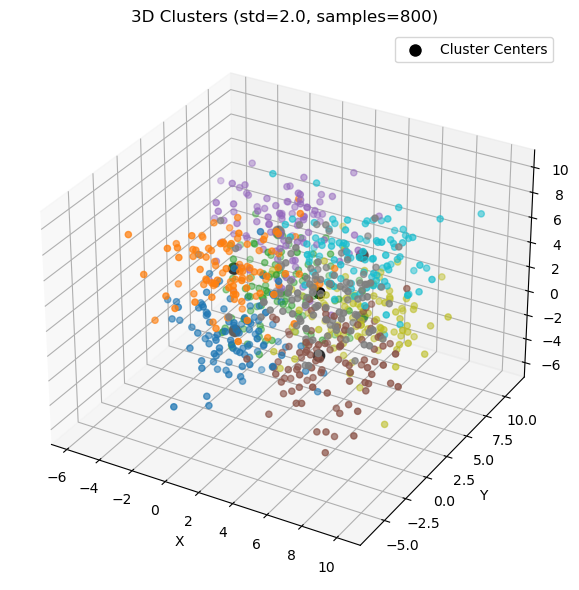

  Noise dims: 0, Silhouette Score: 0.272
  Noise dims: 1, Silhouette Score: 0.240
  Noise dims: 2, Silhouette Score: 0.229
  Noise dims: 3, Silhouette Score: 0.219
  Noise dims: 4, Silhouette Score: 0.189
  Noise dims: 5, Silhouette Score: 0.192
  Noise dims: 6, Silhouette Score: 0.180
  Noise dims: 7, Silhouette Score: 0.172
  Noise dims: 8, Silhouette Score: 0.163
  Noise dims: 9, Silhouette Score: 0.158
  Noise dims: 10, Silhouette Score: 0.149


In [38]:
# Experiment with different cluster std with adding different noise dimension
cluster_stds = [0.5, 1.0, 1.5, 2.0]
noise_dims = range(0, 11)
results = {}

for std in cluster_stds:
    X_2, y_2 = generate_and_plot_clusters_3d(n_samples=800, cluster_std=std)
    
    sil_scores_exp1 = []
    
    for d in noise_dims:
        X_noisy = add_noise_dims(X_2, d, std=1.0)  # keep noise std fixed
        
        kmeans = KMeans(n_clusters=8, random_state=42, n_init='auto')
        labels = kmeans.fit_predict(X_noisy)
        
        sil = silhouette_score(X_noisy, labels)
        sil_scores_exp1.append(sil)
        print(f"  Noise dims: {d}, Silhouette Score: {sil:.3f}")
    
    results[std] = sil_scores_exp1

## Stability Check

Check how consistent are the clusterings between two noisy versions with measuring by ARI between runs

To evaluate the robustness of clustering, we measure how consistent the cluster assignments are when the data is slightly perturbed by noise.

We generate two noisy versions of the same dataset by adding independent Gaussian noise and controlled by noise_dims and noise_std. Then, we apply KMeans clustering to both versions and compare the resulting cluster labels using the Adjusted Rand Index (ARI).

In [39]:
def clustering_stability_ari(X, n_clusters=8, num_trials=10, noise_dims=5, noise_std=1.0):
    ari_scores = []

    for i in range(num_trials):
        # Add different random noise to same data
        rng1 = np.random.default_rng(42 + i)
        rng2 = np.random.default_rng(100 + i)
        noise1 = rng1.normal(0, noise_std, size=(X.shape[0], noise_dims))
        noise2 = rng2.normal(0, noise_std, size=(X.shape[0], noise_dims))

        X1 = np.hstack([X, noise1])
        X2 = np.hstack([X, noise2])

        # Run KMeans on both noisy versions
        kmeans1 = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
        kmeans2 = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
        labels1 = kmeans1.fit_predict(X1)
        labels2 = kmeans2.fit_predict(X2)

        # Compare cluster assignments
        ari = adjusted_rand_score(labels1, labels2)
        ari_scores.append(ari)
        print(f"Trial {i+1:2d}: ARI = {ari:.3f}")

    print(f"\nAverage ARI over {num_trials} noisy trials: {np.mean(ari_scores):.3f}")
    return ari_scores

In [40]:
ari_scores = clustering_stability_ari(X, n_clusters=8, num_trials=10, noise_dims=5, noise_std=1.0)

Trial  1: ARI = 0.833
Trial  2: ARI = 1.000
Trial  3: ARI = 0.832
Trial  4: ARI = 1.000
Trial  5: ARI = 0.834
Trial  6: ARI = 0.834
Trial  7: ARI = 1.000
Trial  8: ARI = 1.000
Trial  9: ARI = 1.000
Trial 10: ARI = 0.837

Average ARI over 10 noisy trials: 0.917


In [41]:
rng1 = np.random.default_rng(42 + 2)
rng2 = np.random.default_rng(100 + 1)
noise1 = rng1.normal(0, 2, size=(X.shape[0], 1))
noise2 = rng2.normal(0, 2, size=(X.shape[0], 2))

X1 = np.hstack([X, noise1])
X2 = np.hstack([X, noise2])


In [42]:
X1

array([[ 5.36254789,  5.25808914, -0.3207408 ,  2.89192547],
       [-0.13636178,  3.65155668, -0.02714743,  0.20461028],
       [ 0.25202326, -0.26512881,  4.60356358,  0.65350556],
       ...,
       [ 1.2866799 ,  5.02960922,  0.00696465,  2.15782541],
       [-0.24471972,  5.52208044,  0.34094574, -1.46375664],
       [ 5.00517631, -0.65591812, -0.53255683, -0.96157405]])

In [43]:
X2

array([[ 5.36254789,  5.25808914, -0.3207408 , -1.580305  , -4.06925096],
       [-0.13636178,  3.65155668, -0.02714743,  1.20660349,  1.48858906],
       [ 0.25202326, -0.26512881,  4.60356358, -0.6193736 ,  0.73464275],
       ...,
       [ 1.2866799 ,  5.02960922,  0.00696465, -0.32124288, -1.83032707],
       [-0.24471972,  5.52208044,  0.34094574,  0.37905807,  1.48123178],
       [ 5.00517631, -0.65591812, -0.53255683,  0.02130635, -0.88531752]])